<a href="https://colab.research.google.com/github/Heba-Atef99/Air-Passengers-Time-Series-/blob/main/Airlines_Passengers_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team members:

* Name: Alaa Ali Hassan Sherif
* Email: allaashreef00@gmail.com

* Name: Hamsa Wahed Hamed Alawadly
* Email: hamsawahed98@gmail.com

* Name: Hebat-Allah Atef Ahmed
* Email: heba.atef.muhammed@gmail.com

* Name: Ishraq Ahmed Jamaluddin
* Email: ishraqahmedjamaluddin@gmail.com

In [ ]:
from google.colab import drive

drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import  Holt
import calendar
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load Data

In [ ]:
path = '/content/MyDrive/MyDrive/airline-passengers.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df_series = pd.read_csv(path,header=0, index_col=0, parse_dates=True, squeeze=True)

<ipython-input-5-c6933b57d893>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df_series = pd.read_csv(path,header=0, index_col=0, parse_dates=True, squeeze=True)


In [ ]:
df.head()

Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

In [ ]:
df.sample(10)

Month  Passengers
104  1957-09         404
7    1949-08         148
72   1955-01         242
4    1949-05         121
42   1952-07         230
1    1949-02         118
116  1958-09         404
28   1951-05         172
93   1956-10         306
10   1949-11         104

# 1. EDA

We will take a quick look at the data and as we see it is a monthly data.

In [ ]:
df.head()

Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

Now, let's get quick information about the dataset. We find that:
- There are no null values
- Month column is of object datatype

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


As for some statistics about the numerical column (number of passengers), we notice that the data distribution is right skewed

In [ ]:
df.describe()

Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000

The histogram shows a non-normal distribution, confirming that this data is non stationary

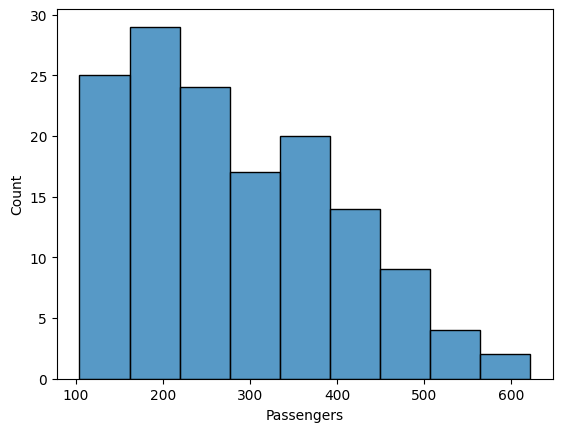

In [ ]:
sns.histplot(data=df, x='Passengers');

After visualizing the data, we can see the clear up trend and seasonality in the time series.

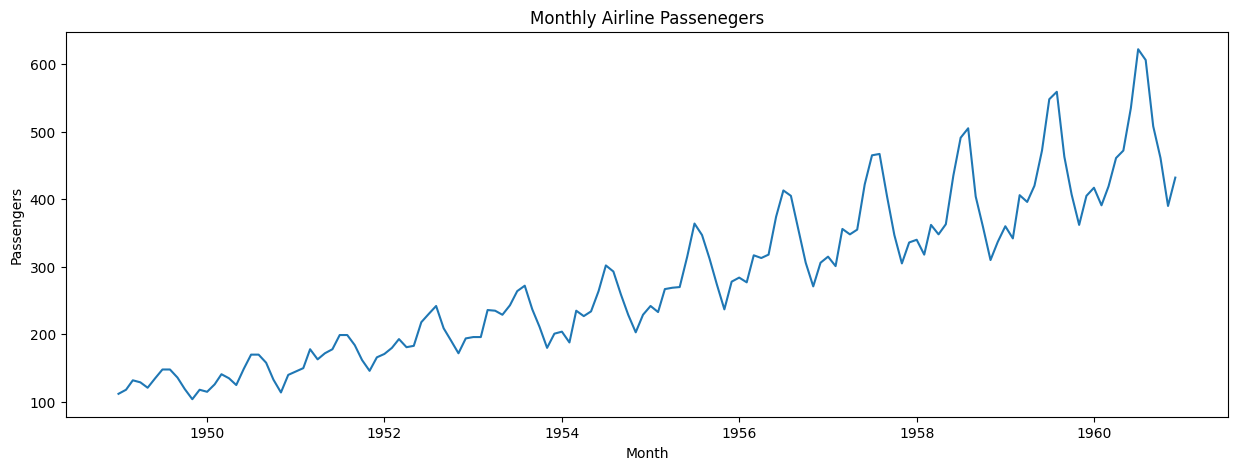

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
plt.figure(figsize=(15, 5));
sns.lineplot(data=df, x='Month', y='Passengers');
plt.title('Monthly Airline Passenegers');

#### From the previous plots, we noticed:
* It seems that the data is non-stationary.
* In other words, the data has variable mean and variance as it has trend and seasonality
* Data has increasing trend and multiplicative seasonality

Now we will try to visualize the passenger numbers on the month level and year level 

In [ ]:
new_df = df.copy()

In [ ]:
new_df['Month'] = pd.to_datetime(new_df['Month'])
new_df.rename(columns = {'Month':'Date'}, inplace = True)
new_df['Month'] = new_df['Date'].dt.month
new_df['Year'] = new_df['Date'].dt.year

In [ ]:
# Show month abbreviation
new_df['Month'] = [calendar.month_abbr[ind] for ind in new_df['Month']]

In [ ]:
new_df.head()

Date  Passengers Month  Year
0 1949-01-01         112   Jan  1949
1 1949-02-01         118   Feb  1949
2 1949-03-01         132   Mar  1949
3 1949-04-01         129   Apr  1949
4 1949-05-01         121   May  1949

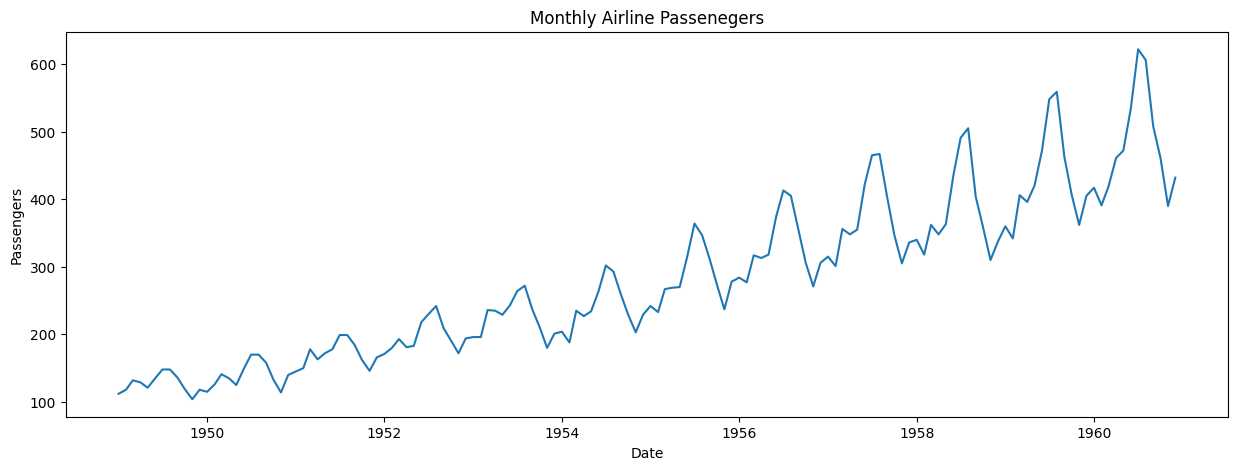

In [ ]:
plt.figure(figsize=(15, 5));
sns.lineplot(data=new_df, x='Date', y='Passengers');
plt.title('Monthly Airline Passenegers');

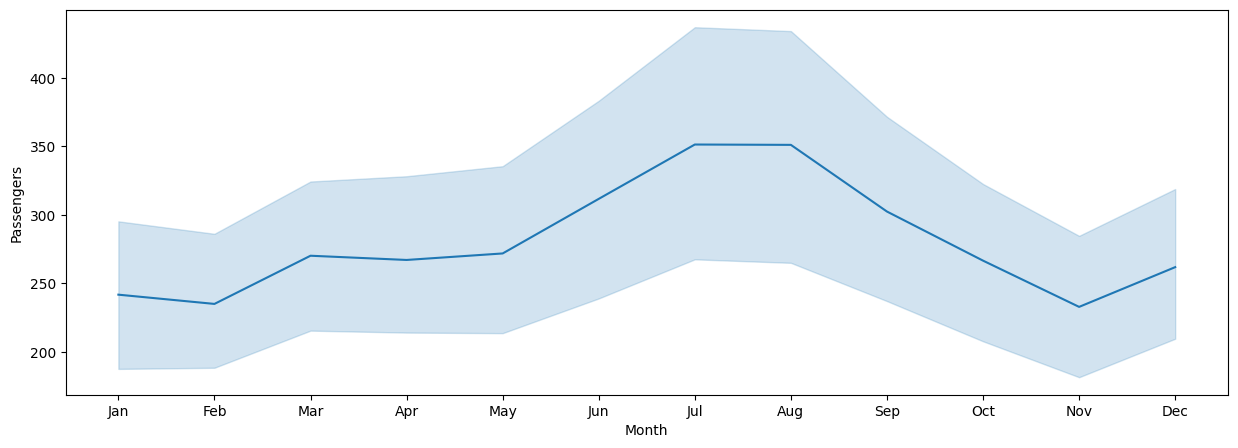

In [ ]:
plt.figure(figsize=(15, 5));
sns.lineplot(data=new_df, x='Month', y='Passengers');

* We can see that <b>July</b> and <b>August</b> have the highest numbers of passengers, while <b>February</b> and <b>November</b> have the lowest number of passengers.

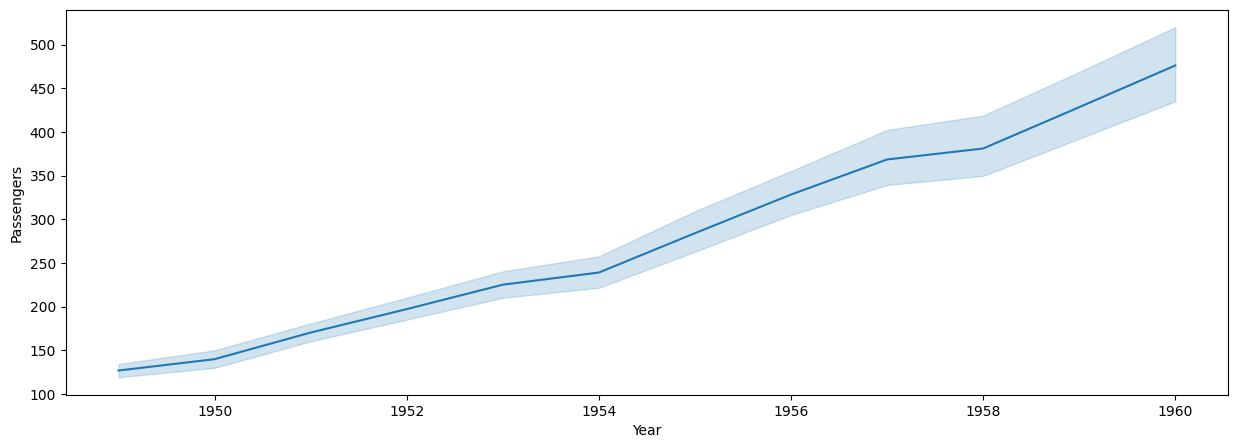

In [ ]:
plt.figure(figsize=(15, 5));
sns.lineplot(data=new_df, x='Year', y='Passengers');

* As on the level of the years, the number of passengers is <b>increasing</b> monotonically. 

# 2. Models Evaluation

## 2.1. Evaluation Metric (RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
def evaluate_model(actual_y, predicted_y, model):
  error = np.sqrt(mean_squared_error(actual_y, predicted_y))
  print(f"RMSE for {model} is {error}")
  return error

## 2.2. Evaluation Approaches

#### 2.2.1. Simple Train-Test split


In [ ]:
def data_split(percentage, data):
  train_size = int(data.shape[0] * percentage)
  train_df, test_df = data.iloc[:train_size,:], data.iloc[train_size:,:]
  return train_df, test_df

#### 2.2.2. Time Series Cross Validation 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def k_folds(data, n_splits = 5):
  tscv = TimeSeriesSplit(n_splits)
  for i, (train_index, test_index) in enumerate(tscv.split(data)):
      train = data.iloc[train_index]
      test = data.iloc[test_index]
      yield train, test

#### 2.2.3. Roll Forward Approach 

In [ ]:
def roll_forward(air_passengers, window_size = 30, split_percent = 0.8):
  m = len(air_passengers)
  for k in range(0, m, window_size):
    df = air_passengers.iloc[k : k+window_size]
    train_df, test_df = data_split(split_percent, df)
    yield train_df, test_df

# Now let's start forcasting using different techniques

## 1. Simple Moving Average Smoothing

### Split the Data

In [ ]:
my_df = df.copy()
my_df['Month'] = pd.to_datetime(my_df['Month'])

In [ ]:
split_percent = 0.7
train_df, test_df = data_split(split_percent, my_df)

Text(0.5, 1.0, 'Monthly number of passengers')

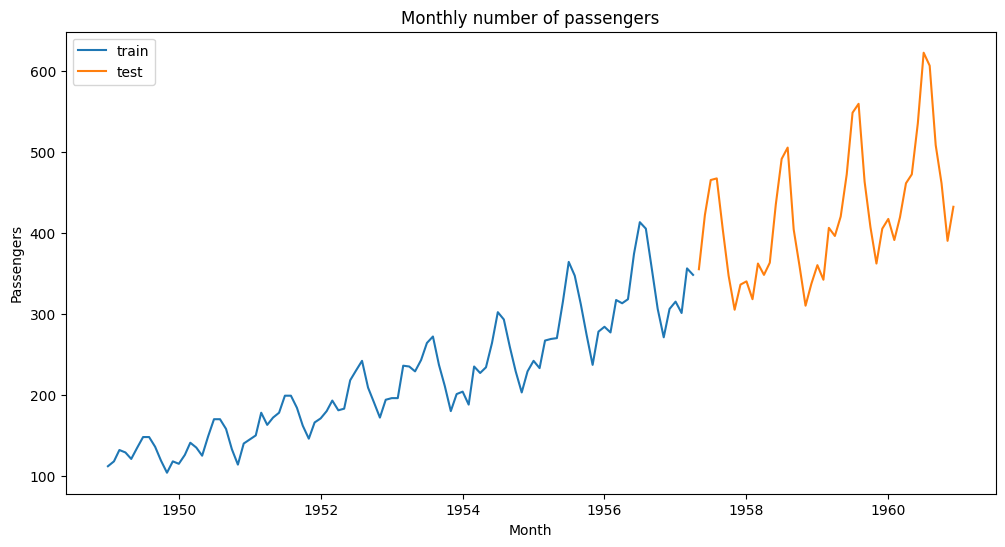

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_df.Month, train_df.Passengers)
plt.plot(test_df.Month, test_df.Passengers)
plt.legend(['train', 'test'])
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Monthly number of passengers')

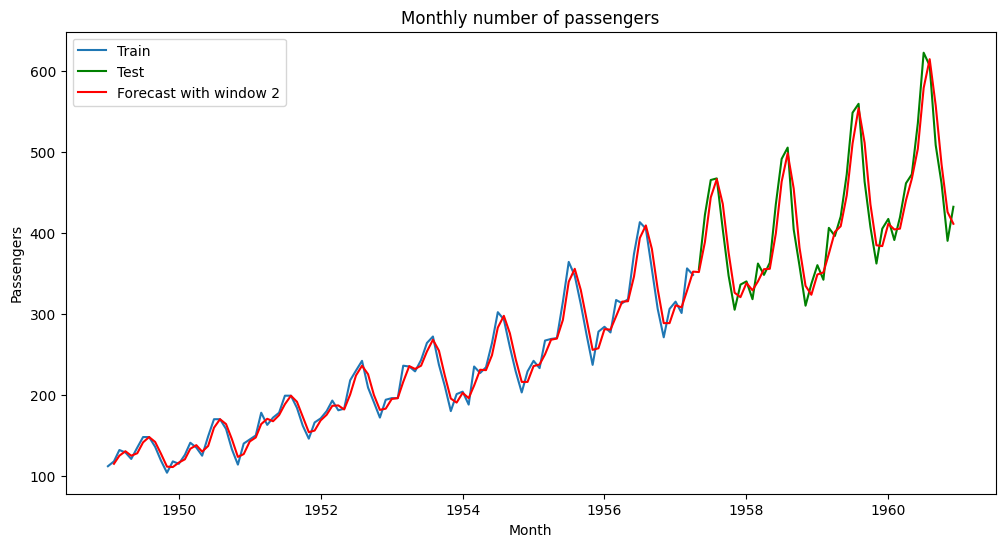

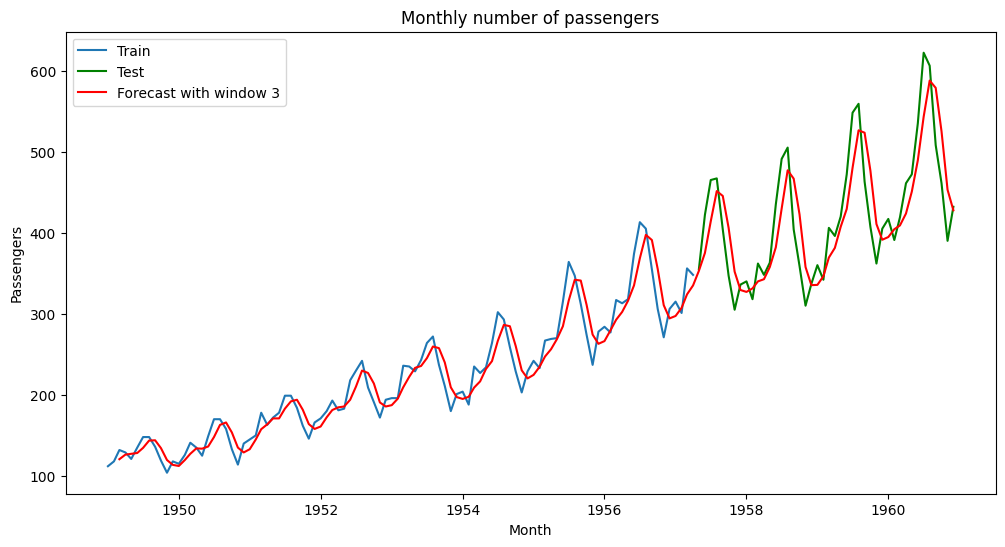

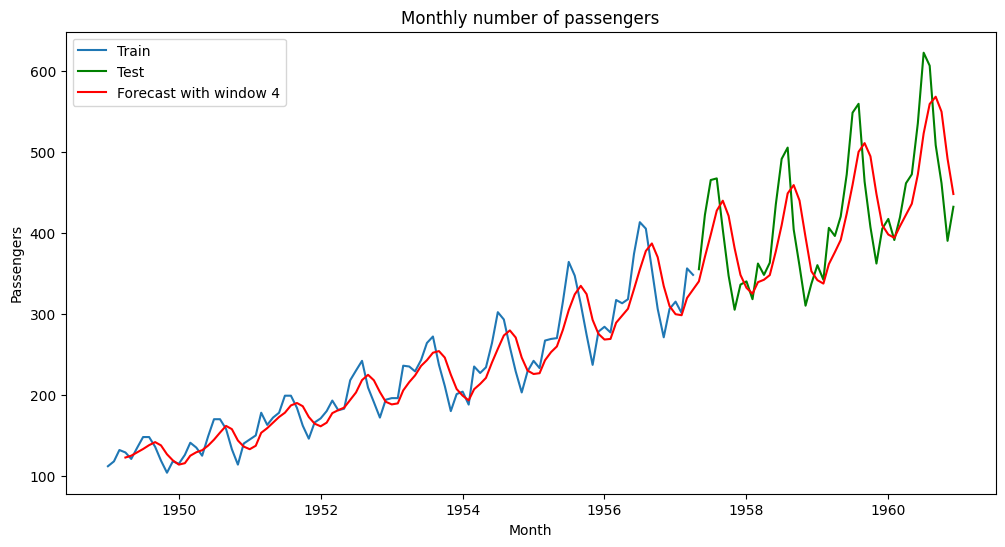

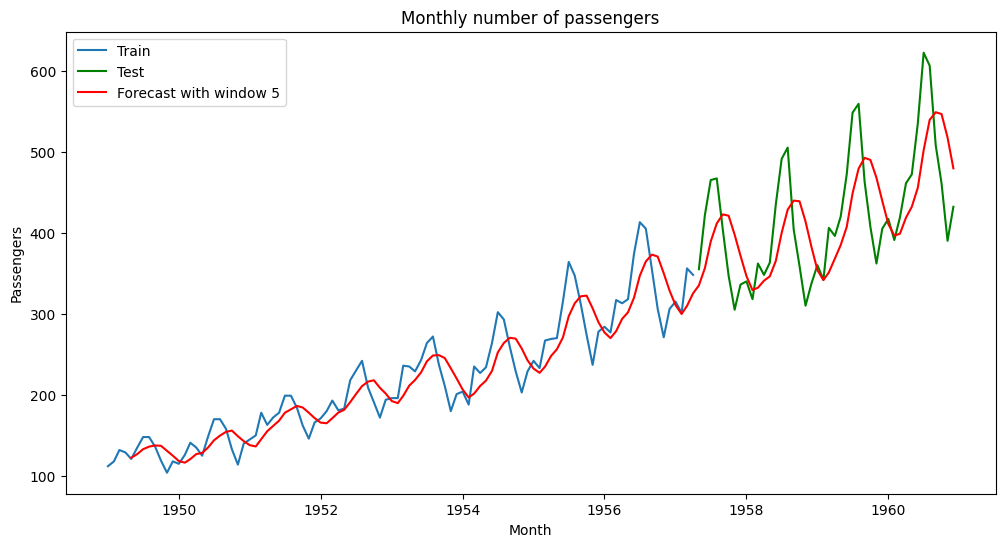

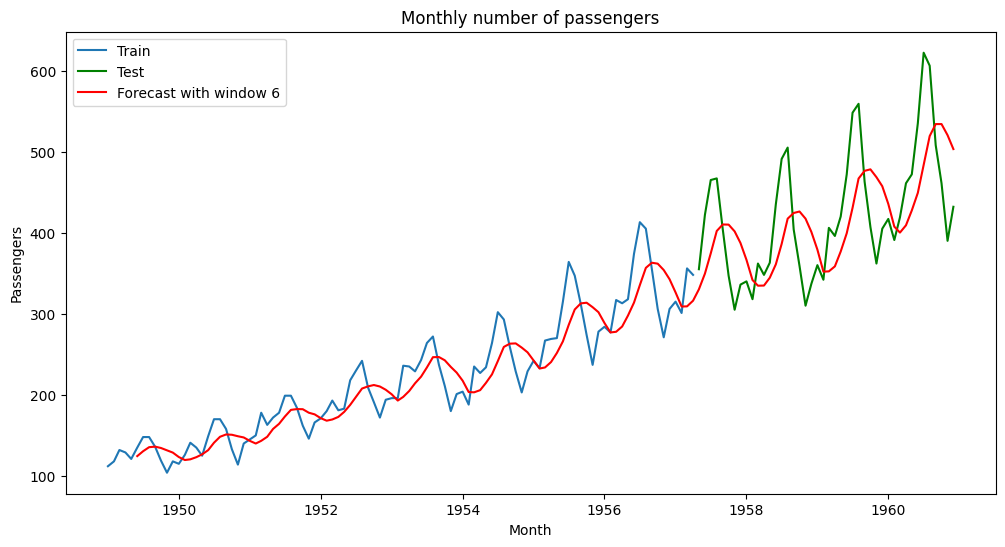

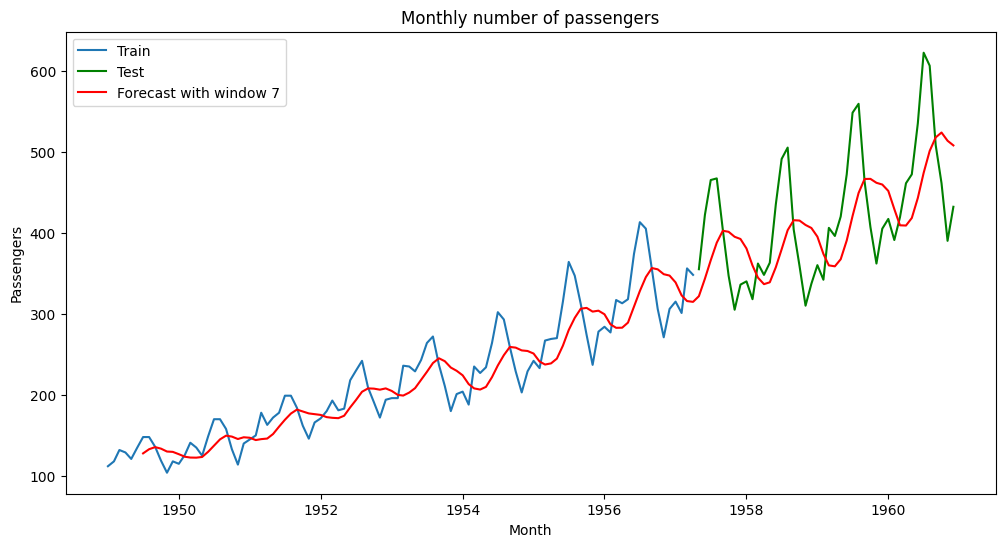

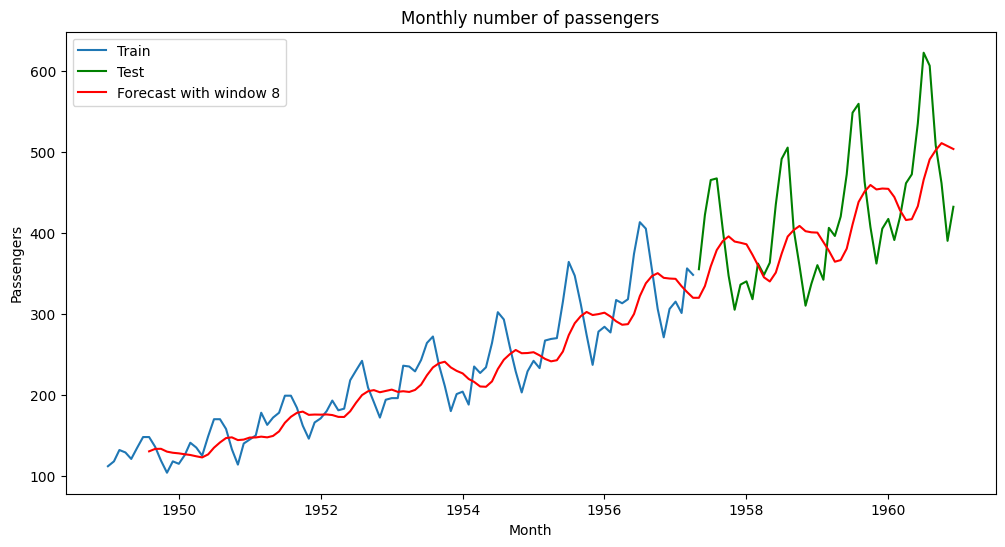

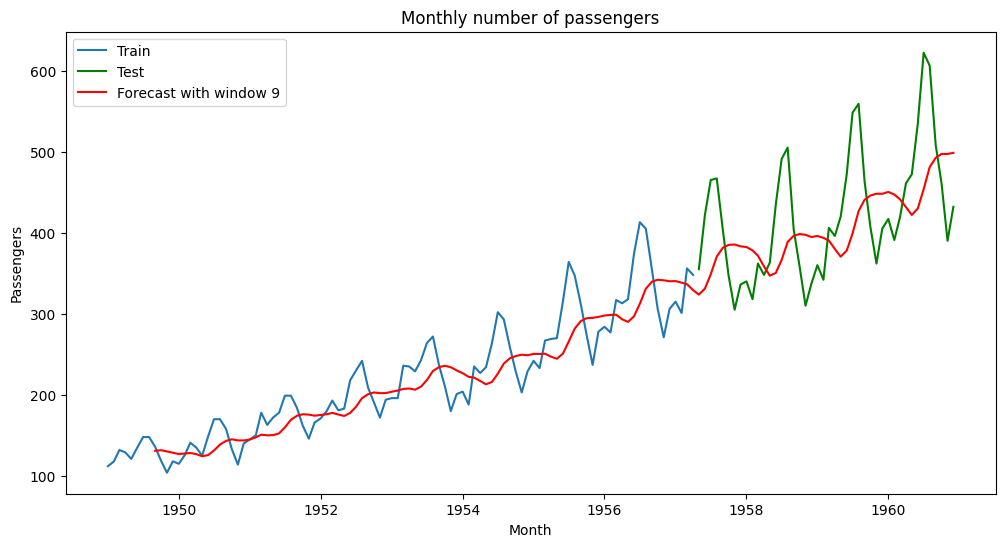

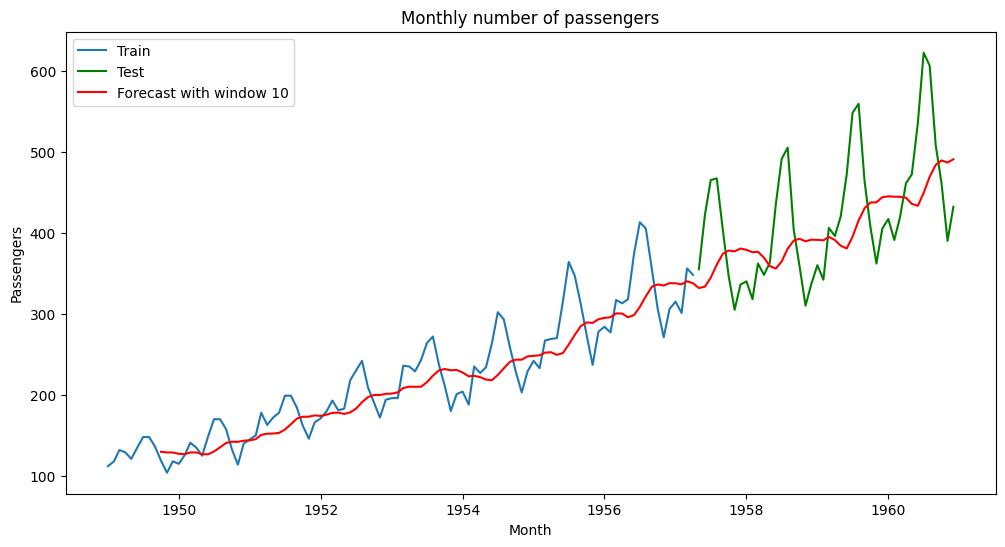

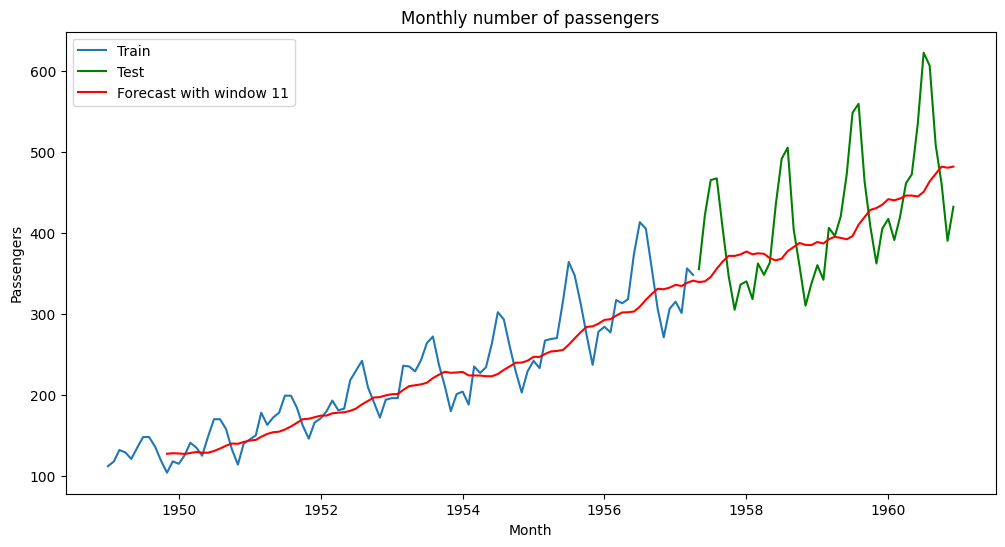

In [ ]:
# Window size is the average of the last n observations
window_size = np.arange(2,12)

# Let's try differernt window sizes
for w in window_size: 
    my_df['rolled_mean'] = my_df.Passengers.rolling(w).mean()
    # ma_rmse = evaluate_model(my_df.Passengers, my_df.rolled_mean, 'Moving Average')
    plt.figure(figsize=(12,6))
    plt.plot(train_df.Month, train_df.Passengers, label='Train')
    plt.plot(test_df.Month, test_df.Passengers, label='Test', color='green')
    plt.plot(my_df.Month, my_df.rolled_mean, label=f'Forecast with window {w}', color='red')
    plt.xlabel('Month')
    plt.ylabel('Passengers')
    plt.legend()
    plt.title('Monthly number of passengers')
plt.show()

<b>We tried different window sizes, and we noticed that:</b>
* The larger the window size, the more data we <b>lose</b> from the beginning and the end of our timeseries data
* The window size determines the smoothness of the trend-cycle estimate.
* MA technique uses the past series values to forecast. 
</br>

<b>MA disadvantages are:</b>
* Each historical value is given the same weight.
* It's hard to determine the window size (no. of periods used).
* Moreover, each n periods must be stored in the system.

## 2. Naïve Forecasting

### 2.1 Splitting method 1/3: simple train test split

In [ ]:
train, test = data_split(.8, new_df)

The Naïve Forecasting is a method of predicting future data based on the last seen data, in this example we use the last value for the train to predict the future of the values following it.

In [ ]:
test['Predictions'] = train['Passengers'][train.index[-1]]
test

<ipython-input-71-4d995f5704b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


Date  Passengers Month  Year  Predictions
115 1958-08-01         505   Aug  1958          491
116 1958-09-01         404   Sep  1958          491
117 1958-10-01         359   Oct  1958          491
118 1958-11-01         310   Nov  1958          491
119 1958-12-01         337   Dec  1958          491
120 1959-01-01         360   Jan  1959          491
121 1959-02-01         342   Feb  1959          491
122 1959-03-01         406   Mar  1959          491
123 1959-04-01         396   Apr  1959          491
124 1959-05-01         420   May  1959          491
125 1959-06-01         472   Jun  1959          491
126 1959-07-01         548   Jul  1959          491
127 1959-08-01         559   Aug  1959          491
128 1959-09-01         463   Sep  1959          491
129 1959-10-01         407   Oct  1959          491
130 1959-11-01         362   Nov  1959          491
131 1959-12-01         405   Dec  1959          491
132 1960-01-01         417   Jan  1960          491
133 1960-02-01         391   Feb  1960          491
134 1960-03-01         419   Mar  1960          491
135 1960-04-01         461   Apr  1960          491
136 1960-05-01         472   May  1960          491
137 1960-06-01         535   Jun  1960          491
138 1960-07-01         622   Jul  1960          491
139 1960-08-01         606   Aug  1960          491
140 1960-09-01         508   Sep  1960          491
141 1960-10-01         461   Oct  1960          491
142 1960-11-01         390   Nov  1960          491
143 1960-12-01         432   Dec  1960          491

In [ ]:
evaluate_model(test['Passengers'], test['Predictions'], "Naïve Forecasting");

RMSE for Naïve Forecasting is 93.13394136662937


It doesn't do as good as the previous model as this data is seasonal

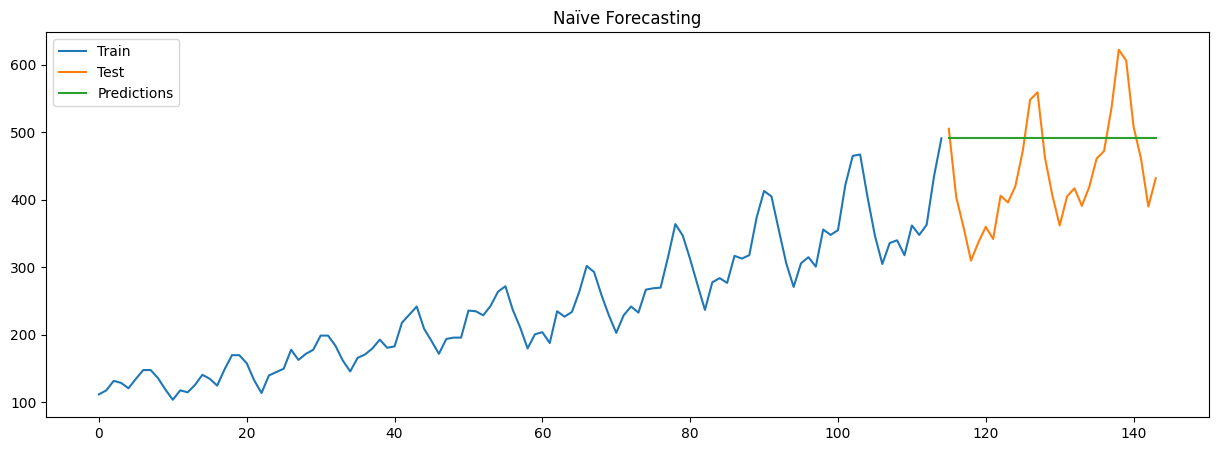

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.title('Naïve Forecasting')
plt.show()

Notice how it almost performed good in the following month but then wasn't reliable for the data after it. So it's not a very good approach when predicting for the far future.

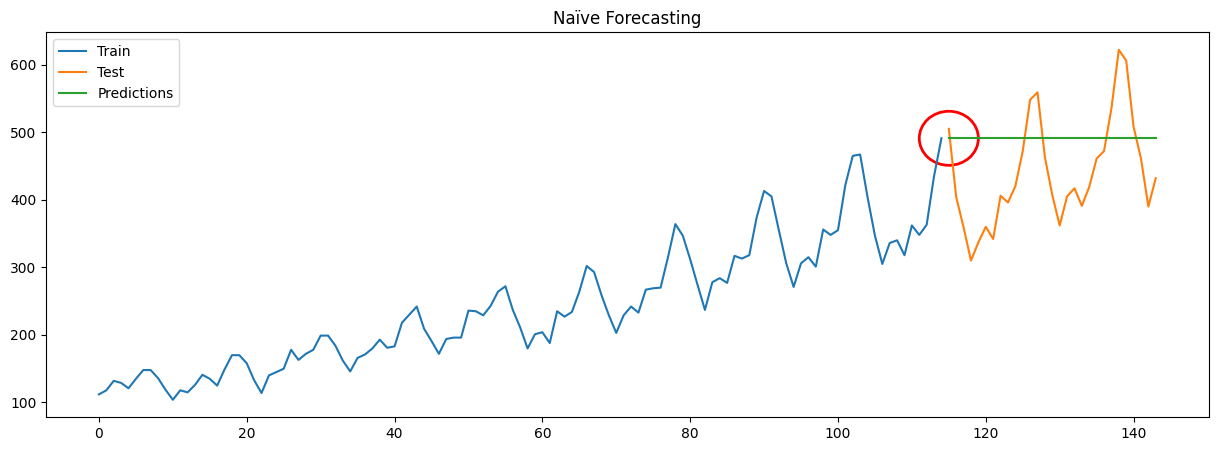

In [ ]:
from matplotlib.patches import Ellipse

plt.figure(figsize=(15, 5))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.title('Naïve Forecasting')

circle1 = Ellipse(xy=(test.index[0], test['Predictions'].iloc[0]), width=8, height=80, edgecolor='r', fc='None', lw=2)
plt.gca().add_patch(circle1)

plt.show()

### 2.2 Splitting method 2/3: k folds

<ipython-input-76-19e8d245a3f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 49.77030573879704


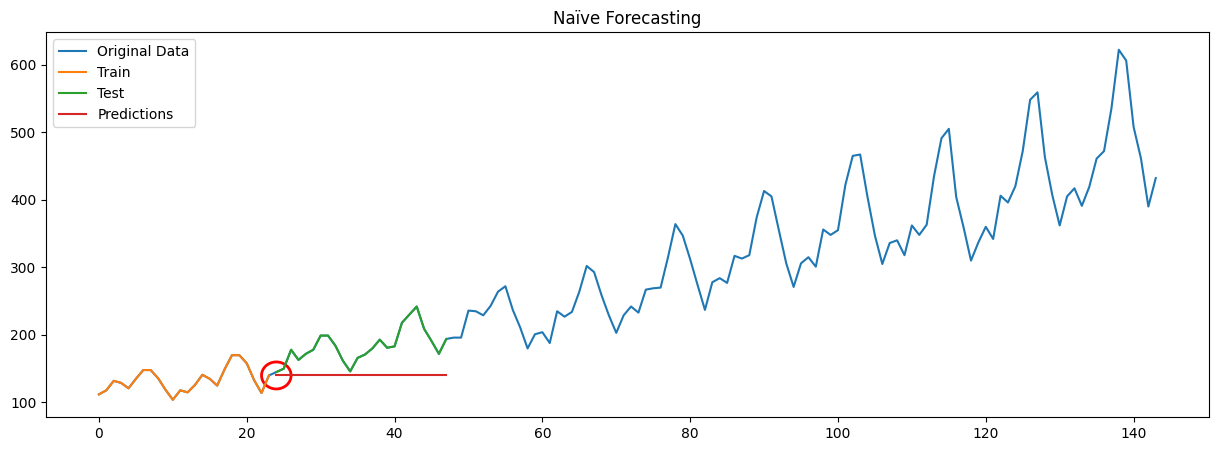

<ipython-input-76-19e8d245a3f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 49.190530931606474


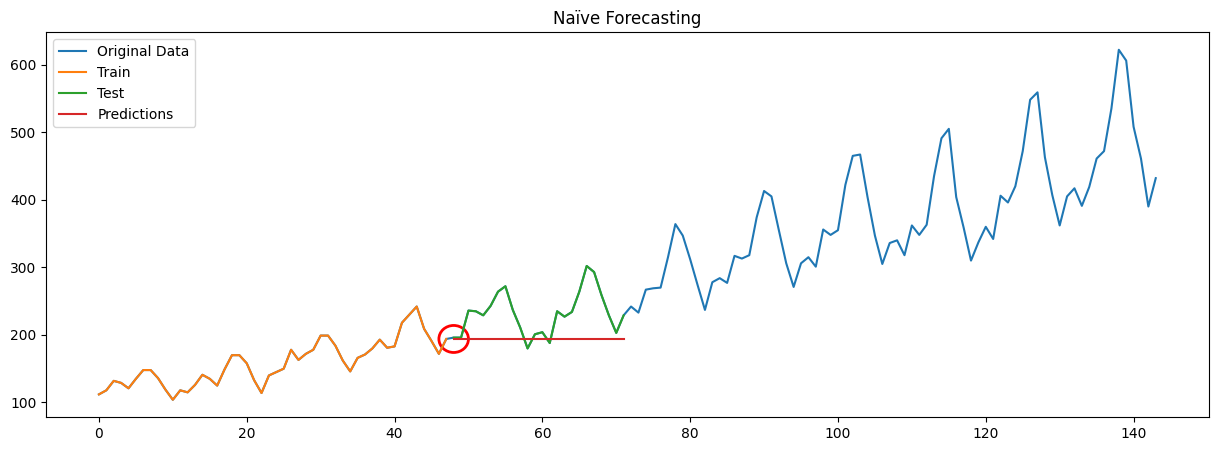

<ipython-input-76-19e8d245a3f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 91.11325370109444


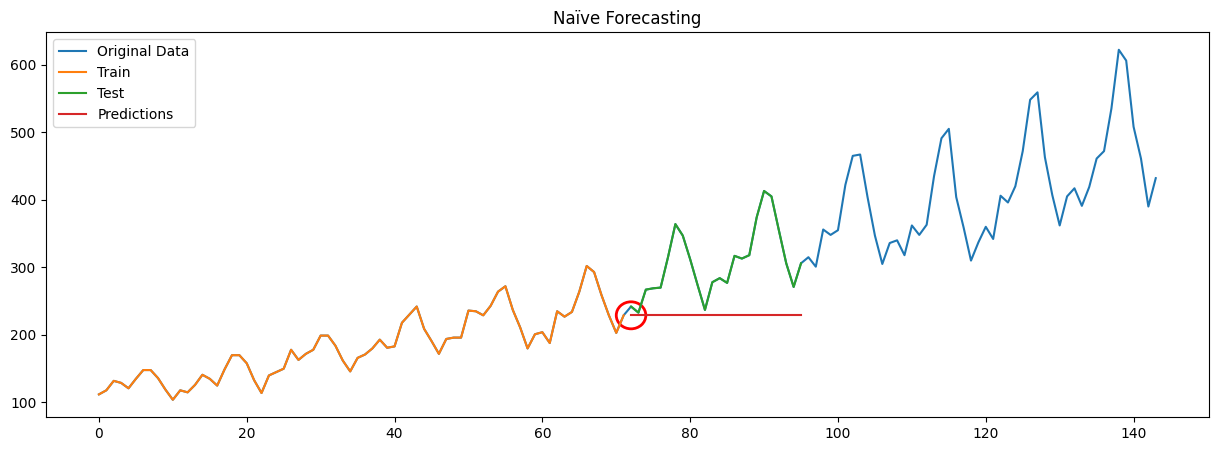

<ipython-input-76-19e8d245a3f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 90.58168505093437


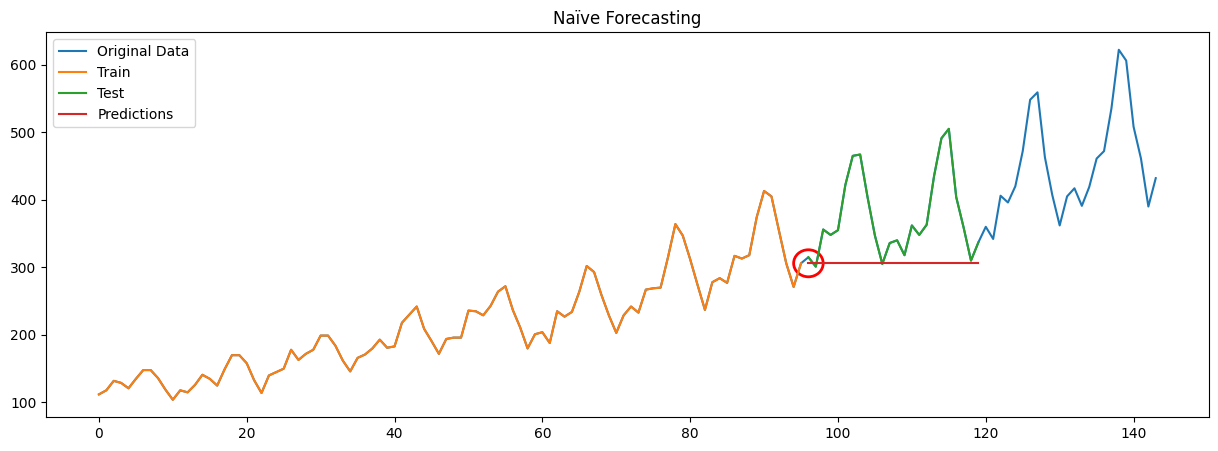

<ipython-input-76-19e8d245a3f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 137.32898455897794


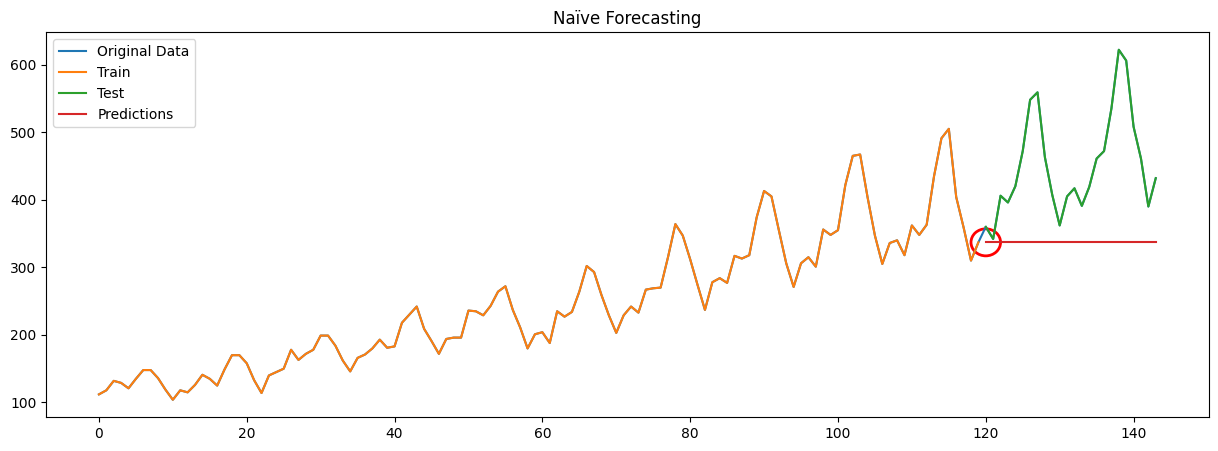

In [ ]:
errors = []
for train, test in k_folds(new_df):
    test['Predictions'] = train['Passengers'][train.index[-1]]
    e = evaluate_model(test['Passengers'], test['Predictions'], "Naïve Forecasting")
    errors.append(e)
    plt.figure(figsize=(15, 5))
    plt.plot(new_df['Passengers'], label='Original Data')
    plt.plot(train['Passengers'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title('Naïve Forecasting')

    circle1 = Ellipse(xy=(test.index[0], test['Predictions'].iloc[0]), width=4, height=40, edgecolor='r', fc='None', lw=2)
    plt.gca().add_patch(circle1)

    plt.show()

In [ ]:
print("Naïve Forecasting Error: ", sum(errors)/len(errors))

Naïve Forecasting Error:  83.59695199628206


### 2.3 Splitting method 3/3: roll forward

<ipython-input-78-b59937e1ea05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 27.586228448267445


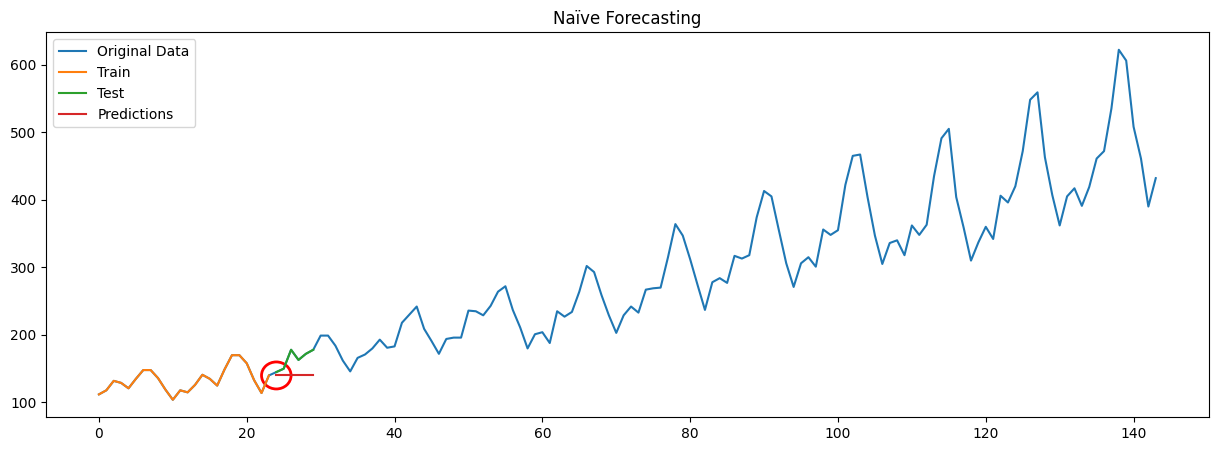

<ipython-input-78-b59937e1ea05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 36.68560117175856


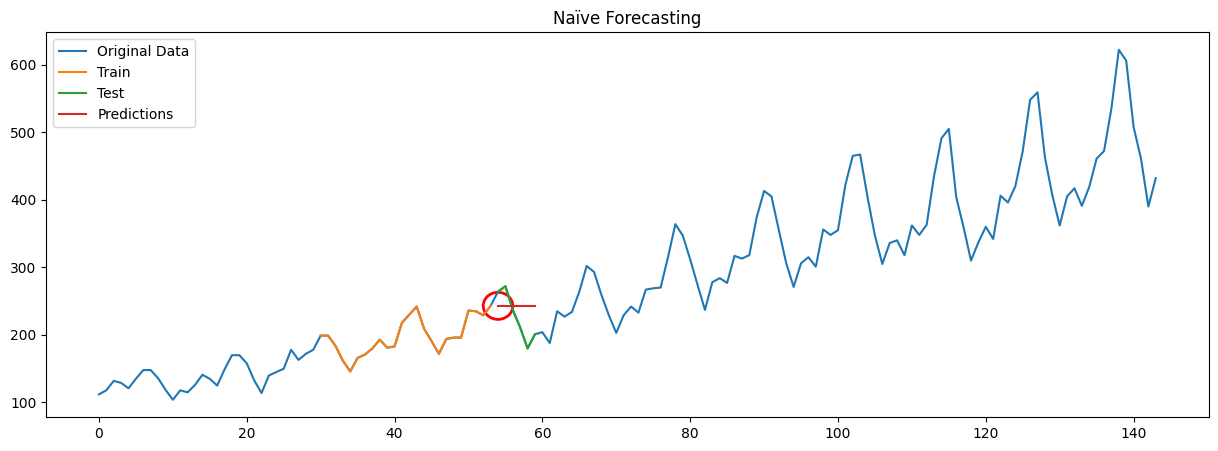

<ipython-input-78-b59937e1ea05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 47.60777247467056


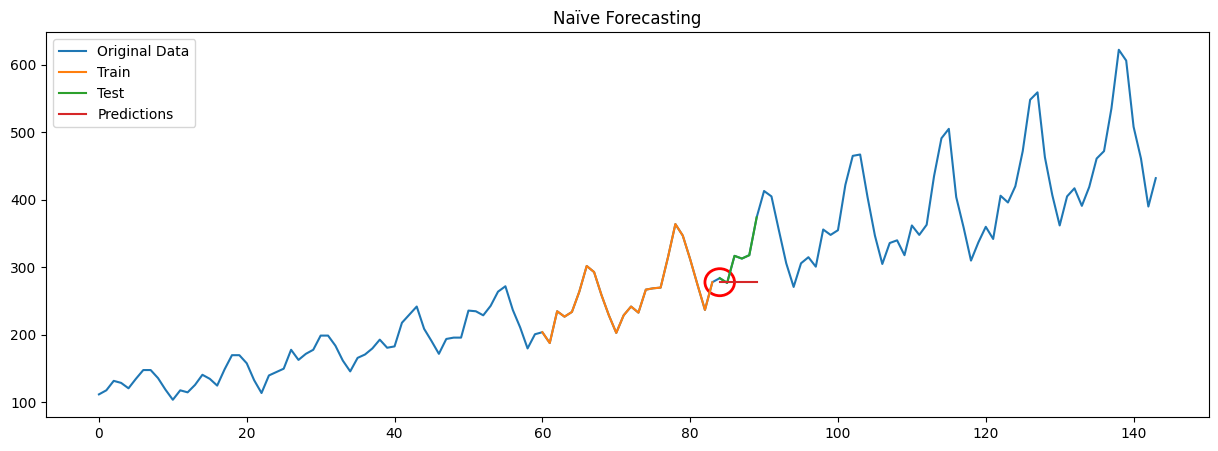

<ipython-input-78-b59937e1ea05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train['Passengers'][train.index[-1]]


RMSE for Naïve Forecasting is 81.65169930871004


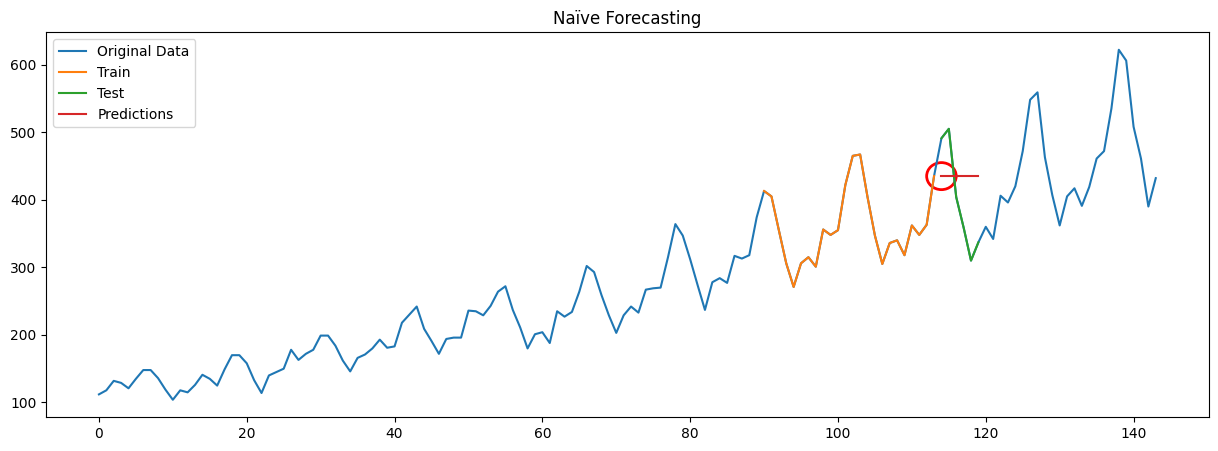

In [ ]:
errors = []
for train, test in roll_forward(new_df):
    if len(train) >= 24:
        test['Predictions'] = train['Passengers'][train.index[-1]]
        e = evaluate_model(test['Passengers'], test['Predictions'], "Naïve Forecasting")
        errors.append(e)
        plt.figure(figsize=(15, 5))
        plt.plot(new_df['Passengers'], label='Original Data')
        plt.plot(train['Passengers'], label='Train')
        plt.plot(test['Passengers'], label='Test')
        plt.plot(test['Predictions'], label='Predictions')
        plt.legend()
        plt.title('Naïve Forecasting')

        circle1 = Ellipse(xy=(test.index[0], test['Predictions'].iloc[0]), width=4, height=40, edgecolor='r', fc='None', lw=2)
        plt.gca().add_patch(circle1)

        plt.show()

In [ ]:
print("Naïve Forecasting Error: ", sum(errors)/len(errors))

Naïve Forecasting Error:  48.38282535085165


## 3. Weight Moving Average
"using any weights you find make sense based on your data understanding"

First Weight choosing

### 3.0 Choosing the weights

In [ ]:
def wma(weights):
    def calc(x):
        return (weights*x).sum()
    return calc

In [ ]:
train, test = data_split(.8, new_df)

In [ ]:
weights = np.array([0.5, .3, .2])
train['wma_roll3'] = train['Passengers'].rolling(window=3).apply(wma(weights)).shift(1)
weights = np.array([0.06,0.06,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.03,0.03,.55])
train['wma_roll12a'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
weights = np.array([0.5,0,0,0,0,0,0,0,0,0,0,.5])
train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
weights = np.array([0,0,0,0,0,0,0,0,0,0,0,1])
train['wma_roll12c'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
weights = np.array([1,0,0,0,0,0,0,0,0,0,0,0])
train['wma_roll12d'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
train

<ipython-input-113-5c47d021e756>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll3'] = train['Passengers'].rolling(window=3).apply(wma(weights)).shift(1)
<ipython-input-113-5c47d021e756>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12a'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-113-5c47d021e756>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Date  Passengers Month  Year  wma_roll3  wma_roll12a  wma_roll12b  \
0   1949-01-01         112   Jan  1949        NaN          NaN          NaN   
1   1949-02-01         118   Feb  1949        NaN          NaN          NaN   
2   1949-03-01         132   Mar  1949        NaN          NaN          NaN   
3   1949-04-01         129   Apr  1949      117.8          NaN          NaN   
4   1949-05-01         121   May  1949      124.4          NaN          NaN   
..         ...         ...   ...   ...        ...          ...          ...   
110 1958-03-01         362   Mar  1958      333.6       349.27        337.0   
111 1958-04-01         348   Apr  1958      337.8       373.32        355.0   
112 1958-05-01         363   May  1958      337.2       367.54        351.5   
113 1958-06-01         435   Jun  1958      358.0       376.98        392.5   
114 1958-07-01         491   Jul  1958      369.9       413.69        450.0   

     wma_roll12c  wma_roll12d  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN          NaN  
4            NaN          NaN  
..           ...          ...  
110        318.0        356.0  
111        362.0        348.0  
112        348.0        355.0  
113        363.0        422.0  
114        435.0        465.0  

[115 rows x 9 columns]

<Axes: >

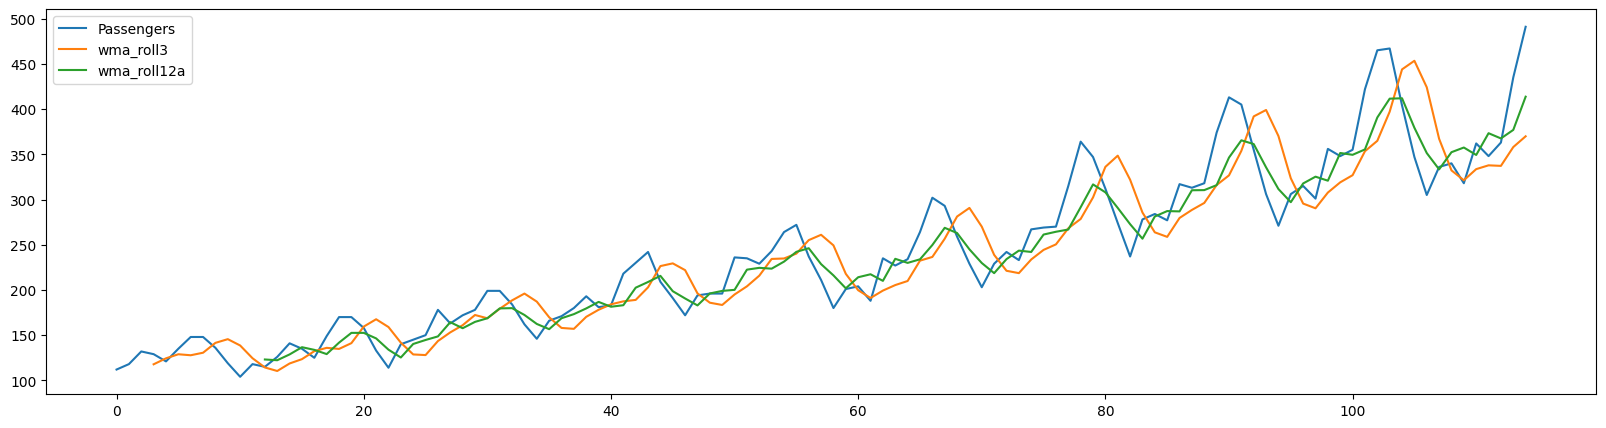

In [ ]:
train[['Passengers', 'wma_roll3', 'wma_roll12a']].plot(figsize=(20, 5))

<Axes: >

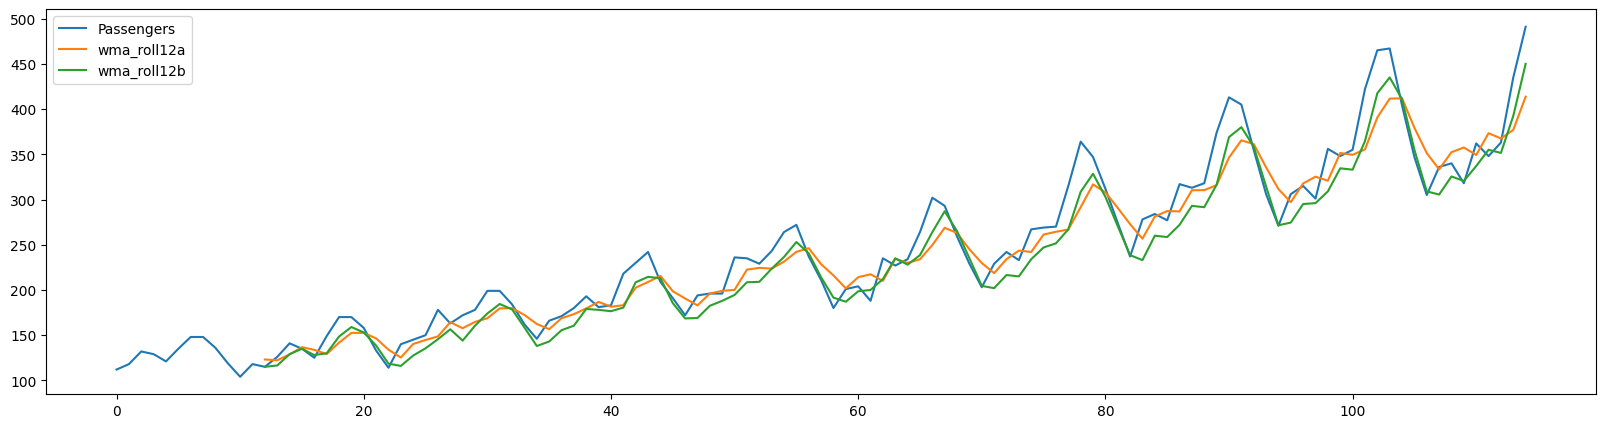

In [ ]:
train[['Passengers', 'wma_roll12a', 'wma_roll12b']].plot(figsize=(20, 5))

<Axes: >

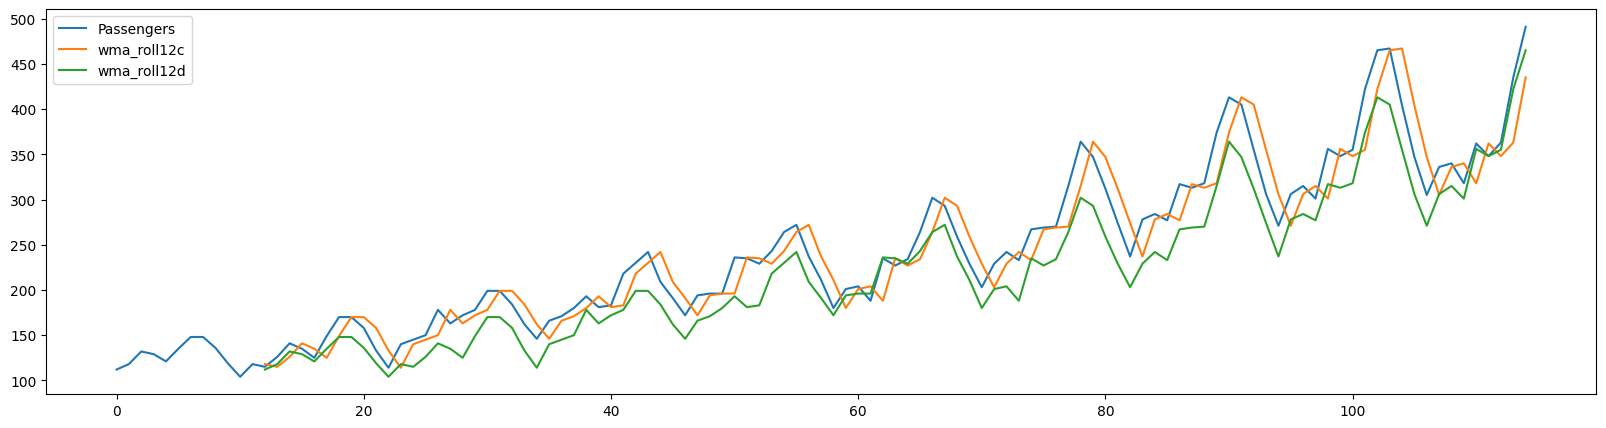

In [ ]:
train[['Passengers', 'wma_roll12c', 'wma_roll12d']].plot(figsize=(20, 5))

In [ ]:
evaluate_model(train['Passengers'].iloc[-12:], train['wma_roll12a'].iloc[-12:], "Rolling 12 A")
evaluate_model(train['Passengers'].iloc[-12:], train['wma_roll12b'].iloc[-12:], "Rolling 12 B")

RMSE for Rolling 12 A is 38.96972232815283
RMSE for Rolling 12 B is 23.440083190978655


23.440083190978655

In [ ]:
weights = np.array([0.5,0,0,0,0,0,0,0,0,0,0,.5])
train_test_combined =  train.append(test)
for i in range(test.index[0], test.index[-1]+1):
    train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()
test['Predictions'] = train_test_combined['wma_roll12b']
test

<ipython-input-118-30ac42f28fe8>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-118-30ac42f28fe8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()
<ipython-input-118-30ac42f28fe8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train_test_combined['wma_roll12b']


Date  Passengers Month  Year  Predictions
115 1958-08-01         505   Aug  1958   442.500000
116 1958-09-01         404   Sep  1958   426.750000
117 1958-10-01         359   Oct  1958   390.875000
118 1958-11-01         310   Nov  1958   349.937500
119 1958-12-01         337   Dec  1958   327.718750
120 1959-01-01         360   Jan  1959   326.609375
121 1959-02-01         342   Feb  1959   323.554688
122 1959-03-01         406   Mar  1959   330.277344
123 1959-04-01         396   Apr  1959   342.638672
124 1959-05-01         420   May  1959   347.069336
125 1959-06-01         472   Jun  1959   369.784668
126 1959-07-01         548   Jul  1959   409.892334
127 1959-08-01         559   Aug  1959   426.196167
128 1959-09-01         463   Sep  1959   426.473083
129 1959-10-01         407   Oct  1959   408.674042
130 1959-11-01         362   Nov  1959   379.305771
131 1959-12-01         405   Dec  1959   353.512260
132 1960-01-01         417   Jan  1960   340.060818
133 1960-02-01         391   Feb  1960   331.807753
134 1960-03-01         419   Mar  1960   331.042548
135 1960-04-01         461   Apr  1960   336.840610
136 1960-05-01         472   May  1960   341.954973
137 1960-06-01         535   Jun  1960   355.869820
138 1960-07-01         622   Jul  1960   382.881077
139 1960-08-01         606   Aug  1960   404.538622
140 1960-09-01         508   Sep  1960   415.505853
141 1960-10-01         461   Oct  1960   412.089947
142 1960-11-01         390   Nov  1960   395.697859
143 1960-12-01         432   Dec  1960   374.605060

In [ ]:
evaluate_model(test['Passengers'], test['Predictions'], "Weight Moving Average")

RMSE for Weight Moving Average is 96.04879047122597


96.04879047122597

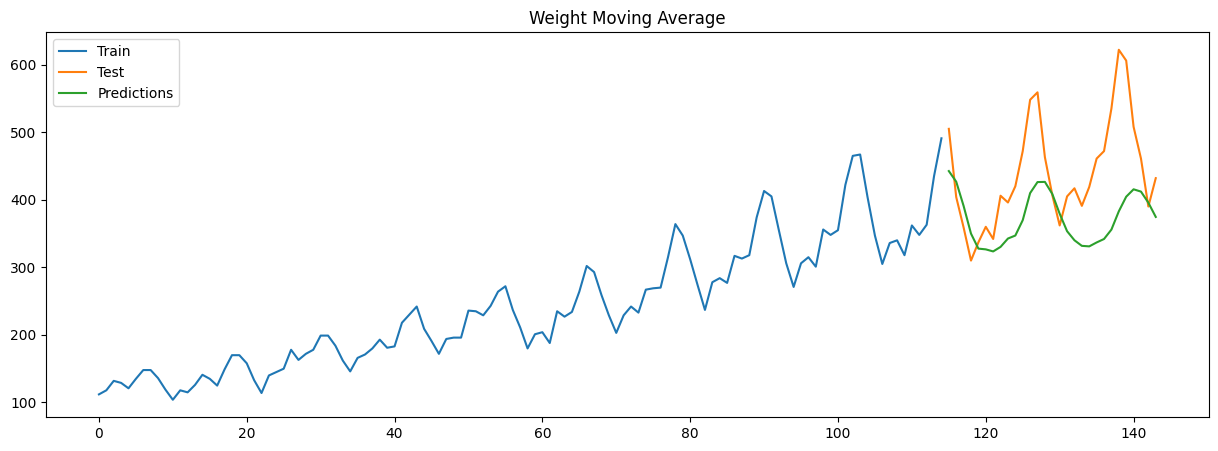

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.title('Weight Moving Average')
plt.show()

<ipython-input-121-c7d7b817d562>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-121-c7d7b817d562>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined[wma_type][i] = (train_test_combined[wma_type][i-weights.shape[0]:i] * weights).sum()
<ipython-input-121-c7d7b817d562>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train_test_combined[wma_type]


RMSE for Weight Moving Average wma_roll3 is 113.34480525997164


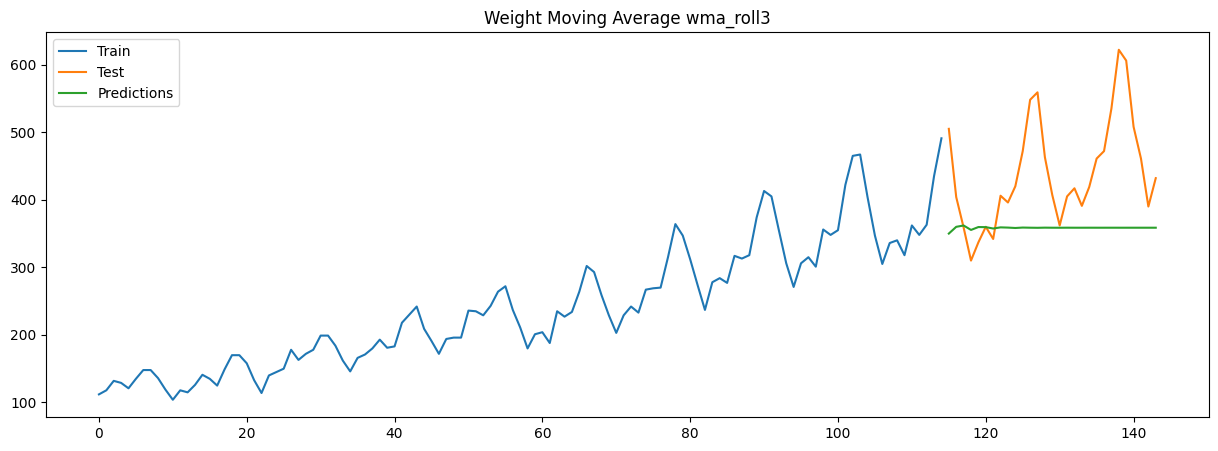

<ipython-input-121-c7d7b817d562>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined[wma_type][i] = (train_test_combined[wma_type][i-weights.shape[0]:i] * weights).sum()
<ipython-input-121-c7d7b817d562>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train_test_combined[wma_type]


RMSE for Weight Moving Average wma_roll12a is 86.16319240096497


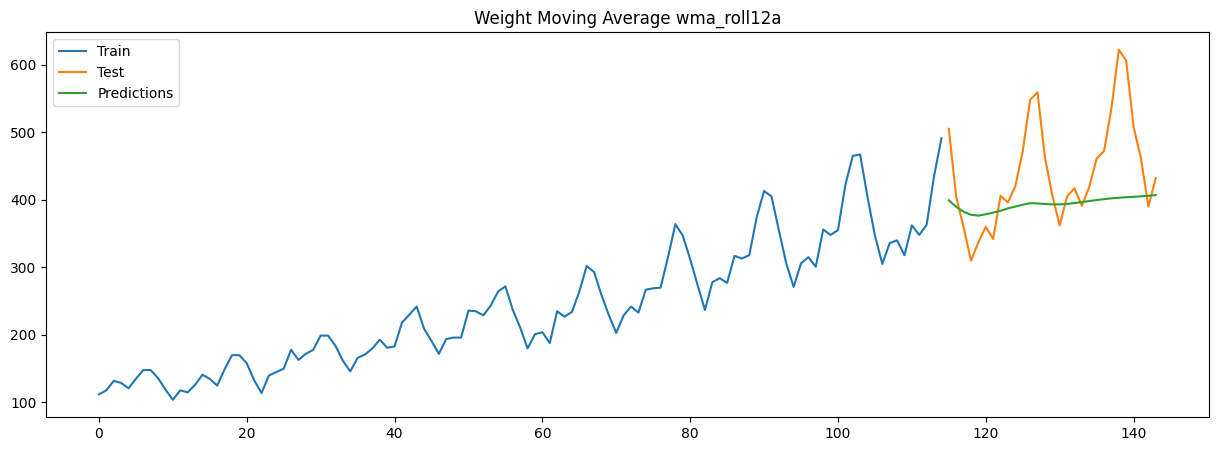

<ipython-input-121-c7d7b817d562>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined[wma_type][i] = (train_test_combined[wma_type][i-weights.shape[0]:i] * weights).sum()
<ipython-input-121-c7d7b817d562>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train_test_combined[wma_type]


RMSE for Weight Moving Average wma_roll12b is 96.04879047122597


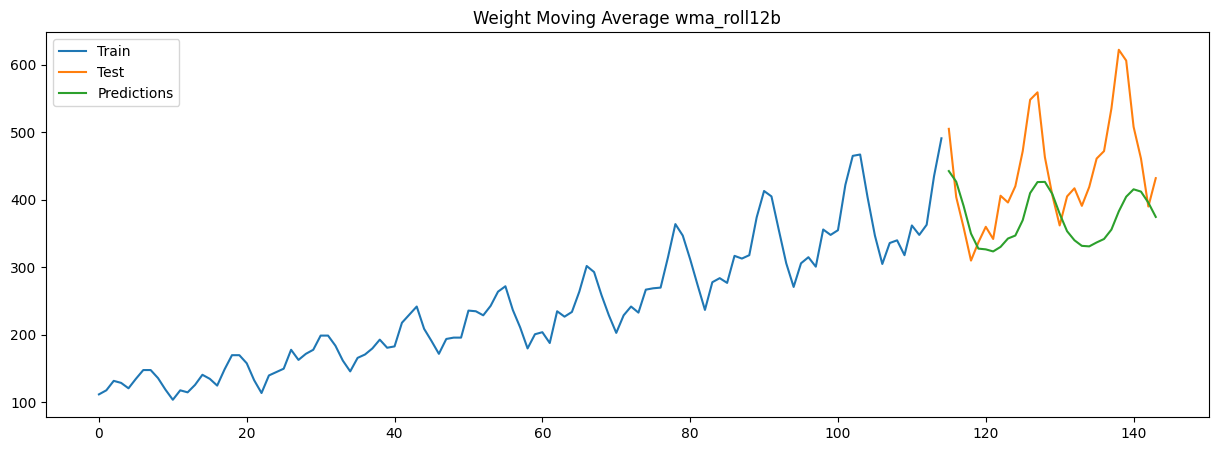

<ipython-input-121-c7d7b817d562>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined[wma_type][i] = (train_test_combined[wma_type][i-weights.shape[0]:i] * weights).sum()
<ipython-input-121-c7d7b817d562>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train_test_combined[wma_type]


RMSE for Weight Moving Average wma_roll12c is 78.31149120769196


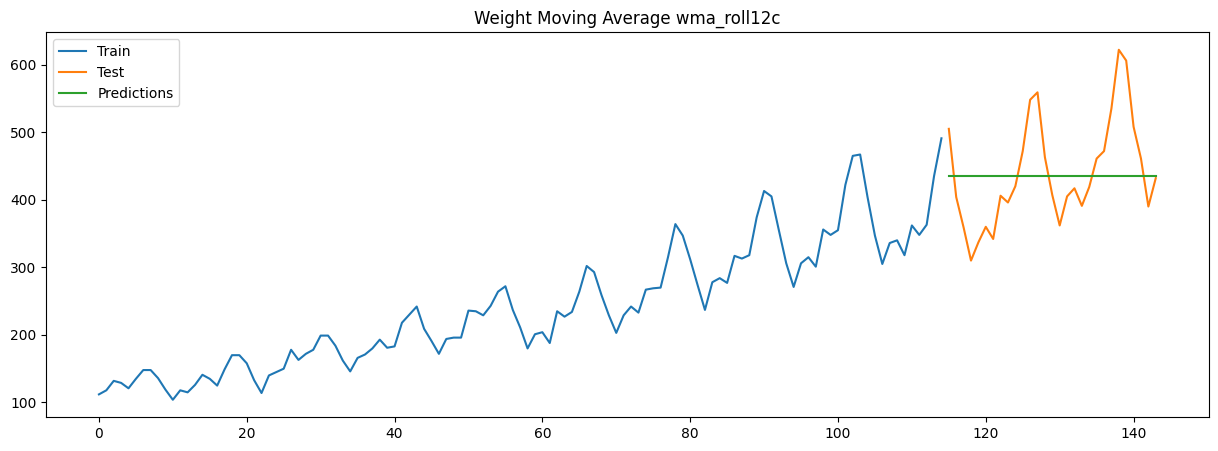

<ipython-input-121-c7d7b817d562>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined[wma_type][i] = (train_test_combined[wma_type][i-weights.shape[0]:i] * weights).sum()
<ipython-input-121-c7d7b817d562>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = train_test_combined[wma_type]


RMSE for Weight Moving Average wma_roll12d is 103.00652808238033


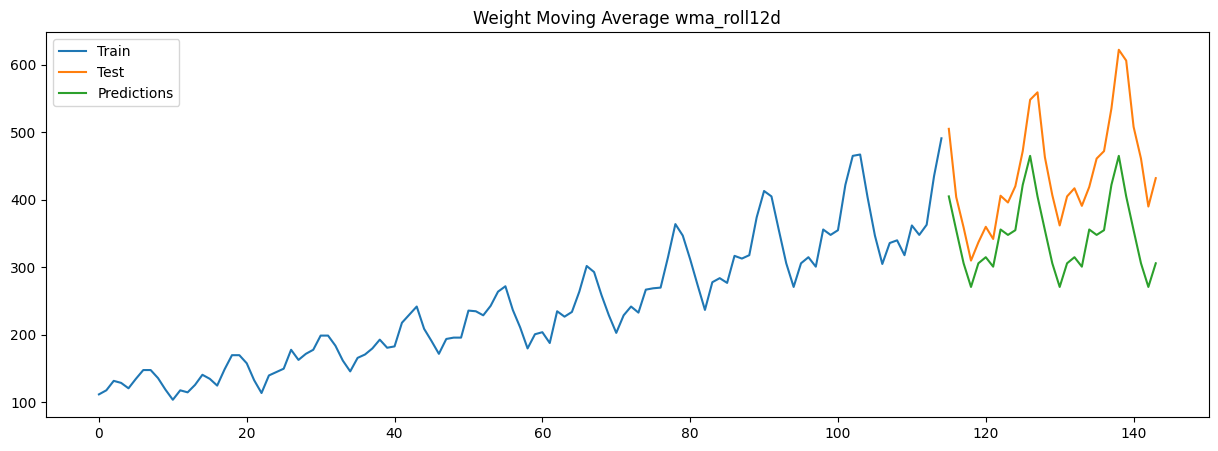

In [ ]:
train_test_combined =  train.append(test)
trials = {
    'wma_roll3': np.array([0.5, .3, .2]),
    'wma_roll12a': np.array([0.06,0.06,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.03,0.03,.55]),
    'wma_roll12b': np.array([0.5,0,0,0,0,0,0,0,0,0,0,.5]),
    'wma_roll12c': np.array([0,0,0,0,0,0,0,0,0,0,0,1]),
    'wma_roll12d': np.array([1,0,0,0,0,0,0,0,0,0,0,0])
}
for wma_type, weights in trials.items():
    for i in range(test.index[0], test.index[-1]+1):
        train_test_combined[wma_type][i] = (train_test_combined[wma_type][i-weights.shape[0]:i] * weights).sum()
    test['Predictions'] = train_test_combined[wma_type]
    evaluate_model(test['Passengers'], test['Predictions'], f"Weight Moving Average {wma_type}")
    plt.figure(figsize=(15, 5))
    plt.plot(train['Passengers'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title(f'Weight Moving Average {wma_type}')
    plt.show()

* Notice how roll 12 c is a Naïve Forecasting because it only gives weight to the previous period.

* roll 12 d is naive but it replicates the previoud year as a whole so it kinda captures seasonality (replicating only last year) but ignores any tread appearing in the data.

* roll 12 b is the most logical one as it relies on the previous values as well as the last year's value thus it makes a slight smoothing on the data

* roll 12 a does extreme smothing then stablizes

* roll 3 same but it stablizes a lot early as it relies on only 3 previous values

Thus I'll go with roll 12 b

### 3.1 Splitting method 1/3: simple train test split

<ipython-input-122-8391c5a43135>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-122-8391c5a43135>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-122-8391c5a43135>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()


RMSE for Weight Moving Average is 96.04879047122597


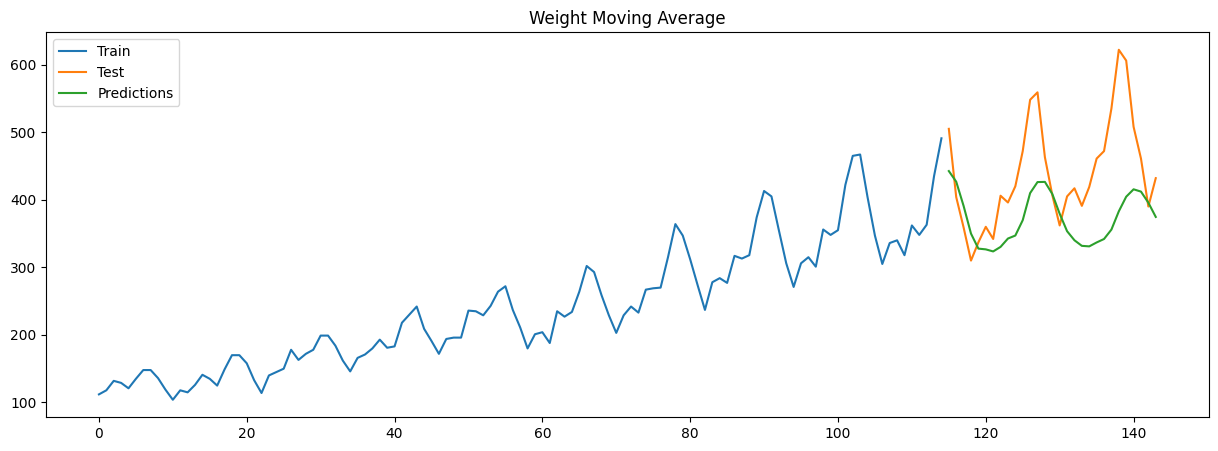

In [ ]:
weights = np.array([0.5,0,0,0,0,0,0,0,0,0,0,.5])

train, test = data_split(.8, new_df)

train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)

train_test_combined =  train.append(test)
for i in range(test.index[0], test.index[-1]+1):
    train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()
test['Predictions'] = train_test_combined['wma_roll12b']

evaluate_model(test['Passengers'], test['Predictions'], "Weight Moving Average")

plt.figure(figsize=(15, 5))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.title('Weight Moving Average')
plt.show()

### 3.2 Splitting method 2/3: k folds

<ipython-input-127-b2b5c35840ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-127-b2b5c35840ff>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-127-b2b5c35840ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()


RMSE for Weight Moving Average is 56.66040389539958


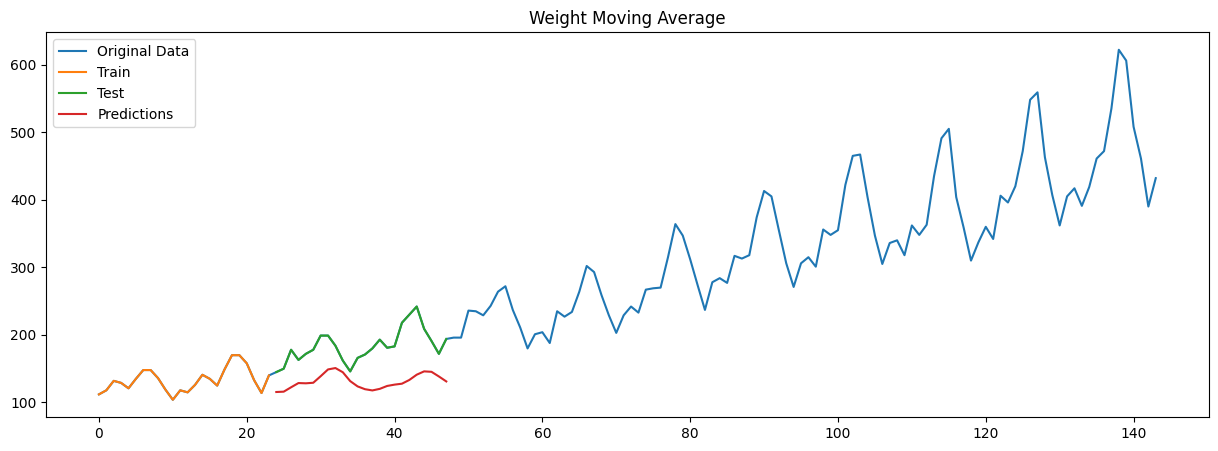

<ipython-input-127-b2b5c35840ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-127-b2b5c35840ff>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-127-b2b5c35840ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()


RMSE for Weight Moving Average is 57.679210964945305


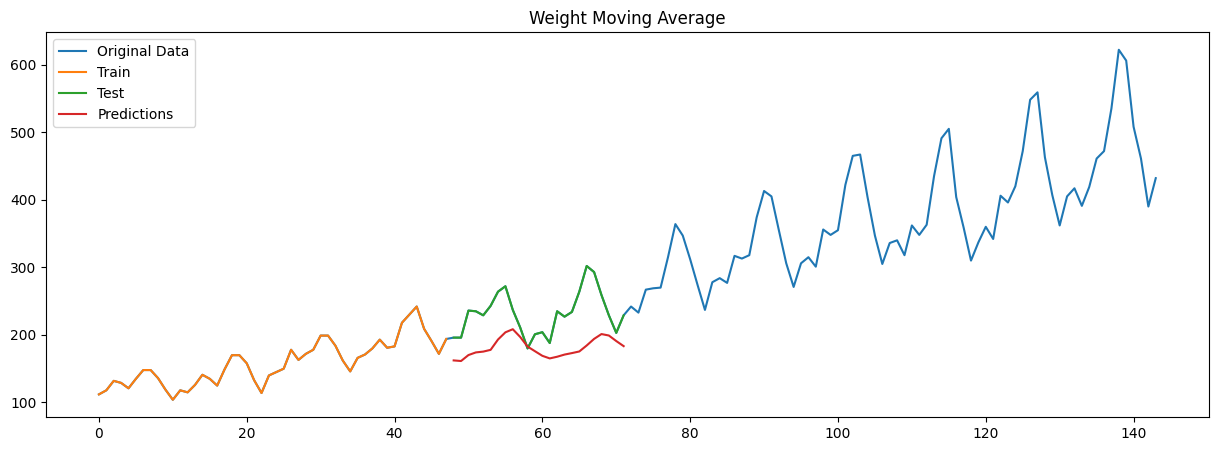

<ipython-input-127-b2b5c35840ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-127-b2b5c35840ff>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-127-b2b5c35840ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()


RMSE for Weight Moving Average is 87.56115412844153


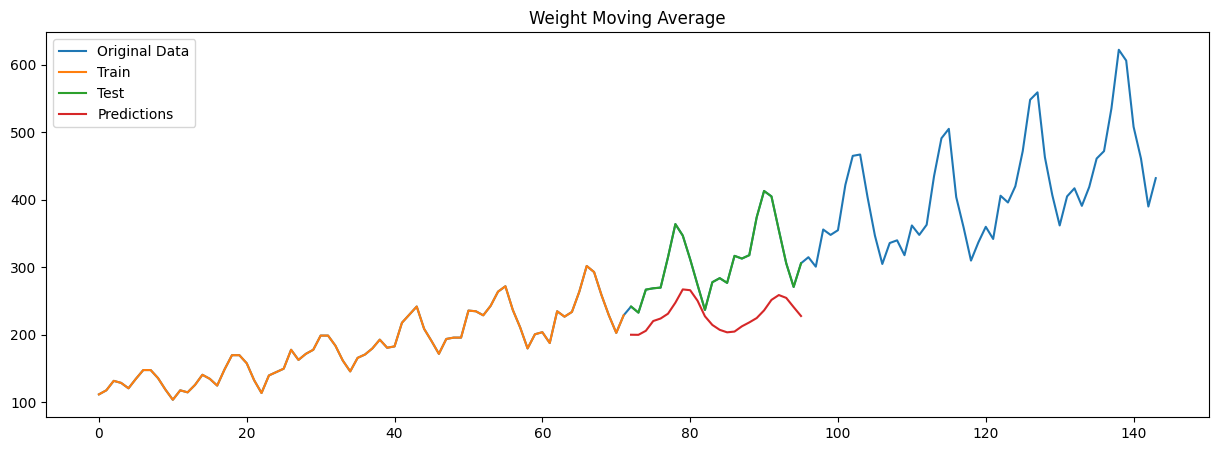

<ipython-input-127-b2b5c35840ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-127-b2b5c35840ff>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-127-b2b5c35840ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()


RMSE for Weight Moving Average is 87.0527178672381


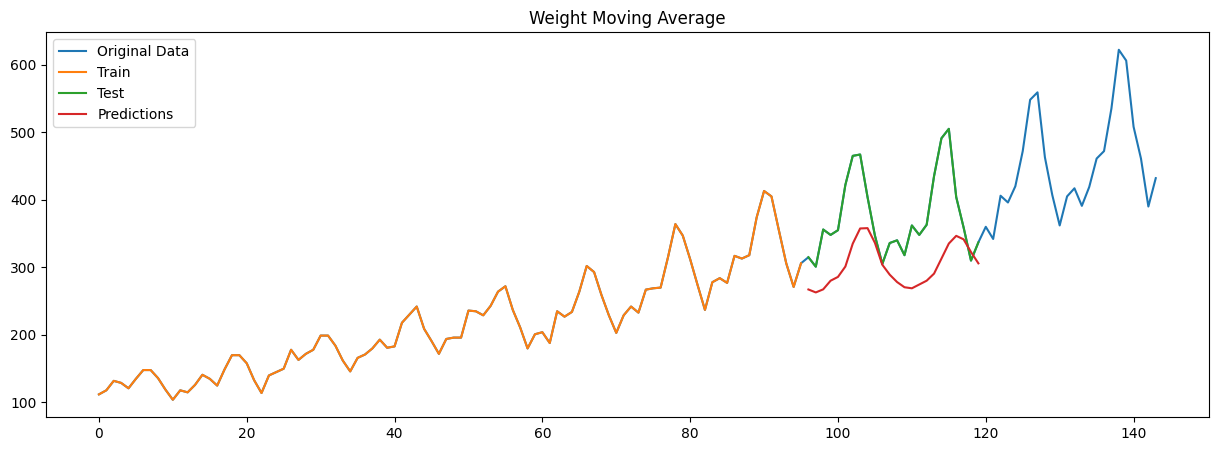

<ipython-input-127-b2b5c35840ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-127-b2b5c35840ff>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-127-b2b5c35840ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()


RMSE for Weight Moving Average is 102.18259916546214


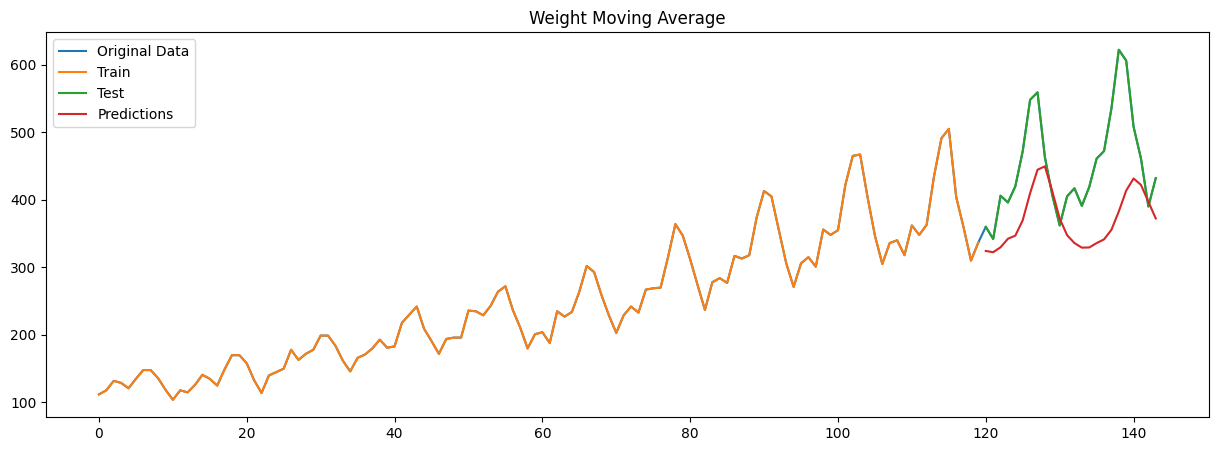

In [ ]:
errors = []
for train, test in k_folds(new_df):
    train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)

    train_test_combined =  train.append(test)
    for i in range(test.index[0], test.index[-1]+1):
        train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'][i-12:i] * weights).sum()
    test['Predictions'] = train_test_combined['wma_roll12b']

    e = evaluate_model(test['Passengers'], test['Predictions'], "Weight Moving Average")
    errors.append(e)
    
    plt.figure(figsize=(15, 5))
    plt.plot(new_df['Passengers'], label='Original Data')
    plt.plot(train['Passengers'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title('Weight Moving Average')
    plt.show()

In [ ]:
print("Weight Moving Average: ", sum(errors)/len(errors))

Weight Moving Average:  78.22721720429732


### 2.3 Splitting method 3/3: roll forward

<ipython-input-149-778b02c7c799>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-149-778b02c7c799>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-149-778b02c7c799>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'].loc[i-12:i-1] * weights).

RMSE for Weight Moving Average is 41.96300609117909


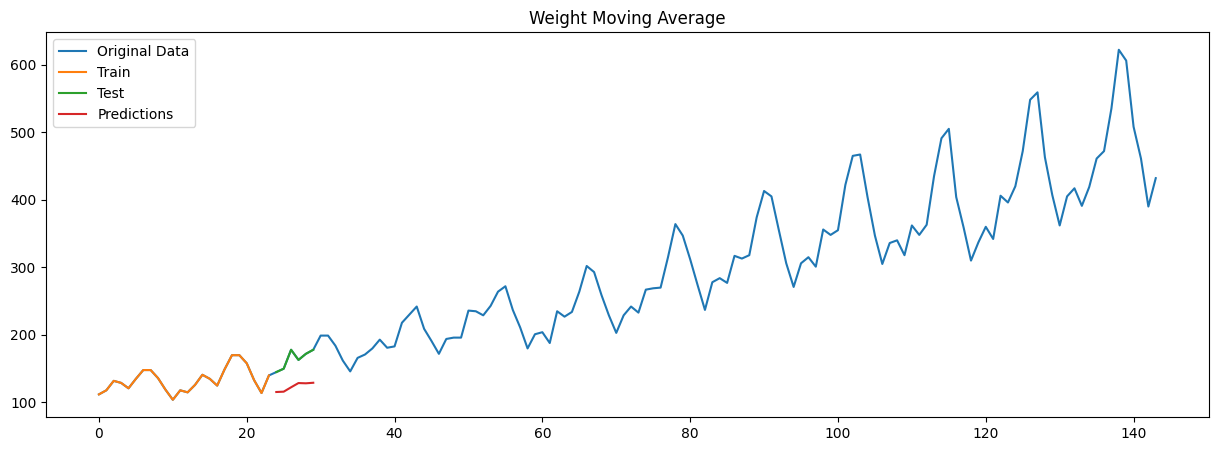

<ipython-input-149-778b02c7c799>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-149-778b02c7c799>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-149-778b02c7c799>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'].loc[i-12:i-1] * weights).

RMSE for Weight Moving Average is 33.63205483321956


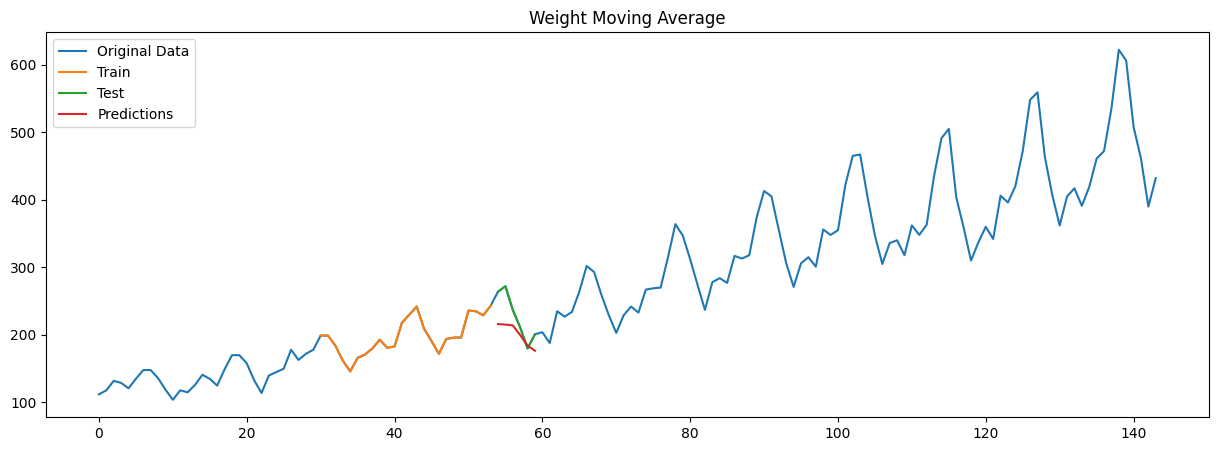

<ipython-input-149-778b02c7c799>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-149-778b02c7c799>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-149-778b02c7c799>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'].loc[i-12:i-1] * weights).

RMSE for Weight Moving Average is 81.77376385987468


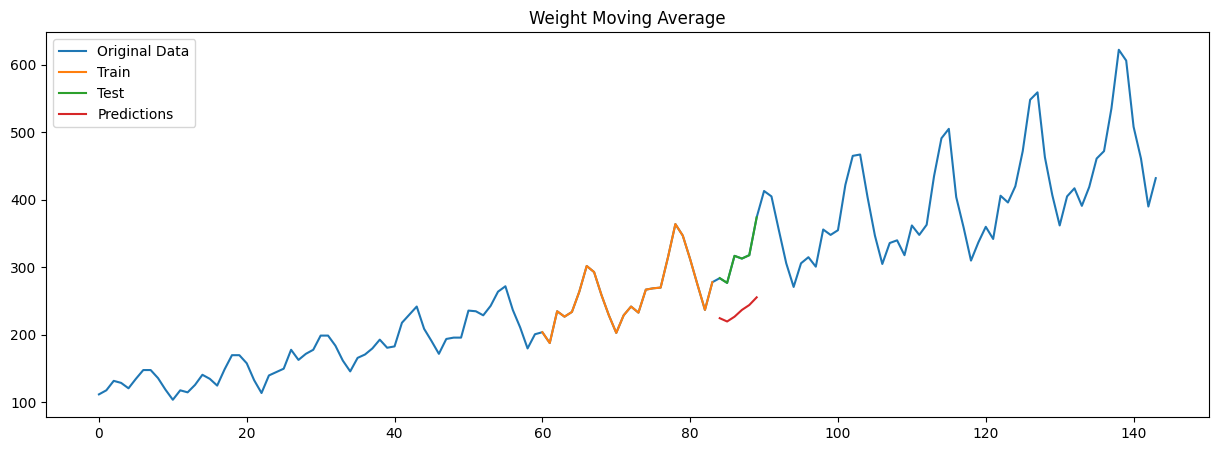

<ipython-input-149-778b02c7c799>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)
<ipython-input-149-778b02c7c799>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_combined =  train.append(test)
<ipython-input-149-778b02c7c799>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'].loc[i-12:i-1] * weights).

RMSE for Weight Moving Average is 53.12689334861394


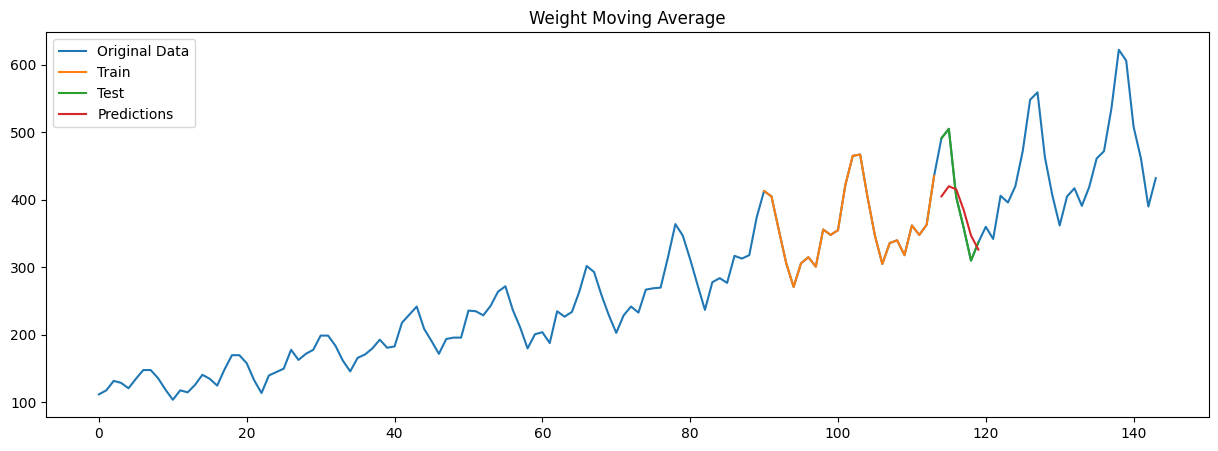

In [ ]:
errors = []
for train, test in roll_forward(new_df):
    if len(train) >= 24:
        train['wma_roll12b'] = train['Passengers'].rolling(window=12).apply(wma(weights)).shift(1)

        train_test_combined =  train.append(test)
        for i in range(test.index[0], test.index[-1]+1):
            train_test_combined['wma_roll12b'][i] = (train_test_combined['wma_roll12b'].loc[i-12:i-1] * weights).sum()
        test['Predictions'] = train_test_combined['wma_roll12b']

        e = evaluate_model(test['Passengers'], test['Predictions'], "Weight Moving Average")
        errors.append(e)
        
        plt.figure(figsize=(15, 5))
        plt.plot(new_df['Passengers'], label='Original Data')
        plt.plot(train['Passengers'], label='Train')
        plt.plot(test['Passengers'], label='Test')
        plt.plot(test['Predictions'], label='Predictions')
        plt.legend()
        plt.title('Weight Moving Average')
        plt.show()

In [ ]:
print("Weight Moving Average: ", sum(errors)/len(errors))

Weight Moving Average:  52.62392953322182


## 4. Simple Linear Regression Model.

In [ ]:
import statsmodels.api as sm

### 4.1 Splitting method 1/3: simple train test split

In [ ]:
train, test = data_split(.8, new_df)
train['intercept'] = 1 # must define intercept
test['intercept'] = 1 # must define intercept
lm = sm.OLS(train['Passengers'], train.rename_axis('t').reset_index()[['t', 'intercept']])
model = lm.fit()
model.summary()

<ipython-input-152-714267d0ea48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-152-714267d0ea48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     600.9
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           4.79e-47
Time:                        21:04:57   Log-Likelihood:                -575.87
No. Observations:                 115   AIC:                             1156.
Df Residuals:                     113   BIC:                             1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              2.5136      0.103     24.513      0.000       2.310       2.717
intercept     96.6742      6.764     14.293      0.000      83.274     110.075
==============================================================================
Omnibus:                       14.985   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.110
Skew:                           0.791   Prob(JB):                     0.000193
Kurtosis:                       4.032   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-153-226f14e5d5bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = model.predict(test.rename_axis('t').reset_index()[['t', 'intercept']]).set_axis(test.index)


RMSE for Simple Linear Regression is 73.80490236213495


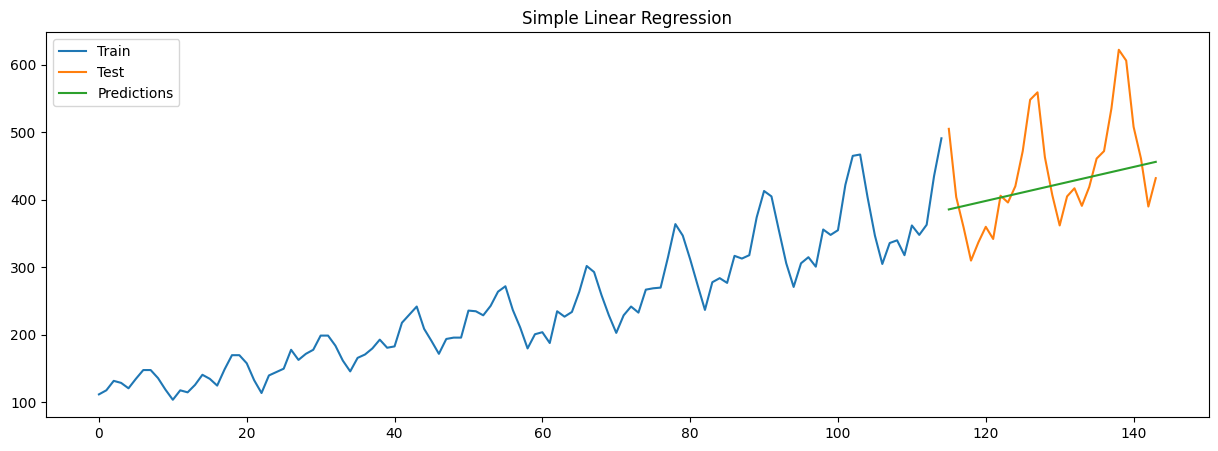

In [ ]:
test['Predictions'] = model.predict(test.rename_axis('t').reset_index()[['t', 'intercept']]).set_axis(test.index)
evaluate_model(test['Passengers'], test['Predictions'], "Simple Linear Regression")
plt.figure(figsize=(15, 5))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.title('Simple Linear Regression')
plt.show()

A simple linear regression model only captures the trend as it tries to fit all the data onto one line thus it performs better than previous methods as in this example the data fluctuates around the trend resulting in a less amount of error overall

### 4.2 Splitting method 2/3: k folds

<ipython-input-154-2b2dfd877dbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 34.212750888775986


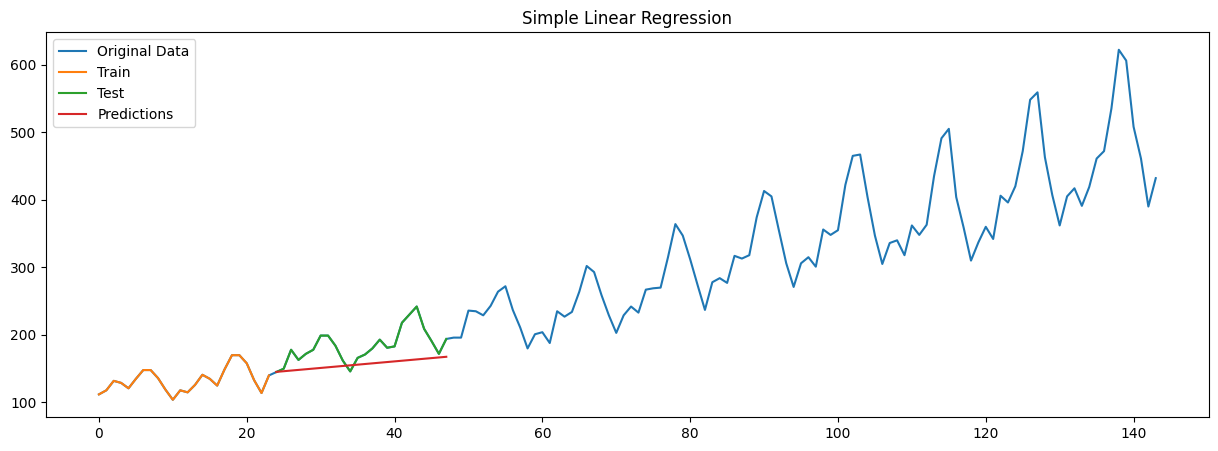

<ipython-input-154-2b2dfd877dbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 30.948717969254165


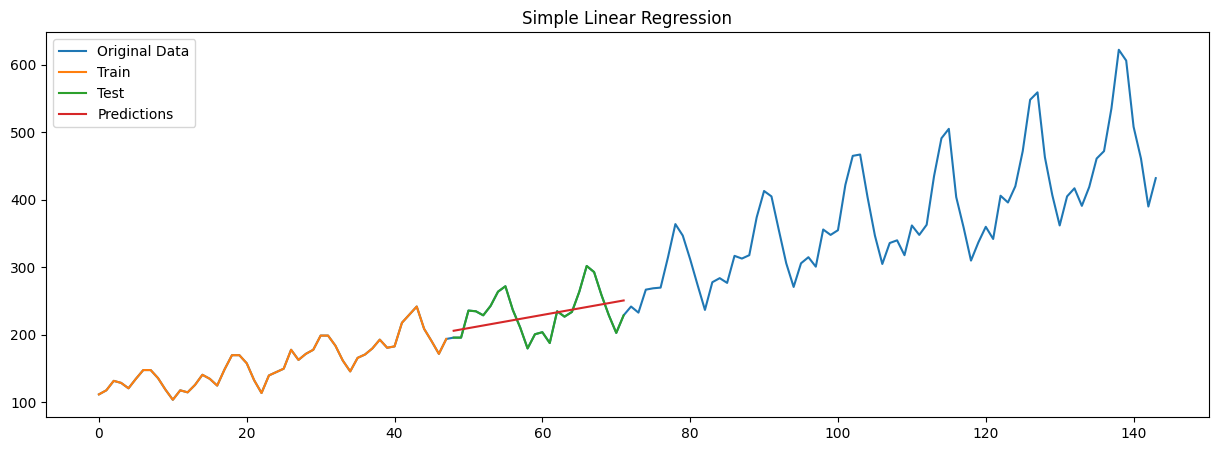

<ipython-input-154-2b2dfd877dbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 51.66779299564621


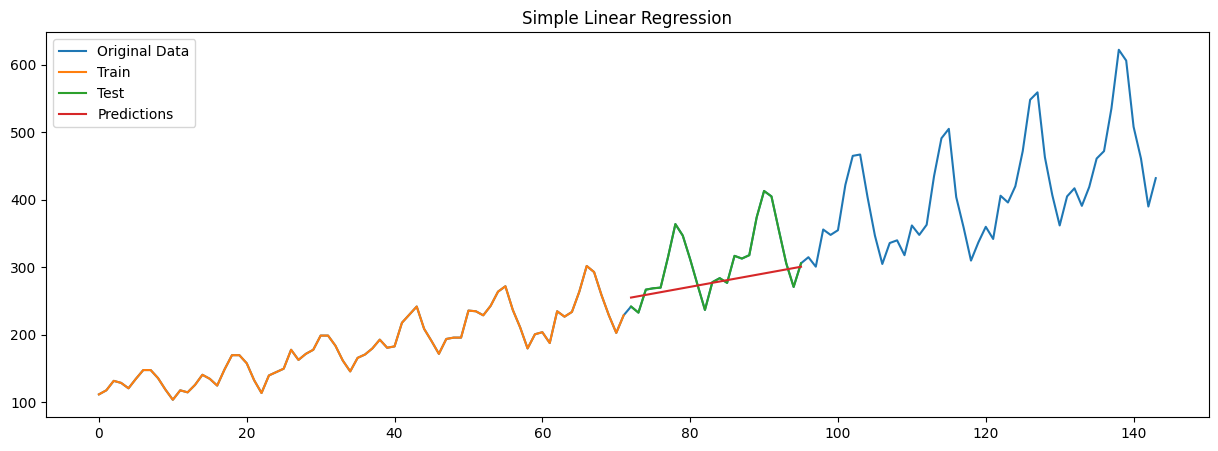

<ipython-input-154-2b2dfd877dbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 62.13560330521184


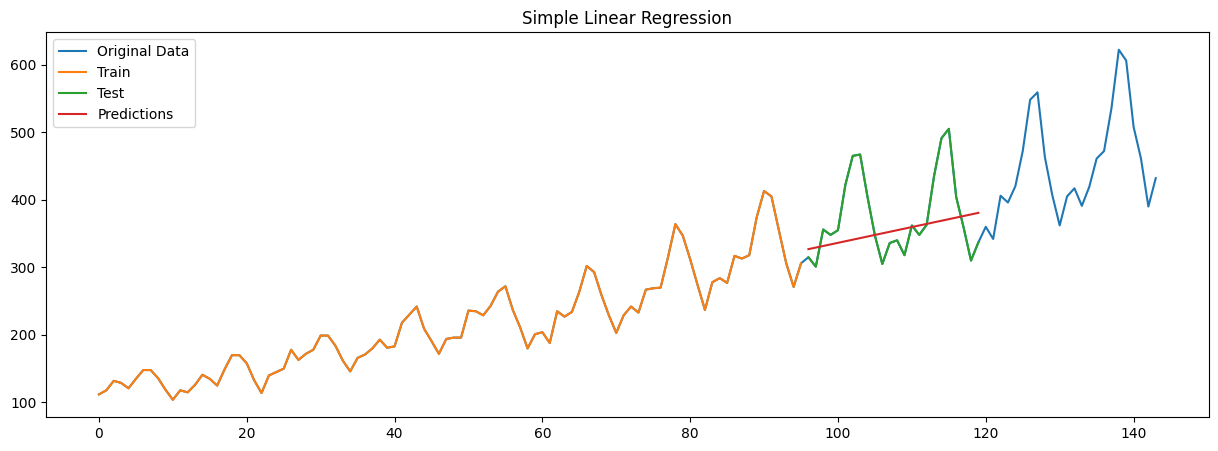

<ipython-input-154-2b2dfd877dbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-154-2b2dfd877dbc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 74.78775885644494


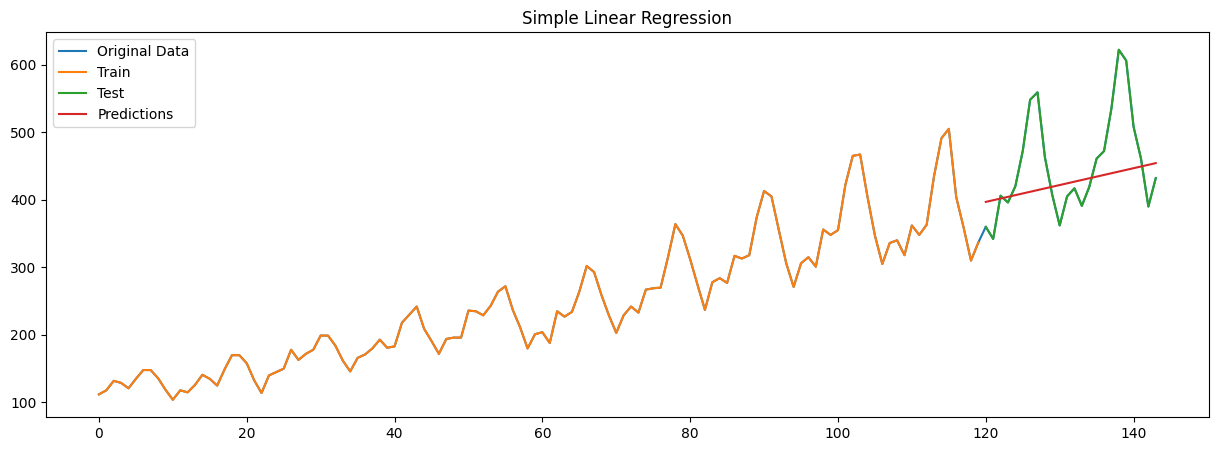

In [ ]:
errors = []
for train, test in k_folds(new_df):
    train['intercept'] = 1 # must define intercept
    test['intercept'] = 1 # must define intercept
    lm = sm.OLS(train['Passengers'], train.rename_axis('t').reset_index()[['t', 'intercept']])
    model = lm.fit()

    test['Predictions'] = model.predict(test.rename_axis('t').reset_index()[['t', 'intercept']]).set_axis(test.index)

    e = evaluate_model(test['Passengers'], test['Predictions'], "Simple Linear Regression")
    errors.append(e)

    plt.figure(figsize=(15, 5))
    plt.plot(new_df['Passengers'], label='Original Data')
    plt.plot(train['Passengers'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title('Simple Linear Regression')
    plt.show()

In [ ]:
print("Simple Linear Regression: ", sum(errors)/len(errors))

Simple Linear Regression:  50.750524803066625


### 4.3 Splitting method 3/3: roll forward

<ipython-input-157-f68800e4e977>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 20.312481473017556


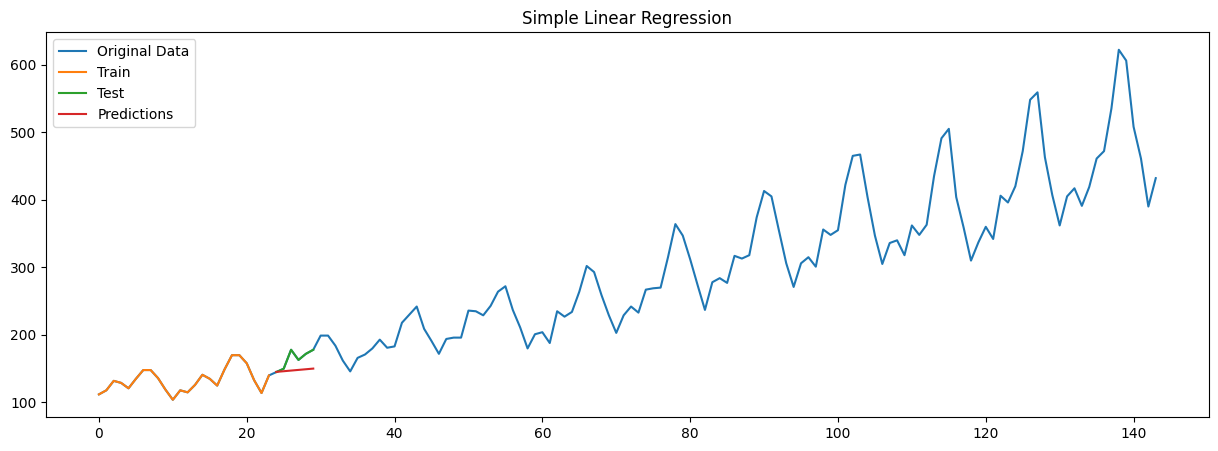

<ipython-input-157-f68800e4e977>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 37.56361936977761


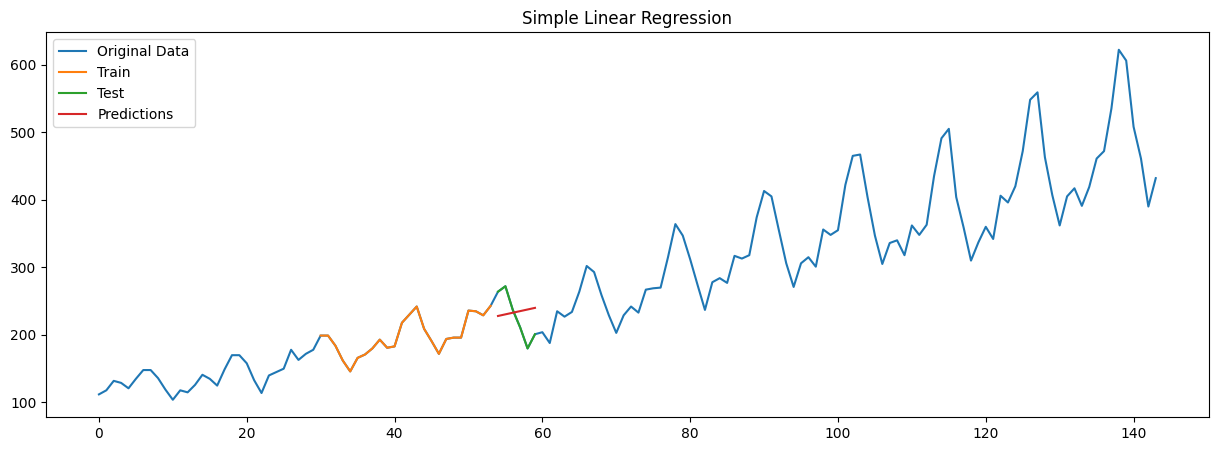

<ipython-input-157-f68800e4e977>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 26.12413581771122


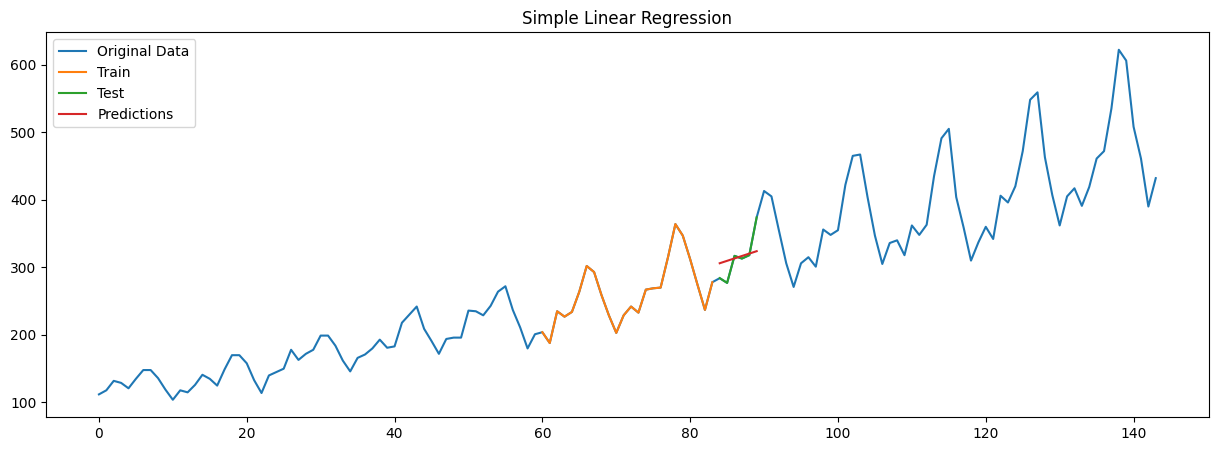

<ipython-input-157-f68800e4e977>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 79.88771164060228


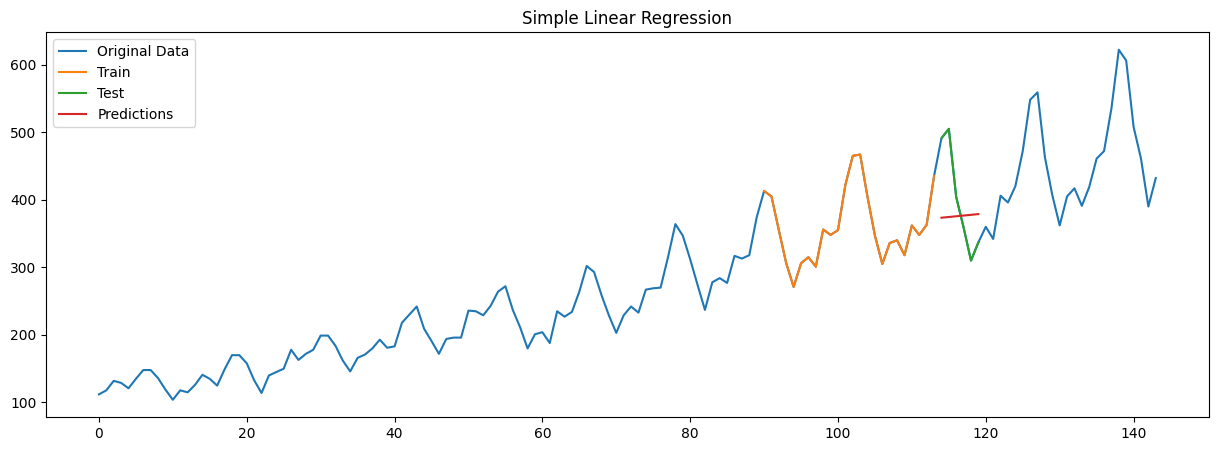

<ipython-input-157-f68800e4e977>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['intercept'] = 1 # must define intercept
<ipython-input-157-f68800e4e977>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

RMSE for Simple Linear Regression is 92.2629807879862


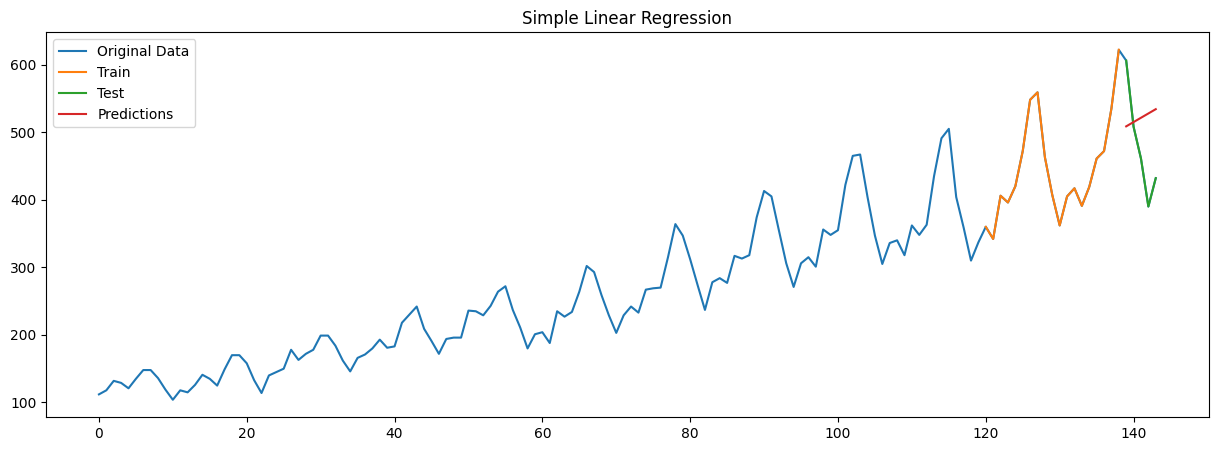

In [ ]:
errors = []
for train, test in roll_forward(new_df):
    train['intercept'] = 1 # must define intercept
    test['intercept'] = 1 # must define intercept
    lm = sm.OLS(train['Passengers'].reset_index(drop=True), train.rename_axis('t').reset_index()[['t', 'intercept']])
    model = lm.fit()

    test['Predictions'] = model.predict(test.rename_axis('t').reset_index()[['t', 'intercept']]).set_axis(test.index)

    e = evaluate_model(test['Passengers'], test['Predictions'], "Simple Linear Regression")
    errors.append(e)

    plt.figure(figsize=(15, 5))
    plt.plot(new_df['Passengers'], label='Original Data')
    plt.plot(train['Passengers'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title('Simple Linear Regression')
    plt.show()

In [ ]:
print("Simple Linear Regression: ", sum(errors)/len(errors))

Simple Linear Regression:  51.23018581781897


## 5. Classical Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [ ]:
air_passengers = df.copy()

In [ ]:
air_passengers['Month'] = pd.to_datetime(air_passengers['Month'])

In [ ]:
air_passengers.head(2)

Month  Passengers
0 1949-01-01         112
1 1949-02-01         118

The classical decomposition succeeds to extract the trend and seasonality.

But the seasonality component is inconvenient as it is not changing. We expected it to increase exponentially as it is a multiplicative model

Also, the trend line and residuals are missing six values from the beginning and other six values from the end

We believe that this is the downside of this quick simple algorithm, and it would have been better to use STL or X11 decomposition

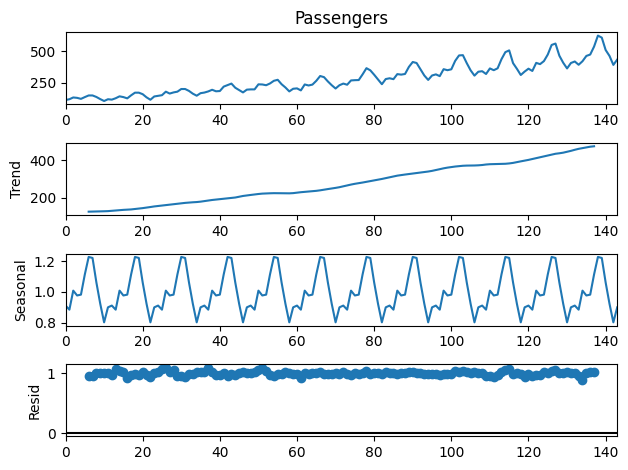

In [ ]:
decompose_result = seasonal_decompose(air_passengers.Passengers, model='multiplicative', period=12)
cl_trend = decompose_result.trend
cl_seasonal = decompose_result.seasonal
cl_residual = decompose_result.resid
decompose_result.plot()
plt.show()

In [ ]:
def classical_prediction(train_df, test_df):
  # 1. decompose the time series
  decompose_result = seasonal_decompose(train_df.Passengers, model='multiplicative', period=12)
  cl_trend = decompose_result.trend
  cl_seasonal = decompose_result.seasonal

  # 2. get the seasonal indicies
  seasonal_indicies = cl_seasonal.values[:12]

  # 3. fit a trend model
  lm = sm.OLS(train_df.Passengers, train_df[['T', 'Intercept']])
  results = lm.fit()

  # 4. predict the trend for the test data
  trend_predction = results.predict(test_df[['T', 'Intercept']]).values

  # 5. predict the time series using multiplicative model
  predictions = []
  months = test_df['Month'].dt.month
  for i in range(len(test_df)):
    s_indx = months.iloc[i]-1
    pred = trend_predction[i] * seasonal_indicies[s_indx]
    predictions.append(pred)
    
  return predictions

In [ ]:
def plot_predictions(train_df, test_df, predictions):
  plt.plot(air_passengers['Month'], air_passengers['Passengers'], 'black', label='original data')
  plt.plot(train_df['Month'], train_df['Passengers'], 'b', label='train')
  plt.plot(test_df['Month'], test_df['Passengers'], 'g', label='test')
  plt.plot(test_df['Month'], predictions, 'r--', label='predict')
  plt.xlabel('Month')
  plt.ylabel('Passengers')
  plt.legend()
  plt.title('Monthly number of passengers')

  plt.show()

In [ ]:
air_passengers['T'] = np.arange(len(air_passengers))
air_passengers['Intercept'] = 1

Now we will try diffenrent splittings of the data to evaluate the model

### 5.1 Spliting Data Using Simple Train Test Split 

In [ ]:
split_percent = 0.7
train_df, test_df = data_split(split_percent, air_passengers)

In [ ]:
predictions = classical_prediction(train_df, test_df)

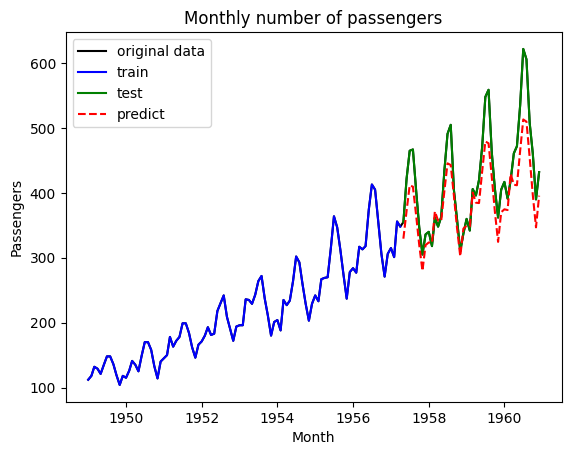

In [ ]:
plot_predictions(train_df, test_df, predictions)

In [ ]:
evaluate_model(test_df.Passengers, predictions, "Classical Decomposition")

RMSE for Classical Decomposition is 43.753891709848176


43.753891709848176

### 5.2 Spliting Data Using K-folds Cross Validatoin 

In [ ]:
errors = []

RMSE for Classical Decomposition is 17.324135670930307


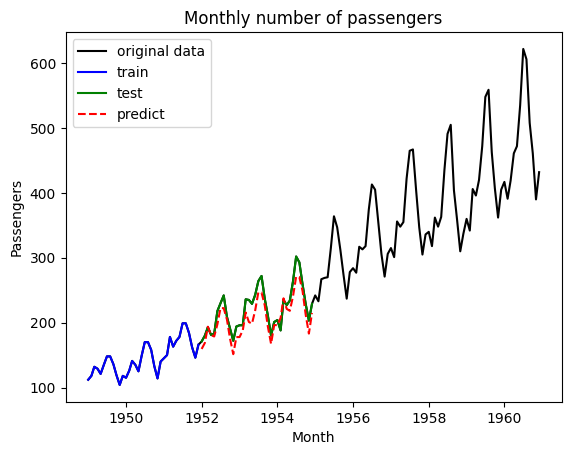

RMSE for Classical Decomposition is 43.69391813741391


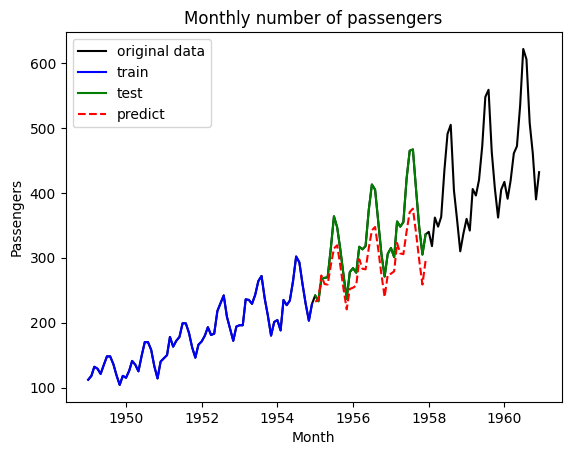

RMSE for Classical Decomposition is 33.266403271019506


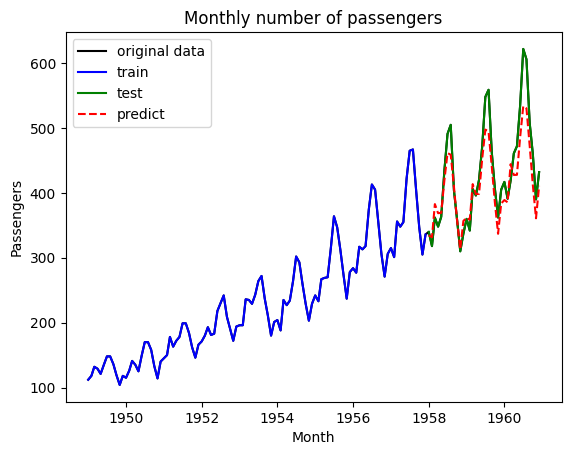

In [ ]:
for train, test in k_folds(air_passengers, n_splits = 3):
  predictions = classical_prediction(train, test)
  e = evaluate_model(test.Passengers, predictions, "Classical Decomposition")
  errors.append(e)
  plot_predictions(train, test, predictions)

In [ ]:
print("Classical Decomposition Error: ", sum(errors)/len(errors))

Classical Decomposition Error:  31.428152359787912


### 5.3 Spliting Data Using Roll-forward

In [ ]:
errors = []

RMSE for Classical Decomposition is 20.56648250167914


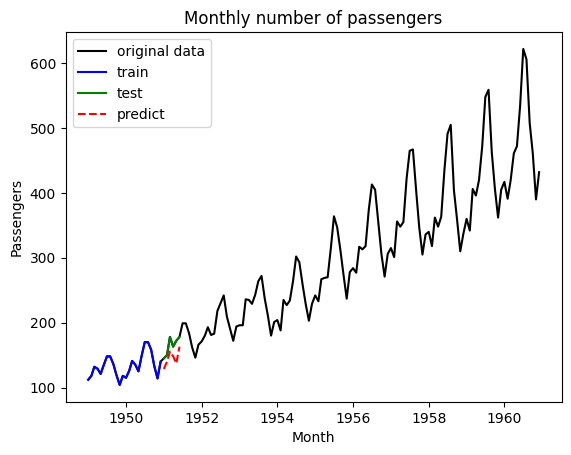

RMSE for Classical Decomposition is 43.89173563079048


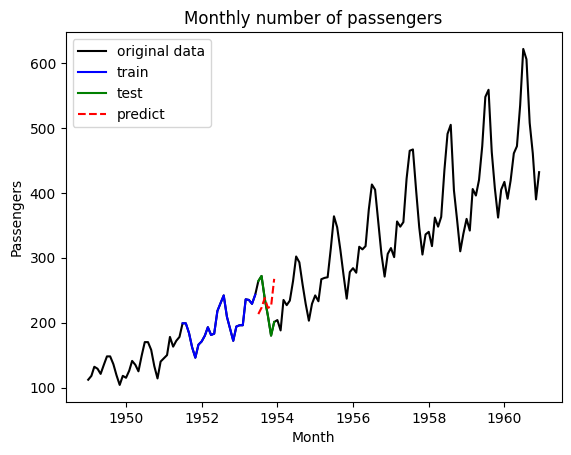

RMSE for Classical Decomposition is 6.433120644389375


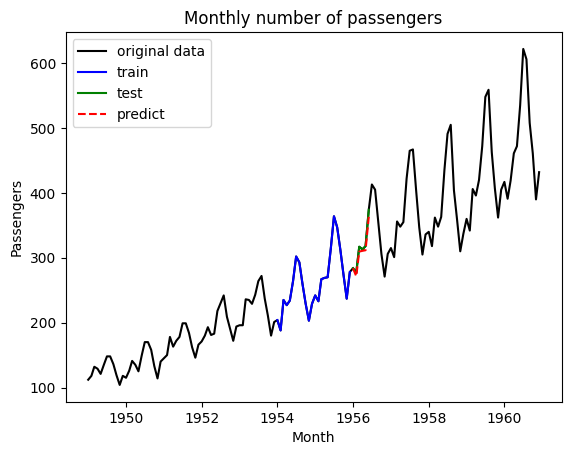

RMSE for Classical Decomposition is 110.13313957060393


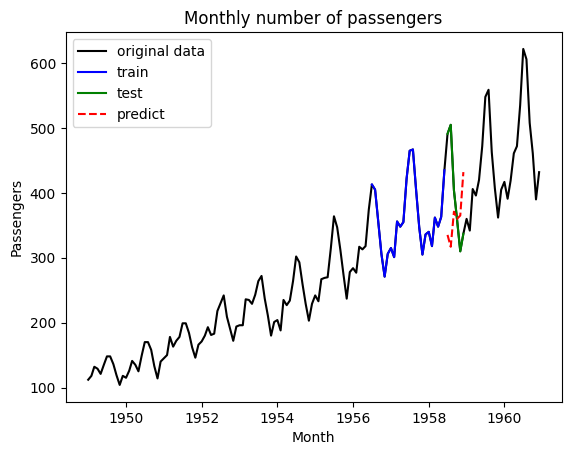

In [ ]:
for train, test in roll_forward(air_passengers):
  if len(train) >= 24:
    predictions = classical_prediction(train, test)
    e = evaluate_model(test.Passengers, predictions, "Classical Decomposition")
    errors.append(e)
    plot_predictions(train, test, predictions)

In [ ]:
print("Classical Decomposition Error: ", sum(errors)/len(errors))

Classical Decomposition Error:  45.256119586865736


## 6. STL Decomposition and Forecastiong

### STL Decomposition

In [ ]:
from statsmodels.tsa.seasonal import STL

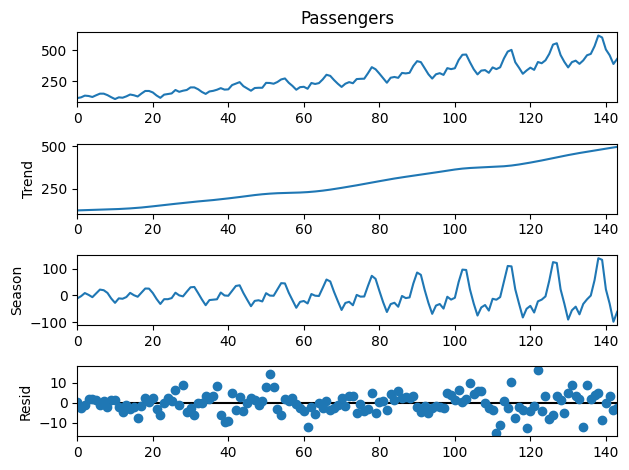

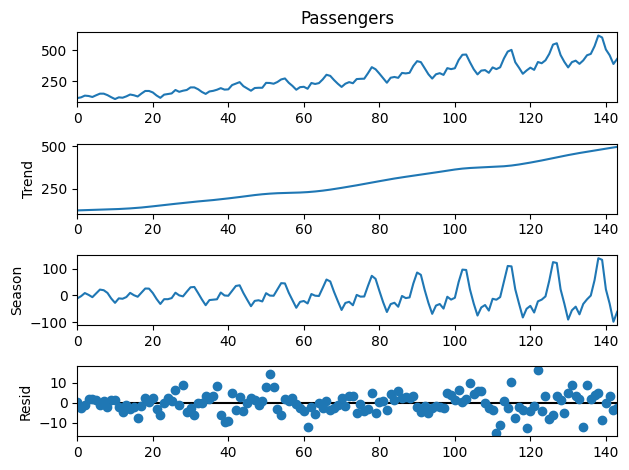

In [ ]:
stl = STL(air_passengers.Passengers,period = 12)
res = stl.fit()
res.plot()

ok I applied the classical and STL decompositions in this dataset and noticed that:
1- the outputs of the trend in both methods are the same and it's successful output.

2- the dataset is multiplicative so the output of seasonality must be multipilcative in decomposition also,but that doesn't appear in classical, it's successfully appeared in STL

### STL Forecasting

In [ ]:
air_passengers = df.copy()

In [ ]:
air_passengers['Month'] = pd.to_datetime(air_passengers['Month'])

In [ ]:
air_passengers['T'] = np.arange(len(air_passengers))
air_passengers['Intercept'] = 1

In [ ]:
def stl_prediction(train_df, test_df):
  # 1. transform the multiplicative model to be able to work with STL
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)

  # 2. decompose the time series
  stl = STL(train_df.Passengers_box_cox, period=12)
  decompose_result = stl.fit()
  
  # 3. Take the exponential of the seasonality so that we can perform on the multiplicative model
  stl_seasonal = np.exp(decompose_result.seasonal)

  # 4. get the seasonal indicies
  seasonal_indicies = stl_seasonal.values[:12]

  # 3. fit a trend model
  lm = sm.OLS(train_df.Passengers, train_df[['T', 'Intercept']])
  results = lm.fit()

  # 4. predict the trend for the test data
  trend_predction = results.predict(test_df[['T', 'Intercept']]).values

  # 5. predict the time series using multiplicative model
  predictions = []
  months = test_df['Month'].dt.month
  for i in range(len(test_df)):
    s_indx = months.iloc[i]-1
    pred = trend_predction[i] * seasonal_indicies[s_indx]
    predictions.append(pred)
    
  return predictions

Now we will try diffenrent splittings of the data to evaluate the model

### 6.1 Spliting Data Using Simple Train Test Split 

In [ ]:
split_percent = 0.7
train_df, test_df = data_split(split_percent, air_passengers)

In [ ]:
predictions = stl_prediction(train_df, test_df)

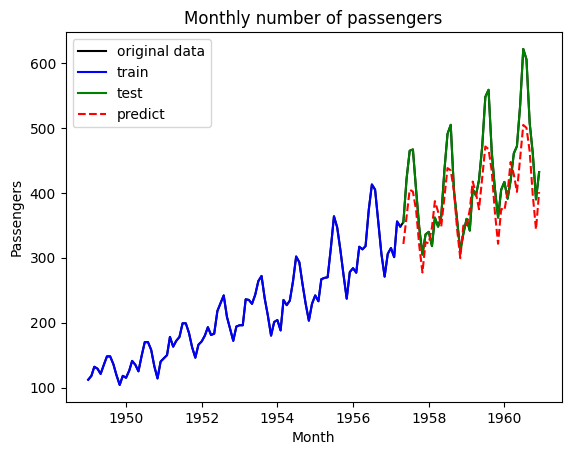

In [ ]:
plot_predictions(train_df, test_df, predictions)

In [ ]:
evaluate_model(test_df.Passengers, predictions, "STL Decomposition")

RMSE for STL Decomposition is 48.05653381100003


48.05653381100003

### 6.2 Spliting Data Using K-folds Cross Validatoin 

In [ ]:
errors = []

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 16.895666443896918


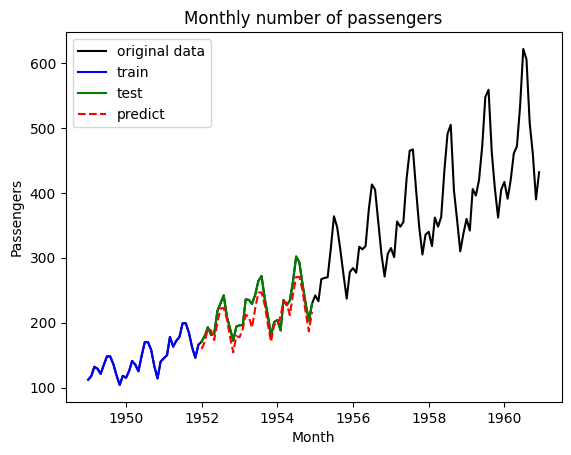

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 43.51507988699261


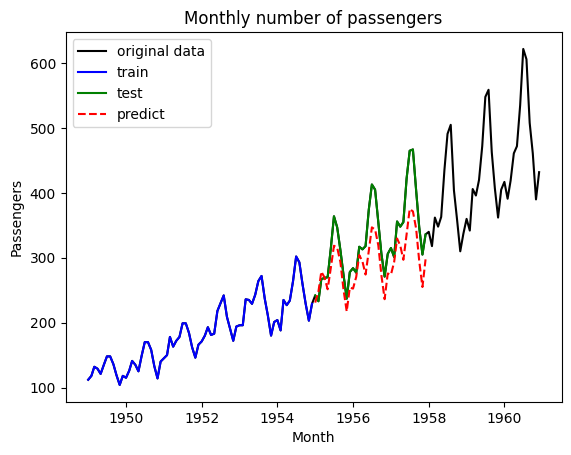

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 40.34477698143592


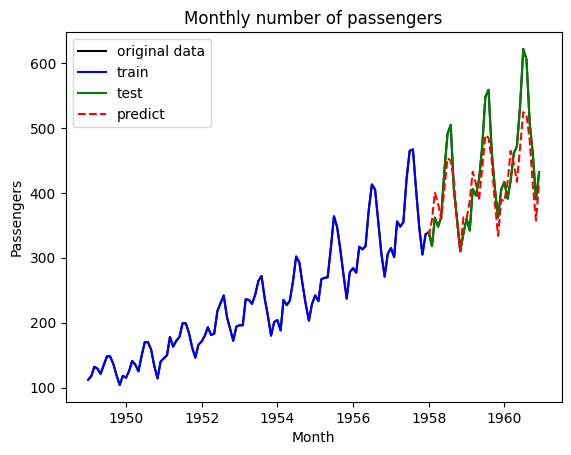

In [ ]:
for train, test in k_folds(air_passengers, n_splits = 3):
  predictions = stl_prediction(train, test)
  e = evaluate_model(test.Passengers, predictions, "STL Decomposition")
  errors.append(e)
  plot_predictions(train, test, predictions)

In [ ]:
print("STL Decomposition Error: ", sum(errors)/len(errors))

STL Decomposition Error:  33.585174437441815


### 5.3 Spliting Data Using Roll-forward

In [ ]:
errors = []

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 14.97012604041266


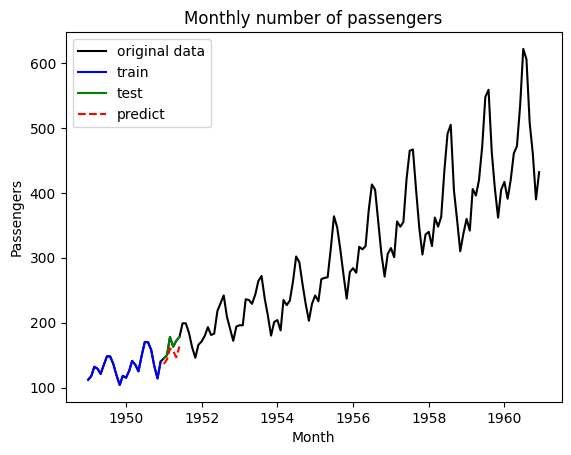

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 44.01782378925272


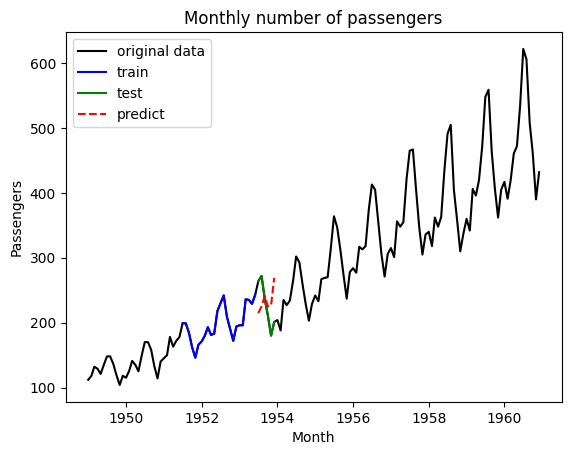

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 8.672938565770044


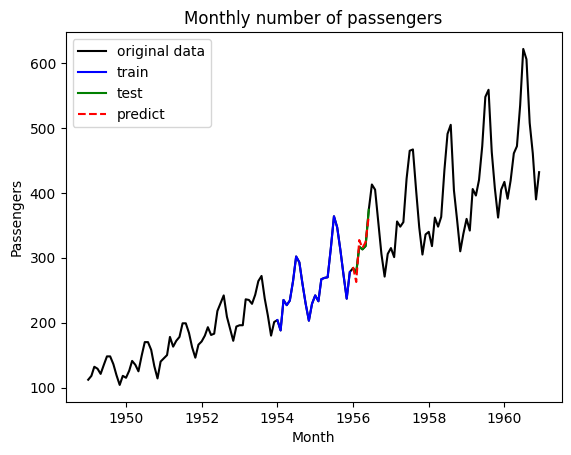

<ipython-input-99-1f8ebca1d3e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Passengers_box_cox'] = np.log(train_df.Passengers)


RMSE for STL Decomposition is 110.83338156760378


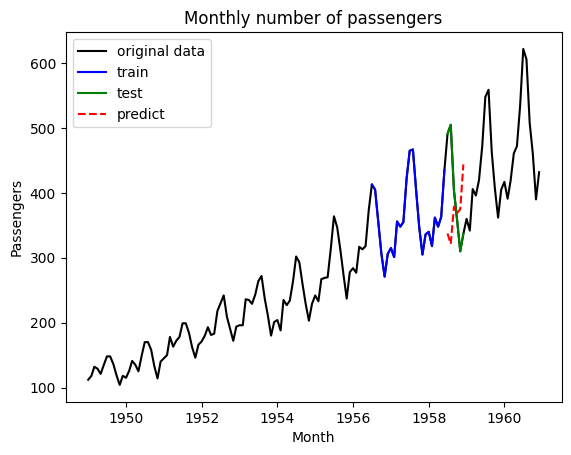

In [ ]:
for train, test in roll_forward(air_passengers):
  if len(train) >= 24:
    predictions = stl_prediction(train, test)
    e = evaluate_model(test.Passengers, predictions, "STL Decomposition")
    errors.append(e)
    plot_predictions(train, test, predictions)

In [ ]:
print("STL Decomposition Error: ", sum(errors)/len(errors))

STL Decomposition Error:  44.6235674907598


## STL Forecasting With ARIMA

### ACF & PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Here, I will apply ACF & PACF on res.resid because it is more stationary after I remove Trend and Seasonality.
If we are looking at ACF & PACF of trend and seaonality, we can't assign the exact and correct lags.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


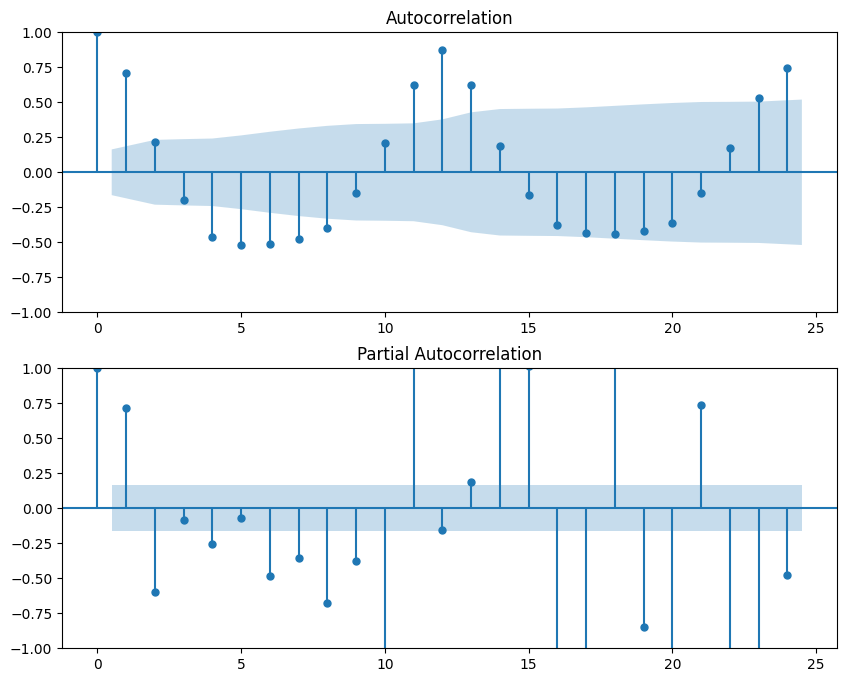

In [ ]:
# on Seasonal.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(res.seasonal, lags=24, ax=ax[0])
plot_pacf(res.seasonal, lags=24, ax=ax[1])
plt.show()

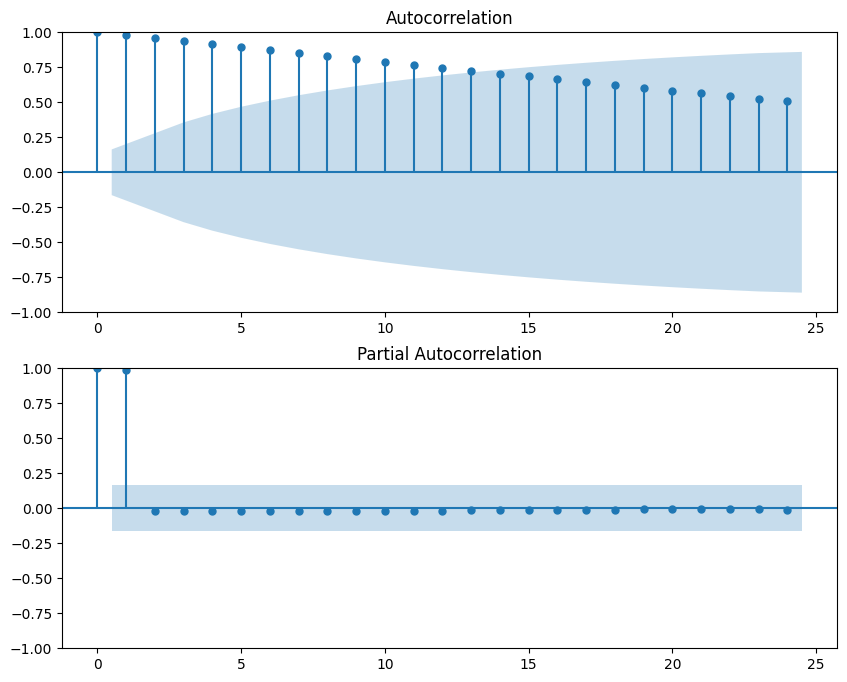

In [ ]:
# on Trend.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(res.trend, lags=24, ax=ax[0])
plot_pacf(res.trend, lags=24, ax=ax[1])
plt.show()

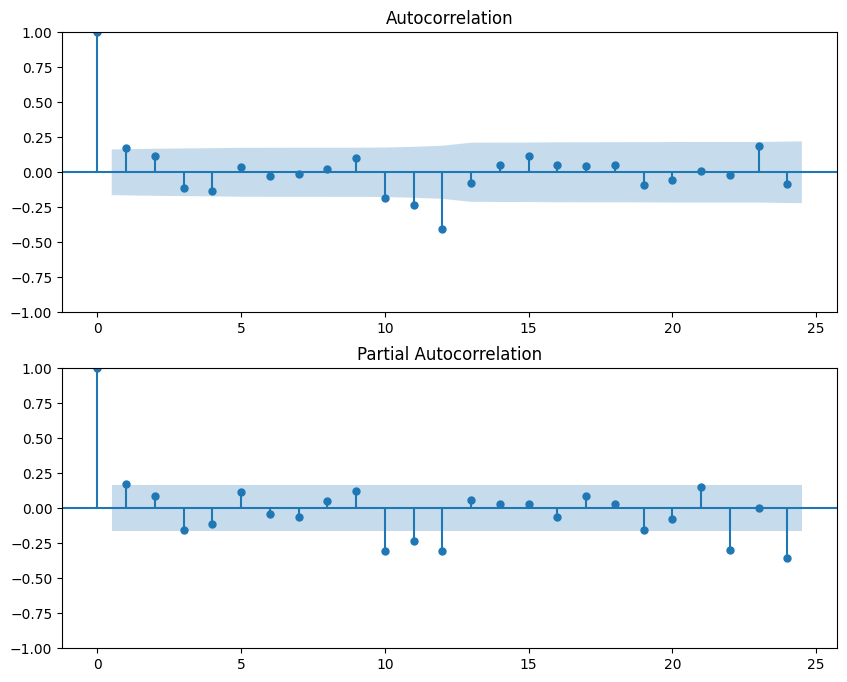

In [ ]:
# on Residual.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(res.resid, lags=24, ax=ax[0])
plot_pacf(res.resid, lags=24, ax=ax[1])
plt.show()

Here, In partial autocorrelation the lags that are significant is 1 lag so autoregression will be AR(1). In Autocorrelation, the lags that are significant is 1 lag so Moving Average will be MA(1).

After I get q and p,I want ti know the exact d(difference) so I will apply ADF on res.trend to see is it stationary or not? to know d.

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Assume you have already obtained the trend component from the STL decomposition
trend_component = res.trend

# Perform ADF test on the trend component
result = adfuller(trend_component)

# Print the p-value and test statistic
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpret the results
if result[1] <= 0.05:
    print('The trend component is stationary')
else:
    print('The trend component is non-stationary')

ADF Statistic: 2.333570
p-value: 0.998976
The trend component is non-stationary


In [ ]:
trend_component = trend_component.diff(periods = 1)
trend_component = trend_component[1:-1]

In [ ]:
# Perform ADF test on the trend component
result = adfuller(trend_component)

# Print the p-value and test statistic
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpret the results
if result[1] <= 0.05:
    print('The trend component is stationary')
else:
    print('The trend component is non-stationary')

ADF Statistic: -3.631130
p-value: 0.005193
The trend component is stationary


In [ ]:
# Assume you have already obtained the trend component from the STL decomposition
seasonal_component = res.seasonal

# Perform ADF test on the trend component
result = adfuller(seasonal_component)

# Print the p-value and test statistic
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpret the results
if result[1] <= 0.05:
    print('The seasonal component is stationary')
else:
    print('The seasonal component is non-stationary')

ADF Statistic: -9.929422
p-value: 0.000000
The seasonal component is stationary


After fd, the trend component is stationary,so d = 1 in ARIMA--------> ARIMA(1,1,1)

In [ ]:
data = np.array(df_series.values)
idx = pd.date_range(start='1949-01-01', periods=len(data), freq='MS')
# Create a pandas Series with the data and the index
df_series = pd.Series(data, index=idx)
df_series

1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Length: 144, dtype: int64

### STL forecasting with roll-forward approach:

It is not possible to appply STL on a single value.

### STL forecasting with simple trian test split approach:

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RMSE for STL Forecasting is 19.45367907606776


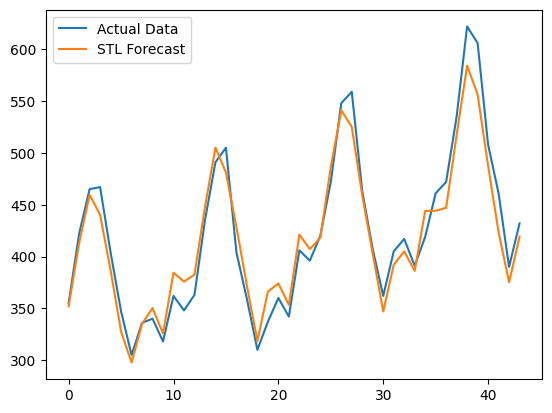

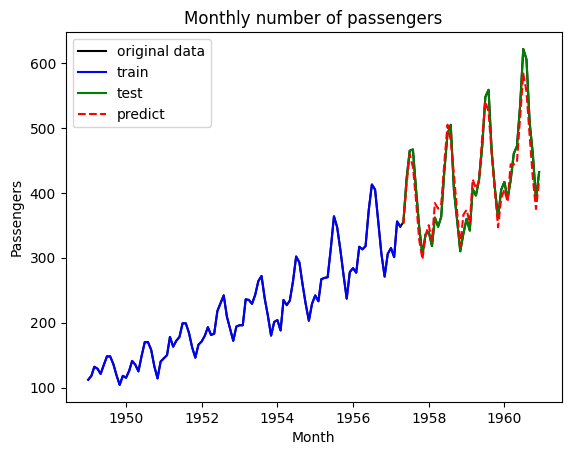

In [ ]:
# Define the train-test split
#train_size = int(len(df_series) * 0.7)
train_data, test_data = data_split(0.7,air_passengers)#df_series[:train_size], df_series[train_size:]

# Define the number of steps ahead to forecast
forecast_horizon = len(test_data)

# Apply the STL decomposition to the training data
stl_data = STL(train_data.Passengers,period = 12, seasonal=13).fit()

# Model the trend component using ARIMA
trend_model = ARIMA(stl_data.trend, order=(1, 1, 1)).fit()

# Model the seasonal component using seasonal ARIMA
seasonal_model = SARIMAX(stl_data.seasonal, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Forecast the trend and seasonal components for the test data
trend_forecast = trend_model.forecast(steps=forecast_horizon)
seasonal_forecast = seasonal_model.forecast(steps=forecast_horizon)

# Combine the forecasts with the residual component of the STL decomposition to produce the final forecast for the test data
forecast_values = trend_forecast.values + seasonal_forecast.values + stl_data.resid[-forecast_horizon:].values

# Calculate the error metrics for the forecast
#mse = ((test_data.values - forecast_values)**2).mean()
#mae = abs((test_data.values - forecast_values)).mean()
rmse = evaluate_model(test_data.Passengers,forecast_values,'STL Forecasting')

# Print the error metrics
#print("Mean Squared Error: ", mse)
#print("Mean Absolute Error: ", mae)
#print("Root Mean Squared Error: ", rmse)

# Plot the forecast against the actual test data
plt.plot(test_data.Passengers.values, label="Actual Data")
plt.plot(forecast_values, label="STL Forecast")
plt.legend()
plt.show()
plot_predictions(train_data,test_data,forecast_values)

### STL forecasting with time series sklearn cross validation approach:

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for STL Forecasting is 23.58323178113634


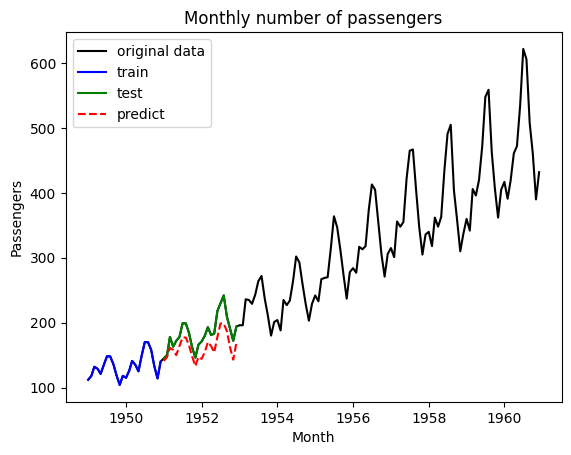

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE for STL Forecasting is 18.827793759040613


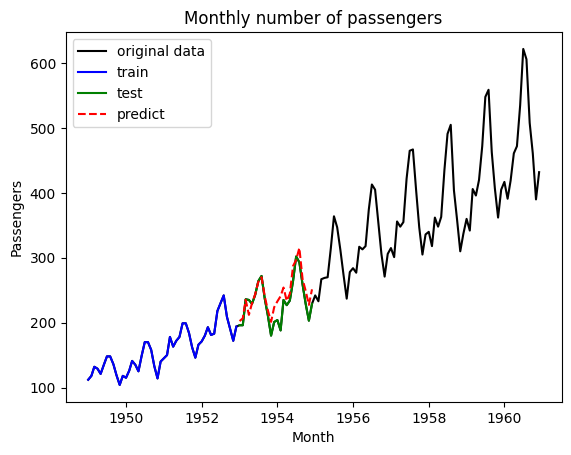

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for STL Forecasting is 27.76813669225525


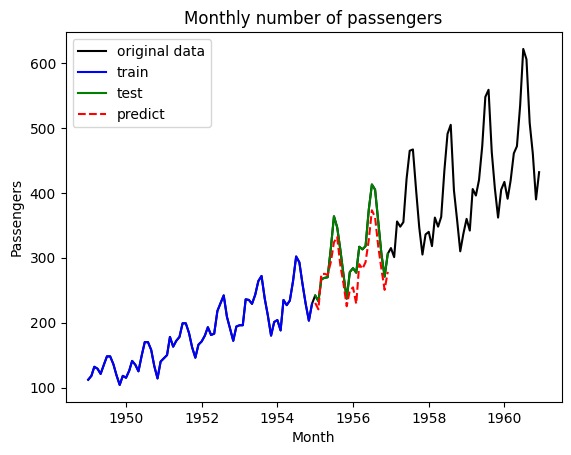

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RMSE for STL Forecasting is 17.255126929007172


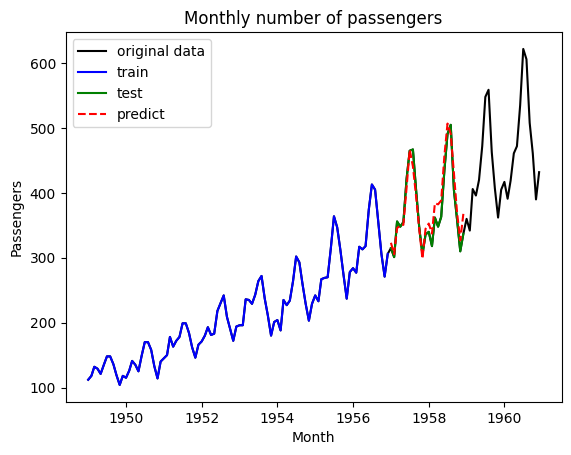

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RMSE for STL Forecasting is 54.901908278079404


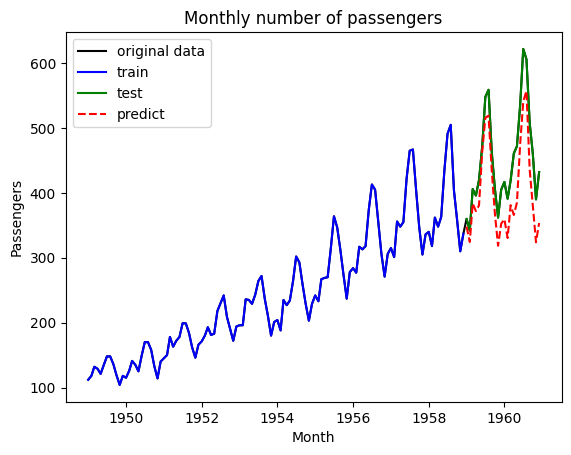

Mean Squared Error: 998.74 +/- 1021.40
Mean Absolute Error: 24.87 +/- 12.83
Root Mean Squared Error: 28.47 +/- 13.72


In [ ]:
# Define the number of splits for the time series cross-validation
n_splits = 5

# Define the time series cross-validation object
#tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the number of steps ahead to forecast
forecast_horizon = 24

# Define lists to store the error metrics for each fold
mse_list = []
mae_list = []
rmse_list = []

# Iterate through each fold of the time series cross-validation
#for train_index, test_index in tscv.split(df_series):
for train_data, test_data in k_folds(air_passengers,n_splits):
    # Split the data into training and test sets for the current fold
    #train_data, test_data = df_series[train_index], df_series[test_index]

    # Apply the STL decomposition to the training data
    stl_data = STL(train_data.Passengers,period = 12, seasonal=13).fit()
    # Model the trend component using ARIMA
    trend_model = ARIMA(stl_data.trend, order=(1, 1, 1)).fit()

    # Model the seasonal component using seasonal ARIMA
    seasonal_model = SARIMAX(stl_data.seasonal, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

    # Forecast the trend and seasonal components for the test data
    trend_forecast = trend_model.forecast(steps=forecast_horizon)
    seasonal_forecast = seasonal_model.forecast(steps=forecast_horizon)

    # Combine the forecasts with the residual component of the STL decomposition to produce the final forecast for the test data
    forecast_values = trend_forecast.values + seasonal_forecast.values + stl_data.resid[-forecast_horizon:].values

    # Calculate the error metrics for the forecast
    mse = ((test_data.Passengers.values - forecast_values)**2).mean()
    mae = abs((test_data.Passengers.values - forecast_values)).mean()
    rmse = evaluate_model(test_data.Passengers.values,forecast_values,'STL Forecasting')
    
    """print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean Absolute Error: {:.2f}".format(mae))
    print("Root Mean Squared Error: {:.2f}".format(rmse))"""
    
    """plt.plot(test_data.Passengers.values, label="Actual Data")
    plt.plot(forecast_values, label="STL Forecast")
    plt.legend()
    plt.show()"""
    plot_predictions(train_data,test_data,forecast_values)
    # Add the error metrics for the current fold to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)
    
# Calculate the mean and standard deviation of the error metrics across all folds
mse_mean = np.mean(mse_list)
mae_mean = np.mean(mae_list)
rmse_mean = np.mean(rmse_list)
mse_std = np.std(mse_list)
mae_std = np.std(mae_list)
rmse_std = np.std(rmse_list)

# Print the error metrics for the cross-validation
print("Mean Squared Error: {:.2f} +/- {:.2f}".format(mse_mean, mse_std))
print("Mean Absolute Error: {:.2f} +/- {:.2f}".format(mae_mean, mae_std))
print("Root Mean Squared Error: {:.2f} +/- {:.2f}".format(rmse_mean, rmse_std))

# 7. ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA


## Check Stationarity With Summary Statistics And ADF

We can take a look on the histogram, and we find that it is skewed indicating that the data is not stationary

(array([24., 27., 19., 18., 22., 13., 10.,  6.,  3.,  2.]),
 array([104. , 155.8, 207.6, 259.4, 311.2, 363. , 414.8, 466.6, 518.4,
        570.2, 622. ]),
 <BarContainer object of 10 artists>)

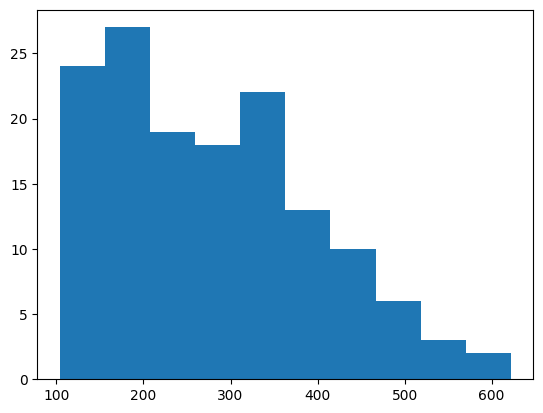

In [ ]:
plt.hist(air_passengers.Passengers)

Also another way to test stationarity, we will use Augmented Dickey Fuller Test (a type of statistical test which is a hypothesis test that tests specifically for stationarity) :

- The null hypothesis is the data is not stationary ,,  H0: φ = 1 (unit root)
- The alternate hypothesis is that the time series is stationary ,, Ha: φ < 1 (No unit root)

- p-value > 0.05: Fail to reject H0 (data has unit root and is non-stationary)
- p-value <= 0.05: reject the H0 (data does not have unit root and is stationary)

In [ ]:
def check_stationarity(df):
    #Determing rolling statistics
    MA = df.rolling(window=12).mean()
    MSTD = df.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(df, color='black',label='original data')
    mean = plt.plot(MA, color='r', label='Rolling Mean')
    std = plt.plot(MSTD, color='b', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    print(dftest)


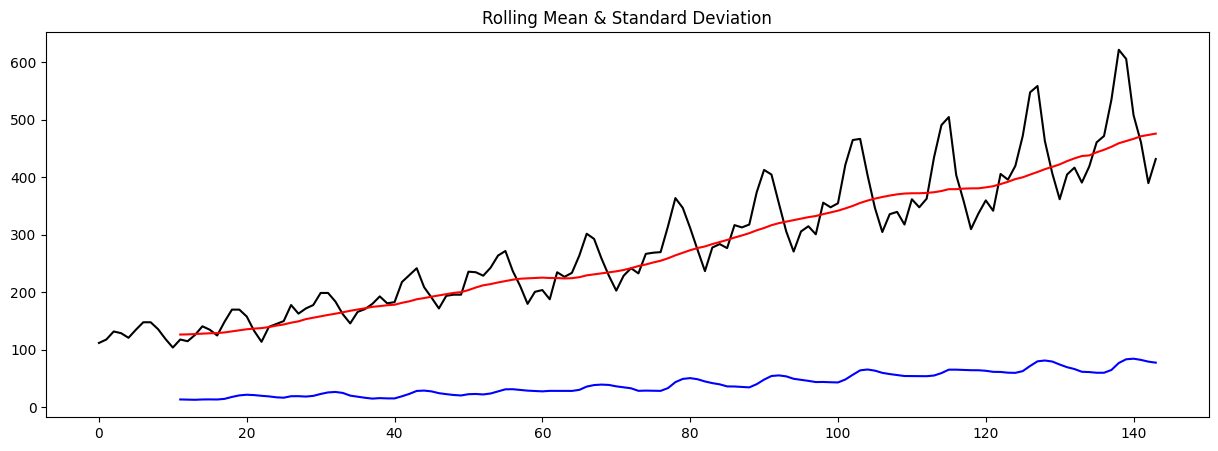

Results of Dickey-Fuller Test:
(0.8153688792060498, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)


In [ ]:
check_stationarity(air_passengers['Passengers'])

From the rolling statistics & ADF statistics we notice that:
- Rolling Mean is changing with time.
- Rolling Standard Deviation has varying troughs that vary with time.
- Test Statistic : (0.82) > Critical Value (5%) : (-2.88)
- p-value (0.99) > 0.05

**Conclusion**:

We fail to reject the Null Hypothesis so the time series is **not stationary**.

## Transform Data

First we will apply log transformation on the time series, to help in removing heteroscedasticity

In [ ]:
df = air_passengers.copy()

In [ ]:
df.Passengers = np.log(df.Passengers)

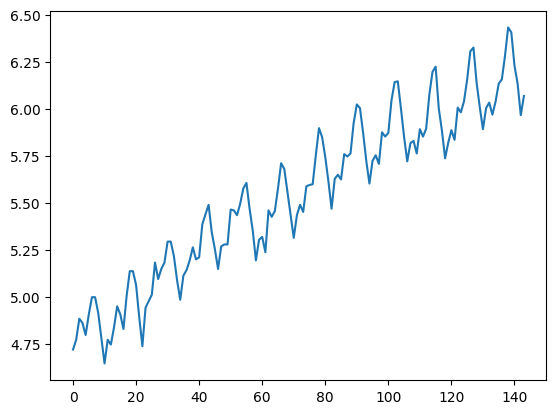

In [ ]:
plt.plot(df['Passengers'])

Looking at the results, we find that the log transformation has improved the heteroscedasticity

But there is still a clear trend and seasonality in the data, so we we will try removing the seasonality first using seasonality first difference

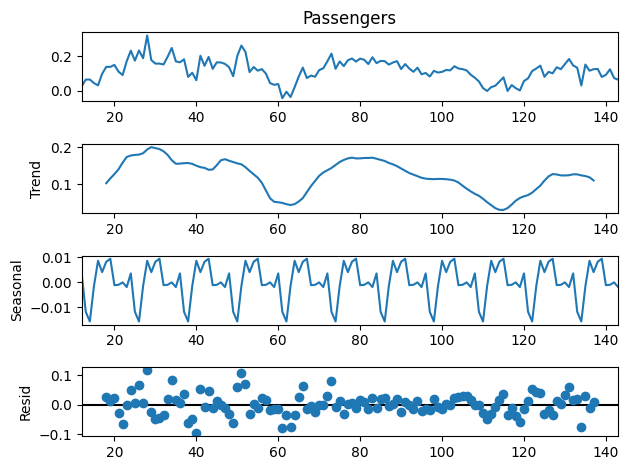

In [ ]:
data_diff = df.Passengers.diff(12)
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()


From the previous plot, the seasonality is remved but we notice that there is still a trend in the data.

Our next step is to remove that trend using first difference

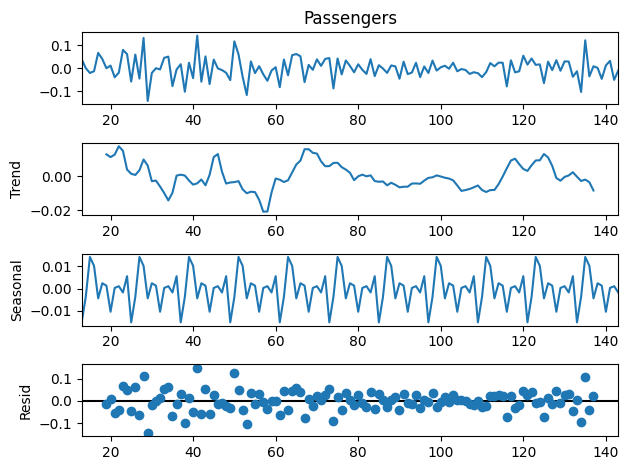

In [ ]:
data_diff = data_diff.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()


Now let's check the stationarity again after all the modifications

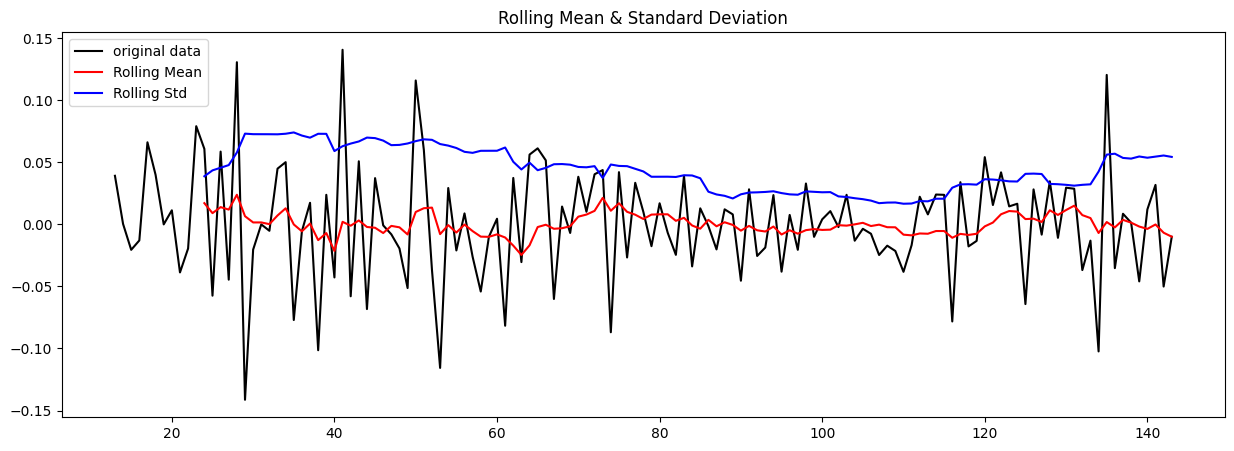

Results of Dickey-Fuller Test:
(-4.4433249418311425, 0.00024859123113838495, 12, 118, {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}, -415.5597525461335)


In [ ]:
check_stationarity(data_diff)

Looking at the previous results, we have a pretty good stationary data: 
- Rolling Mean is almost constant.
- Rolling Standard Deviation has very very small variations in troughs.
- Test Statistic : (-4.44) > Critical Value (5%) : (-2.88)
- p-value (0.0002) < 0.05

## ACF & PACF

In [ ]:
import statsmodels.tsa.api as smt

In [ ]:
def plot_acf_pacf(data):
  smt.graphics.plot_acf(data);
  smt.graphics.plot_pacf(data);

When plotting the ACF & PACF for the data, we notice that ACF drops slowly which confirms that this data is non-stationary data

Also notice how you can see the wavy correlations for the seasonal pattern and
the slowly diminishing lags of a trend

Also looking at the PACF, the 1st lag is out of the confidence interval and is the most significant lag.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


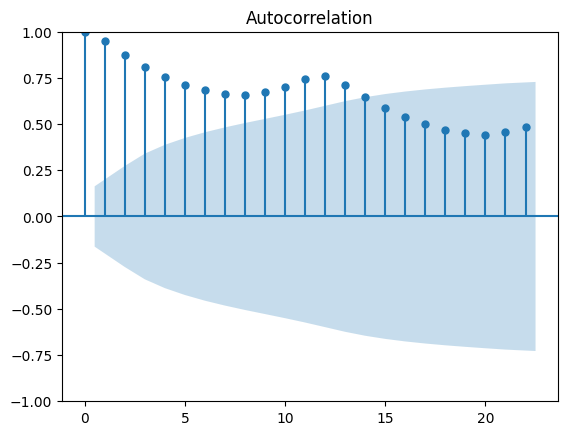

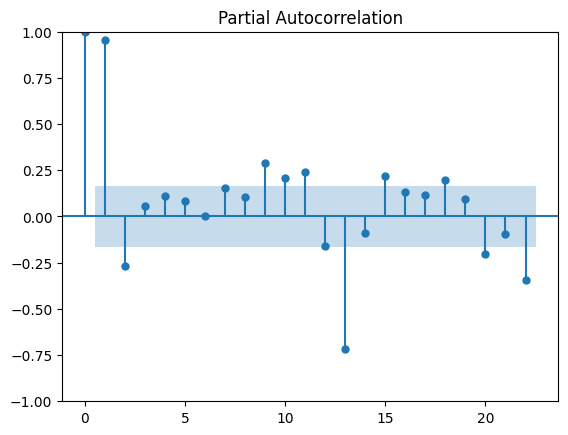

In [ ]:
plot_acf_pacf(air_passengers.Passengers)

Now let's plot the ACF & PACF for the cleaned data

We notice the difference between these plots and the previous one.

As the ACF declines to near zero rapidly confirming that this data is stationary

Based on the ACF & PCF we decide on the values of p & q of the ARIMA.

Where:
- P : Number of auto regressive terms.
- d : Number of differencing orders required to make the time series stationary.
- q : Number of lagged forecast errors in the prediction equation.

Here we will choose p = 2 and q=2

As for the differencing we won't need it as we have already cleaned the data

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


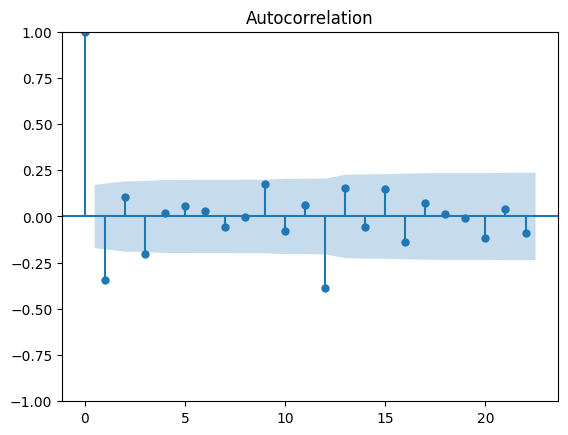

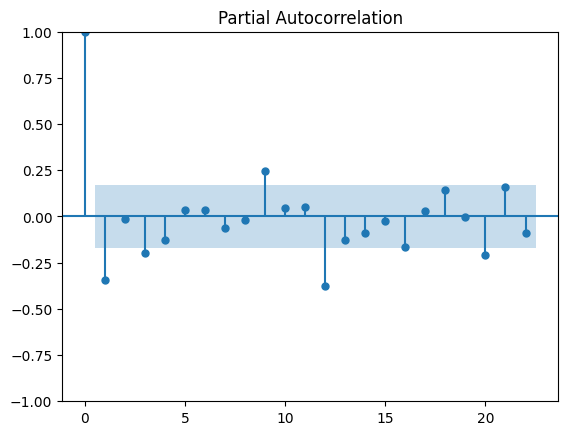

In [ ]:
plot_acf_pacf(data_diff);

## ARIMA & S-ARIMA

In [ ]:
model = ARIMA(data_diff,order = (2,0,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 228.686
Date:                Thu, 06 Apr 2023   AIC                           -445.372
Time:                        20:43:39   BIC                           -428.120
Sample:                             0   HQIC                          -438.362
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.108      0.914      -0.003       0.004
ar.L1         -0.0657      0.470     -0.140      0.889      -0.986       0.855
ar.L2          0.3779      0.216      1.751      0.0

In [ ]:
model = ARIMA(data_diff,order = (1,0,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 227.017
Date:                Thu, 06 Apr 2023   AIC                           -444.035
Time:                        20:53:07   BIC                           -429.659
Sample:                             0   HQIC                          -438.193
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.104      0.917      -0.004       0.005
ar.L1         -0.2704      5.145     -0.053      0.958     -10.354       9.813
ma.L1         -0.1194      5.170     -0.023      0.9

In [ ]:
model = ARIMA(data_diff,order = (2,0,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 230.023
Date:                Thu, 06 Apr 2023   AIC                           -450.047
Time:                        20:53:14   BIC                           -435.671
Sample:                             0   HQIC                          -444.205
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.323      0.747      -0.001       0.001
ar.L1          0.5689      0.084      6.746      0.000       0.404       0.734
ar.L2          0.2452      0.075      3.268      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model = ARIMA(data_diff,order = (1,0,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 227.133
Date:                Thu, 06 Apr 2023   AIC                           -446.266
Time:                        20:53:23   BIC                           -434.765
Sample:                             0   HQIC                          -441.593
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.121      0.904      -0.004       0.004
ar.L1          0.1449      0.187      0.773      0.439      -0.222       0.512
ma.L1         -0.5190      0.163     -3.183      0.0

From the previous trials we choose ARIMA(2, 0, 1) as it has the most significant coefficients

Now let's predict with ARIMA & Evaluate it

## 7.1 Split the data using simple split

In [ ]:
split_percent = 0.7
train_df, test_df = data_split(split_percent, air_passengers)

In [ ]:
new_train = np.log(train_df['Passengers']).values
new_test = np.log(test_df['Passengers']).values

Insted of differencing the data before passing it to ARIMA, we will put d = 1 to apply differencing

In [ ]:
arima_order=(2, 1, 1)

In [ ]:
history = [x for x in new_train]
# make predictions
predictions = list()
for t in range(len(new_test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(new_test[t])


In [ ]:
evaluate_model(test_df['Passengers'].values, np.exp(predictions), "ARIMA")

RMSE for ARIMA is 43.03164943108431


43.03164943108431

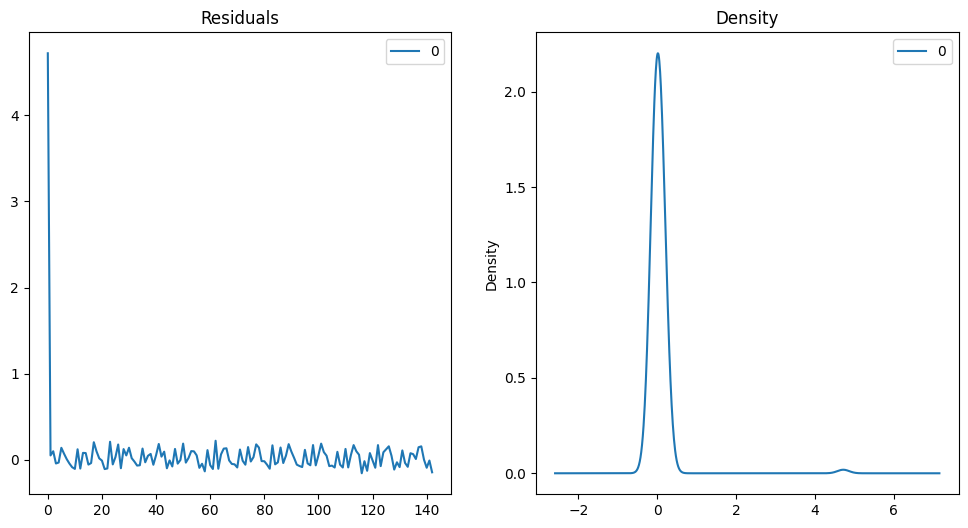

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2);
residuals.plot(title='Residuals', ax=ax[0], figsize=(12,6));
residuals.plot(title='Density', kind='kde', ax=ax[1]);

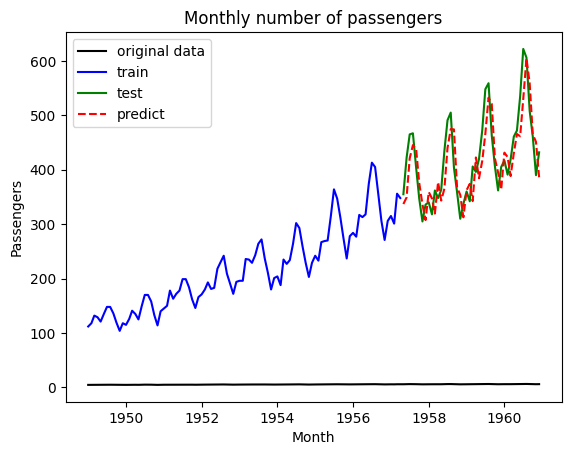

In [ ]:
plot_predictions(train_df, test_df, np.exp(predictions))

In [ ]:
def arima_prediction(train_df, test_df):
  new_train = np.log(train_df['Passengers']).values
  new_test = np.log(test_df['Passengers']).values
  arima_order = (2, 1, 1)
  history = [x for x in new_train]
  # make predictions
  predictions = list()
  for t in range(len(new_test)):
      model = ARIMA(history, order=arima_order)
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      history.append(new_test[t])
  return predictions

### 7.2 Spliting Data Using Cross Validation

In [ ]:
errors = []

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA is 21.478509224198312


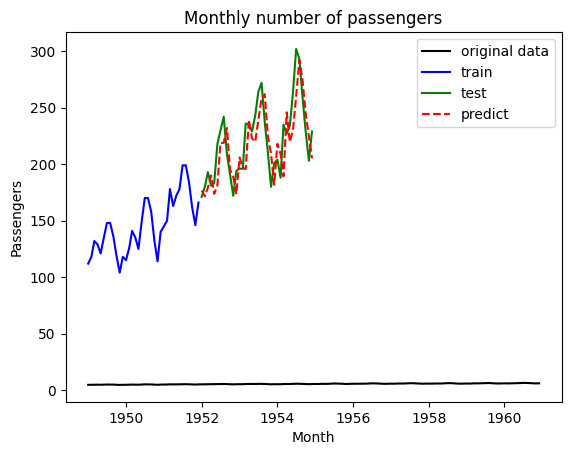

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA is 32.025273455108376


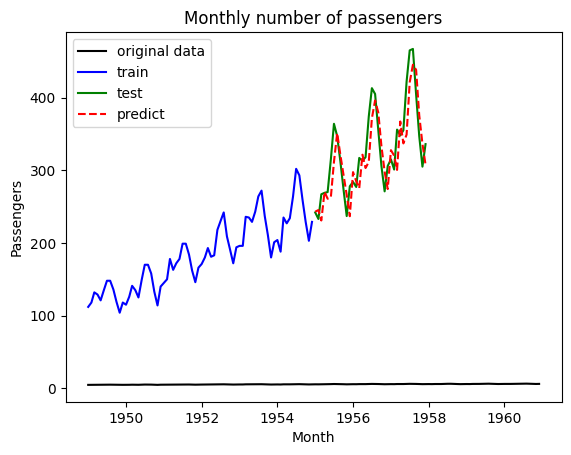

RMSE for ARIMA is 43.983419328565766


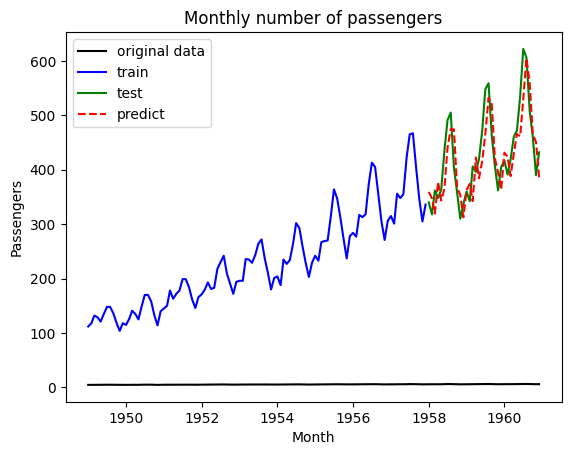

In [ ]:
for train, test in k_folds(air_passengers, n_splits = 3):
  predictions = arima_prediction(train, test)
  e = evaluate_model(test.Passengers.values, np.exp(predictions), "ARIMA")
  errors.append(e)
  plot_predictions(train, test, np.exp(predictions))

In [ ]:
print("ARIMA Decomposition Error: ", sum(errors)/len(errors))

ARIMA Decomposition Error:  32.495734002624154


## 8. Exponential Smoothing

* <b>Exponential smoothing</b> is a method to predict the future values of a time series by giving more weight to the more recent observations. 
* The idea is that recent observations are more relevant to predict the future than older observations.

### 8.1. Single Exponential Smoothing

RMSE for Single Exponential Smoothing is 119.32614911101324


Text(0.5, 1.0, 'Single Exponential Smoothing with RMSE 119.32614911101324')

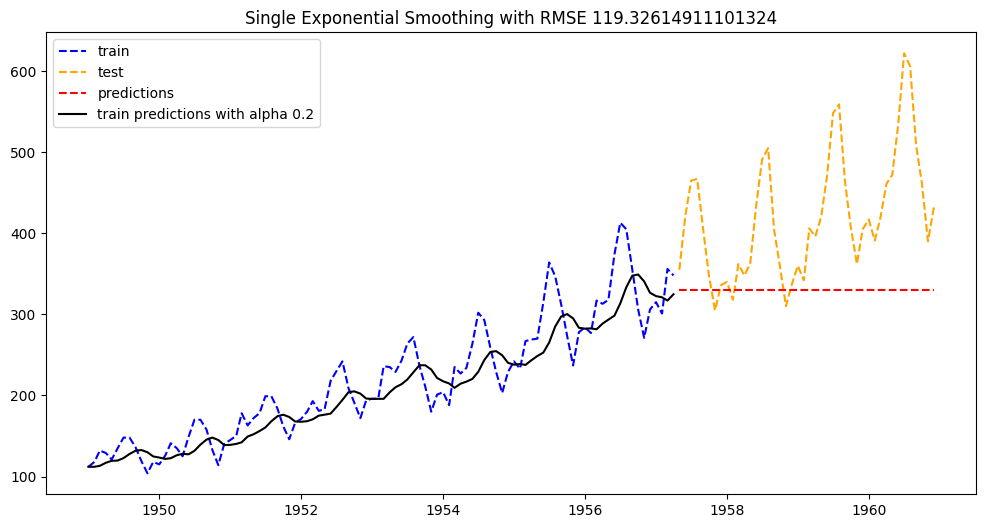

In [ ]:
single = SimpleExpSmoothing(train_df.Passengers, initialization_method= 'known',
                            initial_level=train_df.Passengers.values[0]).fit(optimized=False, smoothing_level=0.2)

single_preds = single.forecast(test_df.shape[0])
# single_rmse = np.sqrt(mean_squared_error(test_df.Passengers, single_preds))
single_rmse = evaluate_model(test_df.Passengers, single_preds, 'Single Exponential Smoothing')
plt.figure(figsize=(12,6));

plt.plot(train_df.Month, train_df.Passengers, 'b--', label="train")
plt.plot(test_df.Month, test_df.Passengers, color='orange', linestyle="--", label="test")
plt.plot(test_df.Month, single.predict(100,143), 'r--', label="predictions")
plt.plot(train_df.Month,single.predict(0,99), 'black', label="train predictions with alpha " + 
                                                              str(single.model.params["smoothing_level"]));

plt.legend(loc='upper left')
plt.title(f"Single Exponential Smoothing with RMSE {single_rmse}")

### Try to let the model estimate an alpha

RMSE for Single Exponential Smoothing is 105.7498118667431


Text(0.5, 1.0, 'Single Exponential Smoothing with RMSE 105.7498118667431')

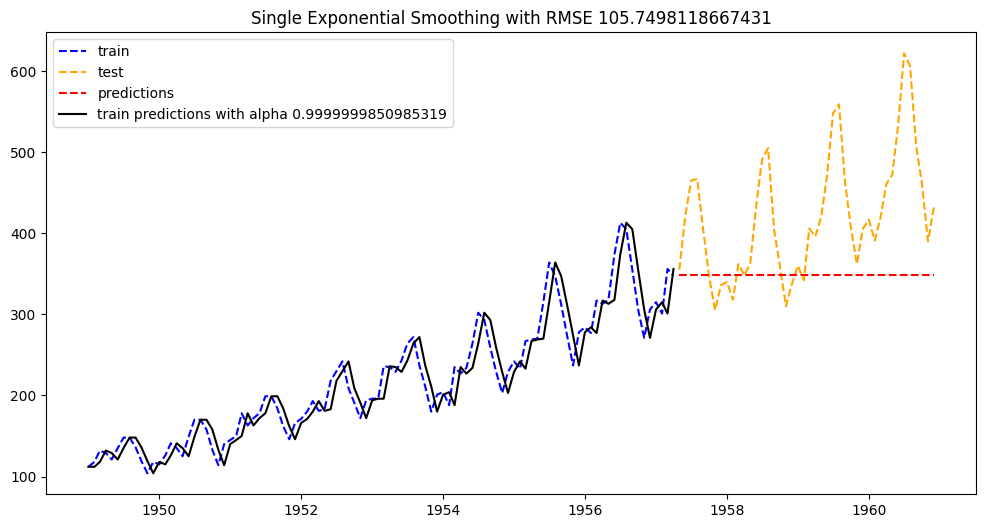

In [ ]:
single = SimpleExpSmoothing(train_df.Passengers, 
                            initialization_method="estimated").fit()
single_preds = single.forecast(test_df.shape[0])
single_rmse = evaluate_model(test_df.Passengers, single_preds, 'Single Exponential Smoothing')

plt.figure(figsize=(12,6));

plt.plot(train_df.Month, train_df.Passengers, 'b--', label="train")
plt.plot(test_df.Month, test_df.Passengers, color='orange', linestyle="--", label="test")
plt.plot(test_df.Month, single.predict(test_df.index[0], test_df.index[-1]), 'r--', label="predictions")
plt.plot(train_df.Month,single.predict(train_df.index[0], train_df.index[-1]), 'black', label="train predictions with alpha " + 
                                                              str(single.model.params["smoothing_level"]));

plt.legend(loc='upper left')
plt.title(f"Single Exponential Smoothing with RMSE {single_rmse}")

<b>As shown in the above plot:</b>
* The single exponential smoothing doesn't exhibit trend or seasonality in the test data. So, it's very bad in dealing with non-stationary data
* The model assumes that the future value of the time series is based on 
    * The current value 
    * A weighted average of the past values.
* Higher values of alpha (smoothing factor) placing more weight on recent observations and lower values placing more weight on past observations.

<b>The results show that:</b>
* The single exponential smoothing model performs quite poorly on this dataset, with a high RMSE of 105.75.
* This is likely due to the fact that the dataset has a clear trend and seasonality, which the single exponential smoothing model <b>cannot capture</b>.

## 8.2. Double Exponential Smoothing

RMSE for Double Exponential Smoothing is 70.65211496955989


Text(0.5, 1.0, 'Double Exponential Smoothing with RMSE 70.65211496955989')

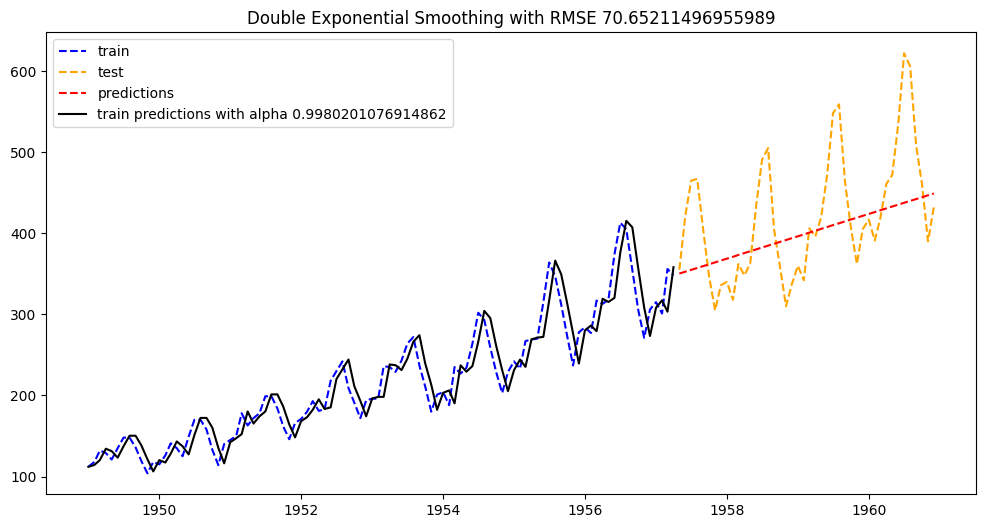

In [ ]:
double_es = Holt(train_df.Passengers).fit()
double_preds = double_es.forecast(test_df.shape[0])
# double_rmse = np.sqrt(mean_squared_error(test_df.Passengers, double_preds))
double_rmse = evaluate_model(test_df.Passengers, double_preds, 'Double Exponential Smoothing')

plt.figure(figsize=(12,6));

plt.plot(train_df.Month, train_df.Passengers, 'b--', label="train")
plt.plot(test_df.Month, test_df.Passengers, color='orange', linestyle="--", label="test")
plt.plot(test_df.Month, double_es.predict(test_df.index[0], test_df.index[-1]), 'r--', label="predictions")
plt.plot(train_df.Month,double_es.predict(train_df.index[0], train_df.index[-1]), 'black', label="train predictions with alpha " + 
                                                              str(double_es.model.params["smoothing_level"]));

plt.legend(loc='upper left')
plt.title(f"Double Exponential Smoothing with RMSE {double_rmse}")

* Double exponential smoothing is used when there is a <b>trend</b> in the data.
* The smoothing trend parameter (beta) controls the weight given to past trends, with higher values of beta giving more weight to recent trends.

<b>The results show that:</b>
* The double exponential smoothing model performs better than the single exponential smoothing model, with a lower RMSE of 70.652. However, the model still doesn't capture the seasonality of the dataset.

## 8.3. Triple Exponential Smoothing

RMSE for Triple Exponential Smoothing is 19.209609838757256


Text(0.5, 1.0, 'Triple Exponential Smoothing with RMSE 19.209609838757256')

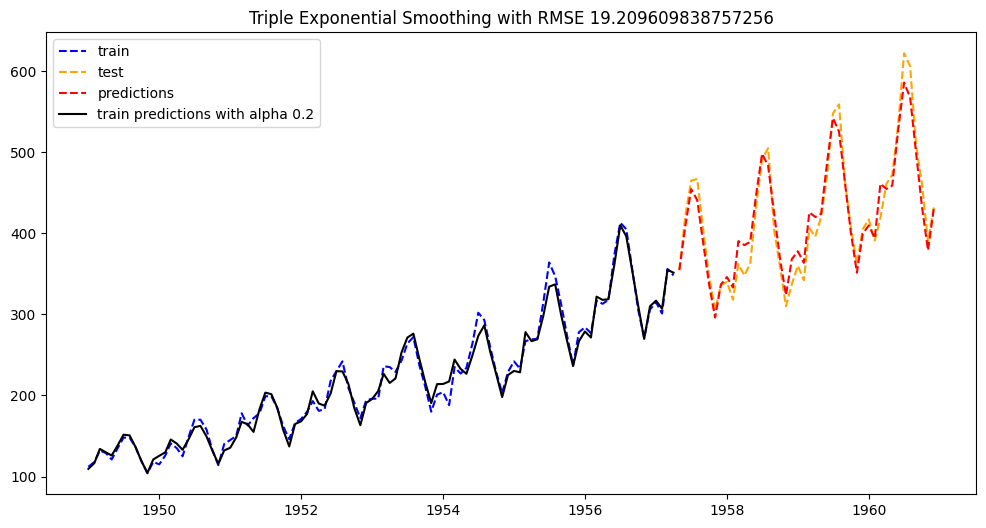

In [ ]:
triple = ExponentialSmoothing(train_df.Passengers,
                              trend="add",
                              seasonal="mul",
                              seasonal_periods=12).fit(method='bh', smoothing_level=0.2)
triple_preds = triple.forecast(test_df.shape[0])
triple_rmse = evaluate_model(test_df.Passengers, triple_preds, 'Triple Exponential Smoothing')

plt.figure(figsize=(12,6));

plt.plot(train_df.Month, train_df.Passengers, 'b--', label="train")
plt.plot(test_df.Month, test_df.Passengers, color='orange', linestyle="--", label="test")
plt.plot(test_df.Month, triple.predict(100,143), 'r--', label="predictions")
plt.plot(train_df.Month,triple.predict(0,99), 'black', label="train predictions with alpha " + 
                                                              str(triple.model.params["smoothing_level"]));

plt.legend(loc='upper left')
plt.title(f"Triple Exponential Smoothing with RMSE {triple_rmse}")

<b>Note:</b>
* The <b>predict()</b> method can be used to make predictions for a specific range of indices,
* whereas the <b>forecast()</b> method is used to make predictions for a fixed number of periods into the future.

<b>The results show that:</b>
* Triple Exponential Smoothing model performs better than the other two models, with RMSE of 19.21.
* Triple Exponential Smoothing: This method adds a seasonal component to the level and trend components, allowing it to capture both trends and seasonality in the time series. 
* It is therefore more suitable for time series data with both trends and seasonality like the data we are using.

<b></b>

### Plot the forcasting of the three models

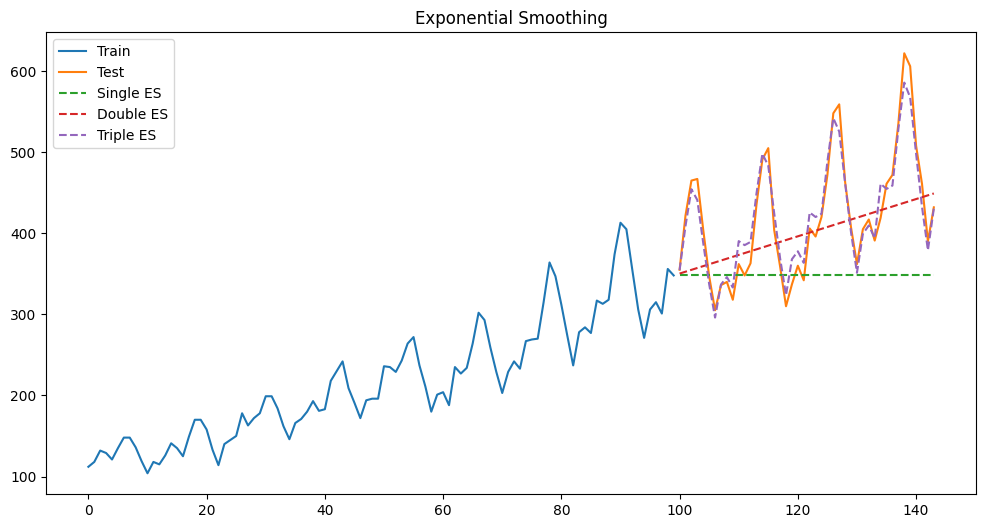

In [ ]:
# Perform single exponential smoothing
model_ses = SimpleExpSmoothing(train_df['Passengers']).fit()
pred_ses = model_ses.predict(test_df.index[0], test_df.index[-1])

# Perform double exponential smoothing
model_des = Holt(train_df['Passengers']).fit()
pred_des = model_des.predict(test_df.index[0], test_df.index[-1])

# Perform triple exponential smoothing
model_tes = ExponentialSmoothing(train_df['Passengers'],
                                 trend='add',
                                 seasonal='mul',
                                 seasonal_periods=12).fit(method='bh', smoothing_level=0.2)

pred_tes = model_tes.predict(test_df.index[0], test_df.index[-1])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df['Passengers'], label='Train')
plt.plot(test_df['Passengers'], label='Test')
plt.plot(pred_ses, label='Single ES', linestyle="--")
plt.plot(pred_des, label='Double ES', linestyle="--")
plt.plot(pred_tes, label='Triple ES', linestyle="--")
plt.legend()
plt.title('Exponential Smoothing')
plt.show()

<b>In conclusion:</b>
* The <b>simple</b> exponential smoothing performs well with the <b>stationary data</b>, the data that doesn't have trend or seasonality
* The <b>double</b> exponential smoothing adds a <b>trend component</b> to the level component which allows it to <b>capture trends</b> in the time series. It is therefore more suitable for time series data with a trend.
* The <b>triple</b> exponential smoothing adds a <b>seasonal component</b> to the level and trend components, which allows it to <b>capture both trends and seasonality</b> in the time series. It is therefore more suitable for time series data with both trends and seasonality.

<b>For Dampening:</b></br>
- Let's first understand the meaning of "Dampening/Damping". <b>Dampening:</b> is a technique used in time series forecasting to address the <b>issue of overfitting</b> in models that include a trend/seasonality component.
- We use a dampening parameter (phi) to <b>gradually reduces</b> the influence of the trend/seasonality component on future predictions. This helps to prevent the model from extending the trend/seasonality too far into the future and producing unrealistic results.

  * Theoretically: 
      * it may be necessary to dampen the trend or seasonality components of the time series if they are growing or decaying too quickly.

  * Practically:
      * In this case, none of the three methods showed any obvious signs of requiring dampening, as the trend and seasonal components <b>did not appear to be growing or decaying too quickly.</b>

## 9. Apply Facebook Prophet Algorithm.

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 53.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

### 9.1 Splitting method 1/3: simple train test split

since we're using a ready-made tool we need to rename data columns according to their documentation otherwise it gives us an error

In [ ]:
train, test = data_split(.8, new_df)

train = train.rename(columns={'Date': 'ds',
                        'Passengers': 'y'})

# model = Prophet(interval_width=0.95)    # certainty interval 95%
model = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)   # since we know that the yearly seasonality exists, making that argument "True" will result in slightly better outcomes
model.fit(train)
future_dates = model.make_future_dataframe(periods=36, freq='MS')
forecast = model.predict(future_dates)  # huge df with loads of info :) I will print it for you
test['Predictions'] = forecast['yhat']

model.plot(forecast, uncertainty=True)
model.plot_components(forecast)

# plottng with changepoints
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

evaluate_model(test['Passengers'], test['Predictions'], "Facebook Prophet Algorithm")

plt.figure(figsize=(15, 5))
plt.plot(train['y'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.title('Facebook Prophet Algorithm')
plt.show()

In [ ]:
forecast

In [ ]:
model.changepoints

### 9.2 Splitting method 2/3: k folds

In [ ]:
errors = []
for train, test in k_folds(new_df):
    train = train.rename(columns={'Date': 'ds',
                            'Passengers': 'y'})
    model = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)   # since we know that the yearly seasonality exists, making that argument "True" will result in slightly better outcomes
    model.fit(train)
    future_dates = model.make_future_dataframe(periods=36, freq='MS')
    forecast = model.predict(future_dates)  # huge df with loads of info :) I will print it for you
    test['Predictions'] = forecast['yhat']

    model.plot(forecast, uncertainty=True)
    model.plot_components(forecast)

    # plottng with changepoints
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)

    e = evaluate_model(test['Passengers'], test['Predictions'], "Facebook Prophet Algorithm")
    errors.append(e)

    plt.figure(figsize=(15, 5))
    plt.plot(new_df['Passengers'], label='Original Data')
    plt.plot(train['y'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title('Facebook Prophet Algorithm')
    plt.show()

In [ ]:
print("Facebook Prophet: ", sum(errors)/len(errors))

### 9.3 Splitting method 3/3: roll forward

In [ ]:
errors = []
for train, test in roll_forward(new_df):
  if len(train) >= 24:
    train = train.rename(columns={'Date': 'ds',
                            'Passengers': 'y'})
    model = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)   # since we know that the yearly seasonality exists, making that argument "True" will result in slightly better outcomes
    model.fit(train)
    future_dates = model.make_future_dataframe(periods=test.shape[0], freq='MS')
    forecast = model.predict(future_dates)  # huge df with loads of info :) I will print it for you
    forecast.set_index(np.arange(test.index[-1]-future_dates.shape[0]+1,test.index[-1]+1), inplace=True)
    test['Predictions'] = forecast['yhat']

    model.plot(forecast, uncertainty=True)
    model.plot_components(forecast)

    # plottng with changepoints
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)

    e = evaluate_model(test['Passengers'], test['Predictions'], "Facebook Prophet Algorithm")
    errors.append(e)

    plt.figure(figsize=(15, 5))
    plt.plot(new_df['Passengers'], label='Original Data')
    plt.plot(train['y'], label='Train')
    plt.plot(test['Passengers'], label='Test')
    plt.plot(test['Predictions'], label='Predictions')
    plt.legend()
    plt.title('Facebook Prophet Algorithm')
    plt.show()

In [ ]:
print("Facebook Prophet: ", sum(errors)/len(errors))

## 10. XGBOOST regressor.

In [ ]:
from xgboost import XGBRegressor

### XGBoost on the data itself (simple train-test split)

In [ ]:
dff = pd.read_csv(path,date_parser=True)

dff['Month']= pd.to_datetime(dff['Month'])
lags = 6
for i in range(1,lags+1):
    dff[f't-{i}'] = dff['Passengers'].shift(i)
    
dff.fillna(0,inplace=True)


train_data, test_data = data_split(0.8,dff)

trian_features = train_data.loc[:,'t-1':'t-6']
train_label = train_data.loc[:,'Passengers']

test_features = test_data.loc[:,'t-1':'t-6']
test_label = test_data.loc[:,'Passengers']


model = XGBRegressor(n_estimators=1000)
model.fit(trian_features,train_label)

pred = model.predict(test_features)

rmse = evaluate_model(test_label.values,pred,'XGBoost Regression')
#print('RMSE: ',rmse)

plt.plot(test_label.values, label="Actual Data")
plt.plot(pred, label="XGBoost")
plt.legend()
plt.show()

plot_predictions(train_data,test_data,pred)

### XGBoost on the data itself  cross validation

In [ ]:
# Define the number of splits for the time series cross-validation
n_splits = 5

# Define the time series cross-validation object
#tscv = TimeSeriesSplit(n_splits=n_splits)


# Define lists to store the error metrics for each fold
mse_list = []
mae_list = []
rmse_list = []

# Iterate through each fold of the time series cross-validation
for train_data, test_data in k_folds(dff,n_splits):
    
    # Split the data into training and test sets for the current fold
    #train_data, test_data = dff.iloc[train_index,:], dff.iloc[test_index,:]
     
    trian_features = train_data.loc[:,'t-1':'t-6']
    train_label = train_data.loc[:,'Passengers']
    test_features = test_data.loc[:,'t-1':'t-6']
    test_label = test_data.loc[:,'Passengers']
    
    model = XGBRegressor(n_estimators=1000)
    model.fit(trian_features,train_label)
    
    pred = model.predict(test_features)
    
    rmse = evaluate_model(test_label.values,pred,'XGBoost Regression')
    
    
    """print("Mean Absolute Error: {:.2f}".format(mae))
    print("Root Mean Squared Error: {:.2f}".format(rmse))"
    
    plt.plot(test_label.values, label="Actual Data")
    plt.plot(pred, label="XGBoost regressor")
    plt.legend()
    plt.show()"""

    # plot
    plot_predictions(train_data,test_data,pred)

    # Add the error metrics for the current fold to the lists
    mae_list.append(mae)
    rmse_list.append(rmse)
    
# Calculate the mean and standard deviation of the error metrics across all folds
mae_mean = np.mean(mae_list)
rmse_mean = np.mean(rmse_list)
mae_std = np.std(mae_list)
rmse_std = np.std(rmse_list)

# Print the error metrics for the cross-validation
print("Mean Absolute Error: {:.2f} +/- {:.2f}".format(mae_mean, mae_std))
print("Root Mean Squared Error: {:.2f} +/- {:.2f}".format(rmse_mean, rmse_std))


Ok,after applying XGBoost regressor on the data itself,I notice the accuracy is very bad and RMSE,MAE are high,SO I searched and found that: non-stationary time series data can exhibit trends, seasonality, and other patterns that change over time. In this case, it is important to preprocess the data to make it stationary before using XGBoost.

SO I will apply XGBoodt Regressor with STL Decomposition and Forecasting.

### Simple train test split STL (XGBoost Regressor)

In [ ]:
# Split the data into train and test sets
#train_size = int(len(df_series) * 0.8)
train_data, test_data = data_split(0.8,dff) #df_series[0:train_size], df_series[train_size:]

# Apply STL to the train set
stl_train = STL(train_data.Passengers,period = 12, seasonal=13).fit()

# Separate the train set into trend and seasonal components
trend_train, seasonal_train = stl_train.trend, stl_train.seasonal

# Train an XGBoost regressor on the trend and seasonal components
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(pd.concat([trend_train, seasonal_train], axis=1), train_data.Passengers)

# Apply STL to the test set
stl_test = STL(test_data.Passengers,period = 12,seasonal=13).fit()

# Separate the test set into trend, seasonal, and residual components
trend_test, seasonal_test, residual_test = stl_test.trend, stl_test.seasonal, stl_test.resid
# Make predictions on the decomposed test set using the trained model
pred_trend_seasonal = model.predict(pd.concat([trend_test, seasonal_test], axis=1))

# Combine the predicted trend and seasonal components with the residual component of the decomposed test set to get the final predictions
final_preds = pred_trend_seasonal + residual_test
plt.plot(test_data.Passengers, label="Actual Data")
plt.plot(final_preds, label="XGBoost STL Forecast")
plt.xticks(rotation = 45)
plt.legend()
plt.show()
# Evaluate the model's performance
rmse = evaluate_model(test_data.Passengers, final_preds,"XGBoost STL")
#print('Test RMSE: %.3f' % rmse)
plot_predictions(train_data,test_data,final_preds)

### Cross validation STL (XGBoost Regressor)

In [ ]:
# Define the number of steps ahead to forecast
forecast_horizon = 24
n_splits = 5
# Define the time series cross-validation object
#tscv = TimeSeriesSplit(n_splits=n_splits)
# Define lists to store the error metrics for each fold
mse_list = []
mae_list = []
rmse_list = []

# Iterate through each fold of the time series cross-validation
for train_data, test_data in k_folds(dff,n_splits):

    # Split the data into training and test sets for the current fold
    #train_data, test_data = df_series[train_index], df_series[test_index]

    # Apply the STL decomposition to the training data
    stl_train = STL(train_data.Passengers,period = 12, seasonal=13).fit()
    # Separate the train set into trend and seasonal components
    trend_train, seasonal_train = stl_train.trend, stl_train.seasonal

    # Train an XGBoost regressor on the trend and seasonal components
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(pd.concat([trend_train, seasonal_train], axis=1), train_data.Passengers)

    # Apply STL to the test set
    stl_test = STL(test_data.Passengers,period = 12, seasonal=13).fit()

    # Separate the test set into trend, seasonal, and residual components
    trend_test, seasonal_test, residual_test = stl_test.trend, stl_test.seasonal, stl_test.resid
    # Make predictions on the decomposed test set using the trained model
    pred_trend_seasonal = model.predict(pd.concat([trend_test, seasonal_test], axis=1))

    # Combine the forecasts with the residual component of the STL decomposition to produce the final forecast for the test data
    forecast_values = pred_trend_seasonal + stl_data.resid[-forecast_horizon:].values

    # Calculate the error metrics for the forecast
    mse = ((test_data.Passengers - forecast_values)**2).mean()
    mae = abs((test_data.Passengers - forecast_values)).mean()

    rmse = evaluate_model(test_data.Passengers, forecast_values,"XGBoost STL")
    
    """print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean Absolute Error: {:.2f}".format(mae))
    print("Root Mean Squared Error: {:.2f}".format(rmse))
    
    plt.plot(test_data.Passengers.values, label="Actual Data")
    plt.plot(forecast_values, label="STL Forecast")
    plt.legend()
    plt.show()"""
    # plot
    plot_predictions(train_data,test_data,forecast_values)
    # Add the error metrics for the current fold to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)
    
# Calculate the mean and standard deviation of the error metrics across all folds
mse_mean = np.mean(mse_list)
mae_mean = np.mean(mae_list)
rmse_mean = np.mean(rmse_list)
mse_std = np.std(mse_list)
mae_std = np.std(mae_list)
rmse_std = np.std(rmse_list)

# Print the error metrics for the cross-validation
print("Mean Squared Error: {:.2f} +/- {:.2f}".format(mse_mean, mse_std))
print("Mean Absolute Error: {:.2f} +/- {:.2f}".format(mae_mean, mae_std))
print("Root Mean Squared Error: {:.2f} +/- {:.2f}".format(rmse_mean, rmse_std))

## In conclusion:
* After trying these different forecasting techniques, it seems that the <b>Triple Exponential Smoothing</b> model is the best one with the least <b>RMSE 19.21</b>.